## Preparation

In [1]:
# importing required libraries
import numpy as np
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import pygeostat as gs
import pandas as pd
import random
%matplotlib inline

In [2]:
# Create figure directory
import os
figfolder = 'figures_thesis'
try:
    os.mkdir(figfolder)
    print("Directory " , figfolder ,  " Created ") 
except FileExistsError:
    print("Directory " , figfolder ,  " already exists")

Directory  figures_thesis  already exists


In [3]:
#configuration of the first grid (mining face 1):
nx=10    #number of blocks in axis x
ny=16    #number of blocks in axis y
nz=1     #number of blocks in axis z

xmn=5    #origin of the first block in axis x
ymn=5    #origin of the first block in axis y
zmn=5    #origin of the first block in axis z

xsiz=10  #size of each block along axis x
ysiz=10  #size of each block along axis y
zsiz=10  #size of each block along axis z

#configuration of the second grid (mining face 2):
nx2=16   #number of blocks in axis x2
ny2=5    #number of blocks in axis y2
nz2=1    #number of blocks in axis z2

xmn2=205 #origin of the first block in axis x2
ymn2=205 #origin of the first block in axis y2
zmn2=205 #origin of the first block in axis z2

xsiz2=10 #size of each block along axis x2
ysiz2=10 #size of each block along axis y2
zsiz2=10 #size of each block along axis z2

#configuration of the processing parameters:
parcels_in_bunit = 24   #number of blocks in a blending unit
face1_face2_ratio = 2   #block extraction rate between mining face 1 and face 2

#calculations of number of blocks from face 1 and face2 that composes a blending unit
p_units = round(round(parcels_in_bunit/(face1_face2_ratio+1))*face1_face2_ratio)
p_units2= parcels_in_bunit - p_units

#adjusting to pygeosts format
grid = gs.GridDef(grid_str="{} {} {}  \n{} {} {}  \n{} {} {}".format(nx,xmn,xsiz, ny,ymn,ysiz, nz,zmn,zsiz))
grid2 = gs.GridDef(grid_str="{} {} {}  \n{} {} {}  \n{} {} {}".format(nx2,xmn2,xsiz2, ny2,ymn2,ysiz2, nz2,zmn2,zsiz2))

## generating data for the example

two mining faces are unconditionally simulated through GSLIB usgsim program

In [4]:
usgsim = gs.Program('usgsim',getpar=True)

Unable to find the provided program! Trying to use the executable pool shipped with pygeostat!
C:\Users\phaca\OneDrive\UFRGS\Tese\UAlberta files\CCG scripts\optimization\tmpgmxelmve\usgsim.par has been copied to the clipboard


In [5]:
usgsimpar = """               Parameters for USGSIM
               *********************

START OF MAIN:
1                             -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
0                             -number of rock types to consider
69069                         -random number seed
{griddef}
{out1}                     -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=binary)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output 


START OF SRCH:
50                            -number of data to use per variable
500.0   500.0   10.0            -maximum search radii (hmax,hmin,vert)
45.0    0.0    0.0             -angles for search ellipsoid
0                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use


START OF VARG:
1                             -number of variograms
1  1  1                       -rock type, variable 1, variable 2
1    0.0   1.0                -  number of structures, nugget effect, sill
1    1.0 45.0   0.0   0.0     -  type,variance,ang1,ang2,ang3
         500.0  20.0  10.0     -  a_hmax, a_hmin, a_vert


#START OF DATA:
cluster.dat                   -file with primary data
1  2  0  0  0                 -  columns for X,Y,Z,wt,rock type
3  4                          -  columns for variables
1                             -  clip data to grid, 1=yes
1                             -  assign to the grid, 0=none, 1=nearest, 2=average
-1.0       1.0e21             -  trimming limits


#START OF TRAN:
1                             -transform the data, 1=nscore
200                           -number of quantiles to keep
3                             -number of min/max values
1  1 0.0   15.0               -  rock type, variable, min, max
1  2 0.0   15.0               -  rock type, variable, min, max
1  3 0.0   15.0               -  rock type, variable, min, max
0                             -number of reference distributions
1  1                          -  rock type number, primary variable number
ref11.dat                     -   file with ref. distribution
1  0                          -   columns for value and weight
1  2                          -  rock type number, primary variable number
ref12.dat                     -   file with ref. distribution
1  0                          -   columns for value and weight


#START OF TRND:
0                             -use ordinary kriging (0=no, 1=yes)
2                             -number of locally varying means
1  1                          -  rock type number, primary variable number
lvm11.dat                     -   file with local mean
1                             -   column for value
1  2                          -  rock type number, primary variable number
lvmfl12.dat                   -   file with local mean
1                             -   column for value


#START OF SECV:
0                             -number of secondary variables to consider
-998 1E11                     -trimming limits
sgsim01.dat                   -file 1 with secondary variables
1 1                           -  number of variables in file and column numbers
sgsim02.dat                   -file 2 with secondary variables
2 1 2                         -  number of variables and column numbers
1                             -transform secondary variables


#START OF ROCK:
1  2  3                       -rock type codes
sisim.out                     -file with rock types
1                             -column for rock type


START OF MULT:
1                             -1=independent, 2=CCK, 4=CK, 5=ICCK, 6=BU
0                             -option for primary variables if BU; or for secondary variables if CK
1                             -perform cosimulation for multiple primary variables, 1=yes
1                             -rock type for correlation matrix
 1  0.6 0.7 0.5 0.6           -  correlation matrix: 1-1, 1-2, 1-3, 1-sec1, 1-sec2
0.6  1  0.4 0.3 0.4           -                      2-1, 2-2, 2-3, 2-sec1, 2-sec2
0.7 0.3  1  0.5 0.6           -                      ...
0.5 0.3 0.5  1  0.5           -                      ...
0.6 0.4 0.6 0.5  1            -                      ...



#ADDITIONAL OPTIONS:


#XYZFILE "filename" xcol ycol zcol
#SPARSE numcells
#SPLITBYREALIZATION
#COVLOOKUPOFF
#NINTEGRATE 21

#XYZFILE - specify coordinates that flag a region in the regular
#          grid for simulation. Simulation is still done on a the
#          regular grid.
#SPARSE numcells - specify the number of locations in the XYZFILE
#                  and turn on sparse output (only nodes that are
#                  simulated are output). Use with XYZFILE.
#SPLITBYREALIZATION - realizations are output to their own files
#COVLOOKUPOFF - turn off the covariance lookup table. This may be
#               required for large problems (big grid and/or many variables)
#ZERODIST value - override the minimum distance that is considered a zero
                  distance for covariance calculations
#NINTEGRATE - specify number of integration points for backtransform
#             of kriged estimates when a normal score is done.
#             If not specified, the default of 11 is used.


# If a block of parameters is not used / not required, it can be
# deleted or commented out using a pound-sign (#)
#
"""

usgsim.run(parstr=usgsimpar.format(griddef=grid,
                                   out1 = figfolder+'/sgsim.out',
))

Calling:  ['C:\\Users\\phaca\\anaconda3\\lib\\site-packages\\pygeostat\\executable\\usgsim', 'temp']

 USGSIM VERSION 4.0.5


 Reading parameters

Found keyword START OF MAIN

 Reading MAIN Parameters

 number of realizations =     1
 number of variables =        1
 number of rock types =       0
 random number seed =     69069
 X grid specification =     10   5.000       10.00    
 Y grid specification =     16   5.000       10.00    
 Z grid specification =      1   5.000       10.00    
 output file figures_thesis/sgsim.out
 output format =    0
 imputation file impute.out
 debug level =    0
 debugging file sgsim.dbg

Found keyword START OF SRC

 Reading SRCH Parameters

 number of nodes to use =   50
 search radii  =    500.0       500.0       10.00    
 search angles =    45.00       0.000       0.000    
 search sorting method =  0
 variogram index for sorting =     1    1    1

Found keyword START OF VARG

 Reading VARG Parameters

 number of variograms =    1

 variogram: rock

In [6]:
usgsimpar = """               Parameters for USGSIM
               *********************

START OF MAIN:
1                             -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
0                             -number of rock types to consider
69069                         -random number seed
{griddef}
{out2}                     -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=binary)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output 


START OF SRCH:
50                            -number of data to use per variable
500.0   200.0   10.0            -maximum search radii (hmax,hmin,vert)
45.0    0.0    0.0             -angles for search ellipsoid
0                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use


START OF VARG:
1                             -number of variograms
1  1  1                       -rock type, variable 1, variable 2
1    0.0   1.0                -  number of structures, nugget effect, sill
1    1.0 45.0   0.0   0.0     -  type,variance,ang1,ang2,ang3
         500.0  20.0  10.0     -  a_hmax, a_hmin, a_vert


#START OF DATA:
cluster.dat                   -file with primary data
1  2  0  0  0                 -  columns for X,Y,Z,wt,rock type
3  4                          -  columns for variables
1                             -  clip data to grid, 1=yes
1                             -  assign to the grid, 0=none, 1=nearest, 2=average
-1.0       1.0e21             -  trimming limits


#START OF TRAN:
1                             -transform the data, 1=nscore
200                           -number of quantiles to keep
3                             -number of min/max values
1  1 0.0   15.0               -  rock type, variable, min, max
1  2 0.0   15.0               -  rock type, variable, min, max
1  3 0.0   15.0               -  rock type, variable, min, max
0                             -number of reference distributions
1  1                          -  rock type number, primary variable number
ref11.dat                     -   file with ref. distribution
1  0                          -   columns for value and weight
1  2                          -  rock type number, primary variable number
ref12.dat                     -   file with ref. distribution
1  0                          -   columns for value and weight


#START OF TRND:
0                             -use ordinary kriging (0=no, 1=yes)
2                             -number of locally varying means
1  1                          -  rock type number, primary variable number
lvm11.dat                     -   file with local mean
1                             -   column for value
1  2                          -  rock type number, primary variable number
lvmfl12.dat                   -   file with local mean
1                             -   column for value


#START OF SECV:
0                             -number of secondary variables to consider
-998 1E11                     -trimming limits
sgsim01.dat                   -file 1 with secondary variables
1 1                           -  number of variables in file and column numbers
sgsim02.dat                   -file 2 with secondary variables
2 1 2                         -  number of variables and column numbers
1                             -transform secondary variables


#START OF ROCK:
1  2  3                       -rock type codes
sisim.out                     -file with rock types
1                             -column for rock type


START OF MULT:
1                             -1=independent, 2=CCK, 4=CK, 5=ICCK, 6=BU
0                             -option for primary variables if BU; or for secondary variables if CK
1                             -perform cosimulation for multiple primary variables, 1=yes
1                             -rock type for correlation matrix
 1  0.6 0.7 0.5 0.6           -  correlation matrix: 1-1, 1-2, 1-3, 1-sec1, 1-sec2
0.6  1  0.4 0.3 0.4           -                      2-1, 2-2, 2-3, 2-sec1, 2-sec2
0.7 0.3  1  0.5 0.6           -                      ...
0.5 0.3 0.5  1  0.5           -                      ...
0.6 0.4 0.6 0.5  1            -                      ...



#ADDITIONAL OPTIONS:


#XYZFILE "filename" xcol ycol zcol
#SPARSE numcells
#SPLITBYREALIZATION
#COVLOOKUPOFF
#NINTEGRATE 21

#XYZFILE - specify coordinates that flag a region in the regular
#          grid for simulation. Simulation is still done on a the
#          regular grid.
#SPARSE numcells - specify the number of locations in the XYZFILE
#                  and turn on sparse output (only nodes that are
#                  simulated are output). Use with XYZFILE.
#SPLITBYREALIZATION - realizations are output to their own files
#COVLOOKUPOFF - turn off the covariance lookup table. This may be
#               required for large problems (big grid and/or many variables)
#ZERODIST value - override the minimum distance that is considered a zero
                  distance for covariance calculations
#NINTEGRATE - specify number of integration points for backtransform
#             of kriged estimates when a normal score is done.
#             If not specified, the default of 11 is used.


# If a block of parameters is not used / not required, it can be
# deleted or commented out using a pound-sign (#)
#
"""

usgsim.run(parstr=usgsimpar.format(griddef=grid2,
                                   out2 = figfolder+'/sgsim_mf2.out',
))

Calling:  ['C:\\Users\\phaca\\anaconda3\\lib\\site-packages\\pygeostat\\executable\\usgsim', 'temp']

 USGSIM VERSION 4.0.5


 Reading parameters

Found keyword START OF MAIN

 Reading MAIN Parameters

 number of realizations =     1
 number of variables =        1
 number of rock types =       0
 random number seed =     69069
 X grid specification =     16   205.0       10.00    
 Y grid specification =      5   205.0       10.00    
 Z grid specification =      1   205.0       10.00    
 output file figures_thesis/sgsim_mf2.out
 output format =    0
 imputation file impute.out
 debug level =    0
 debugging file sgsim.dbg

Found keyword START OF SRC

 Reading SRCH Parameters

 number of nodes to use =   50
 search radii  =    500.0       200.0       10.00    
 search angles =    45.00       0.000       0.000    
 search sorting method =  0
 variogram index for sorting =     1    1    1

Found keyword START OF VARG

 Reading VARG Parameters

 number of variograms =    1

 variogram: 

<AxesSubplot:title={'center':'variable_001'}, xlabel='Easting (m)', ylabel='Northing (m)'>

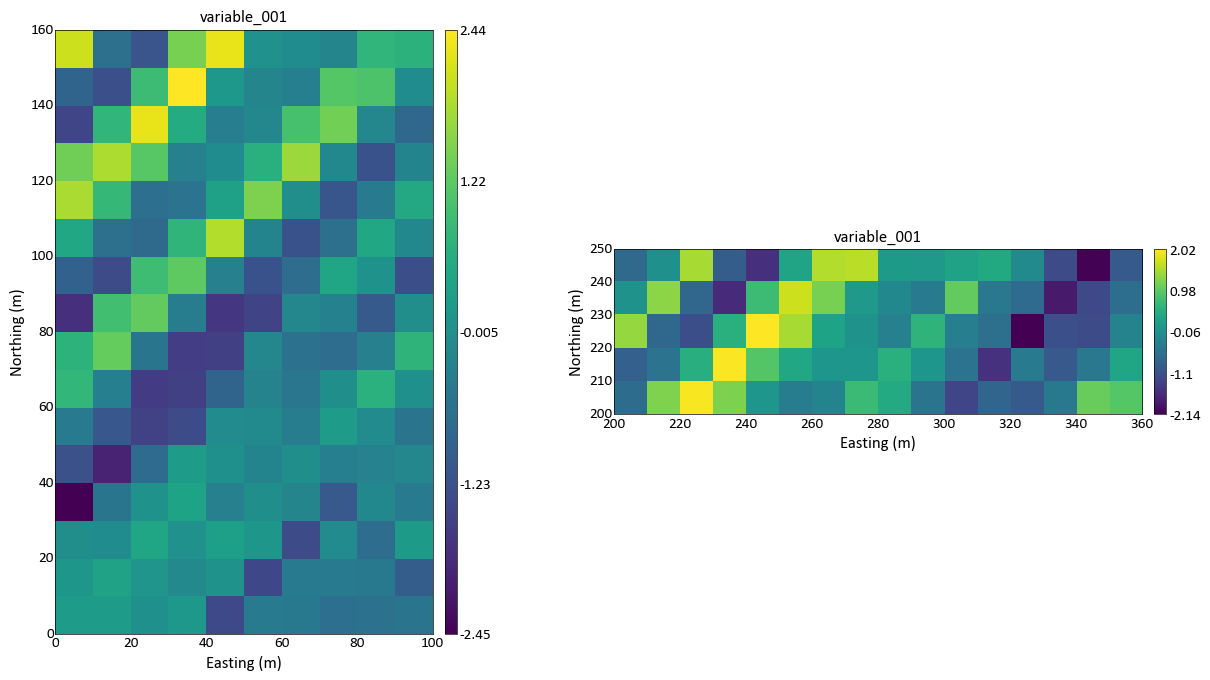

In [7]:
# visualizing simulated mining faces
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
data_file = gs.DataFile(figfolder+'\sgsim.out',griddef=grid)
data_file_mf2 = gs.DataFile(figfolder+'\sgsim_mf2.out',griddef=grid2)
gs.slice_plot(data_file, orient='xy', cmap='viridis', ax=axes[0])
gs.slice_plot(data_file_mf2, orient='xy', cmap='viridis', ax=axes[1])

In [8]:
# transforming the Gaussian simulated variable to be lognormal (this variable is metal grade)
m_ln = 0.0    #lognormal mean
sd_ln = 1.2   #lognormal std.dev.

In [9]:
# transforming the Gaussian simulated variable to be lognormal (this variable is metal grade)
data_file.data['var_ln'] = np.exp(m_ln+sd_ln*data_file.data['variable_001'])
data_file_mf2.data['var_ln'] = np.exp(m_ln+sd_ln*data_file_mf2.data['variable_001'])

<AxesSubplot:title={'center':'Histogram - Mining face B'}, xlabel='Metal grade (%)', ylabel='Frequency'>

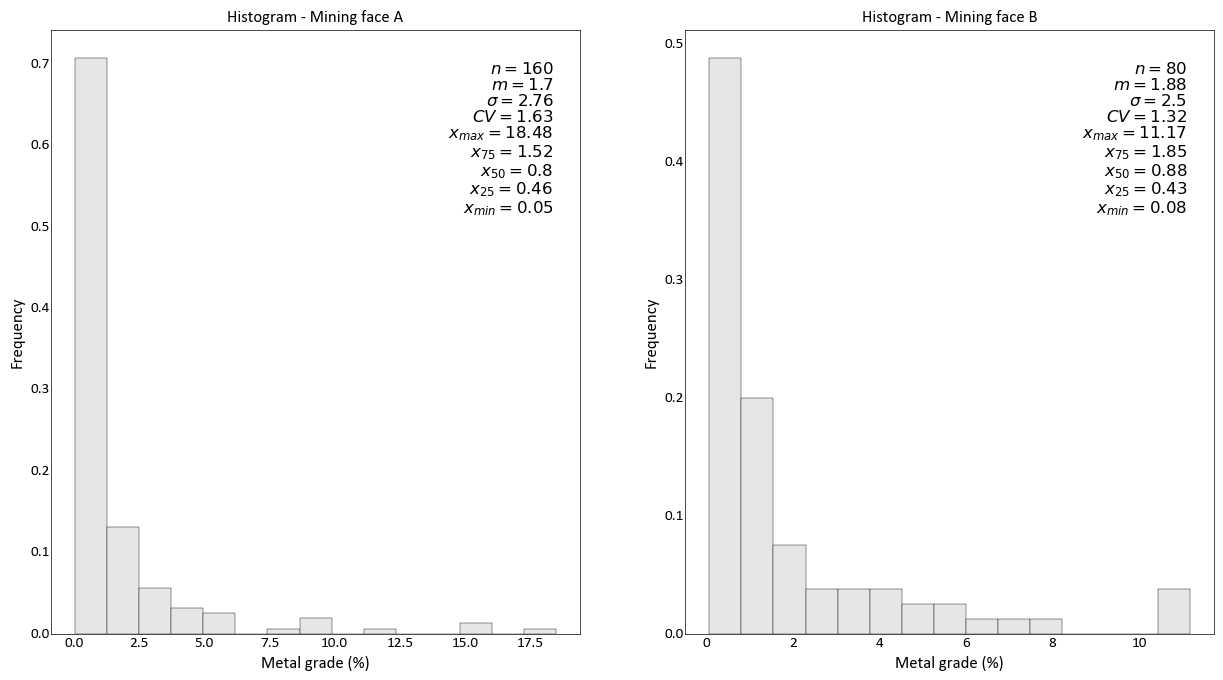

In [10]:
# visualizing metal grade histograms of each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.histogram_plot(data_file.data['var_ln'], xlabel='Metal grade (%)', ax=axes[0], title = 'Histogram - Mining face A')
gs.histogram_plot(data_file_mf2.data['var_ln'], xlabel='Metal grade (%)', ax=axes[1], title = 'Histogram - Mining face B')

In [11]:
# creating a second variable from the previous simulated one. This second variable is symetric (this variable is metal recovery).
m_2 = 75   #second variable mean (%)
sd_2 = 9.0 #second variable std.dev.(%)

In [12]:
# creating a second variable from the previous simulated one. This second variable is symetric (this variable is metal recovery).
data_file.data['var2_n'] = (m_2+sd_2*data_file.data['variable_001'])/100
data_file_mf2.data['var2_n'] = (m_2+sd_2*data_file_mf2.data['variable_001'])/100

In [13]:
#visualizing data created
data_file.data

variable_001    var_ln    var2_n
0        0.262203  1.369771  0.773598
1        0.227183  1.313401  0.770446
2        0.006386  1.007693  0.750575
3        0.159510  1.210959  0.764356
4       -1.377812  0.191403  0.625997
..            ...       ...       ...
155      0.025165  1.030659  0.752265
156     -0.065964  0.923895  0.744063
157     -0.215787  0.771866  0.730579
158      0.770770  2.521677  0.819369
159      0.697282  2.308823  0.812755

[160 rows x 3 columns]

<AxesSubplot:xlabel='var_ln', ylabel='var2_n'>

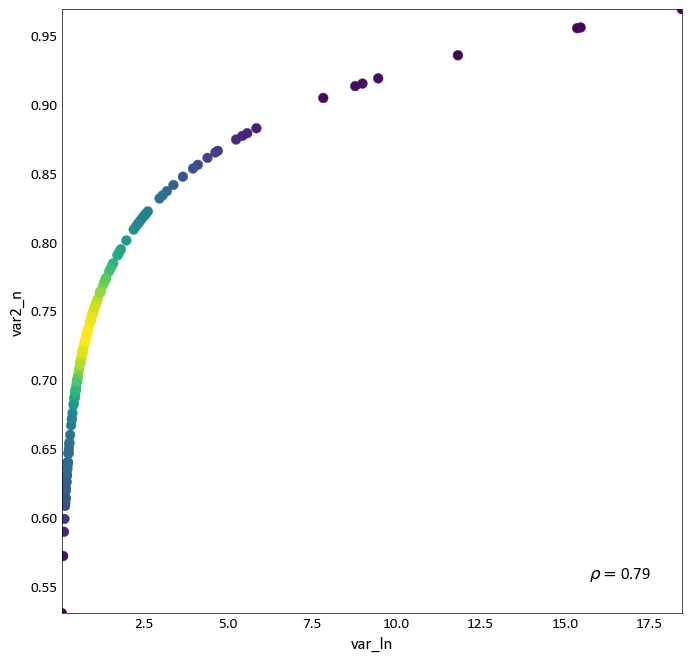

In [14]:
#visualizing variable 1 and 2 relationship
gs.scatter_plot(data_file.data['var_ln'],data_file.data['var2_n'])

<AxesSubplot:title={'center':'Histogram - Mining face B'}, xlabel='Metal recovery (%)', ylabel='Frequency'>

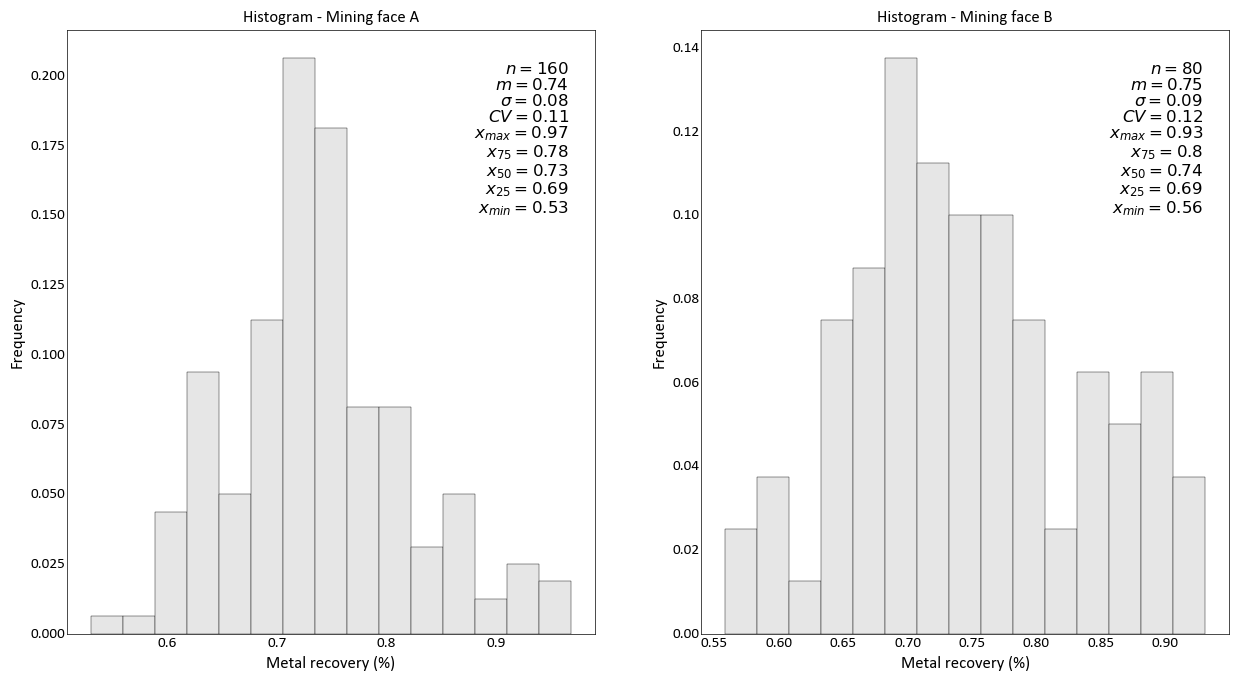

In [15]:
# visualizing metal recovery histograms of each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.histogram_plot(data_file.data['var2_n'], xlabel='Metal recovery (%)', ax=axes[0], title = 'Histogram - Mining face A')
gs.histogram_plot(data_file_mf2.data['var2_n'], xlabel='Metal recovery (%)', ax=axes[1], title = 'Histogram - Mining face B')

<AxesSubplot:xlabel='Easting (m)', ylabel='Northing (m)'>

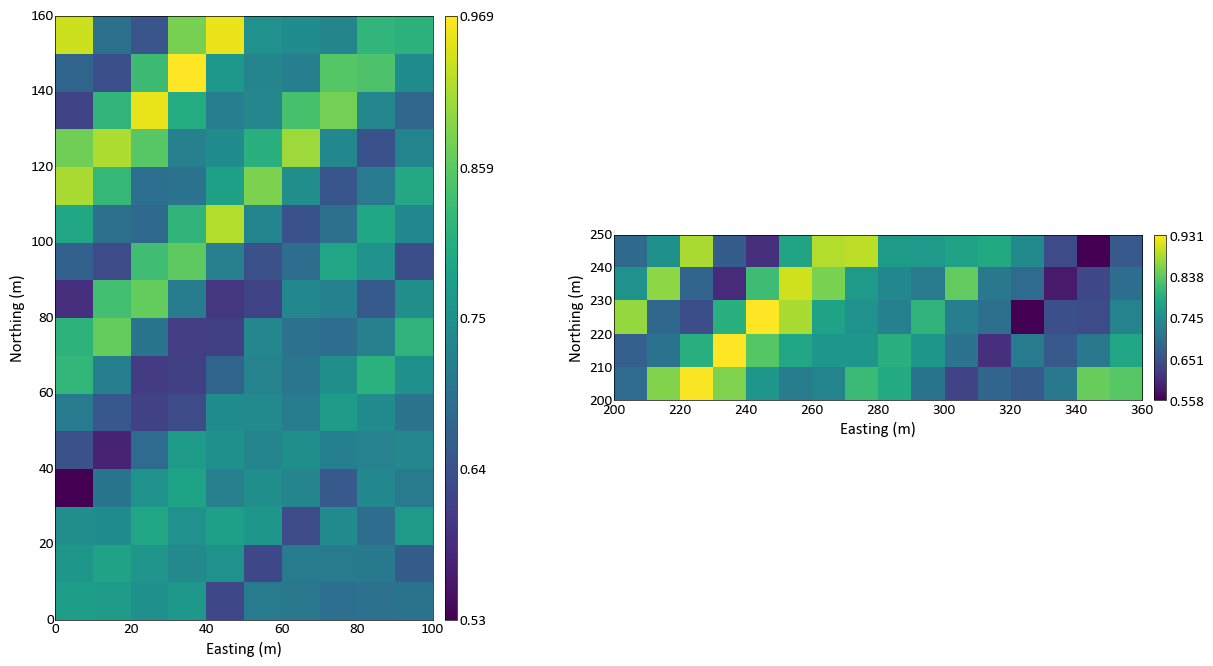

In [16]:
# visualizing metal recovery distribution in each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.slice_plot(data_file.data['var2_n'],griddef=grid, orient='xy', cmap='viridis', ax=axes[0])
gs.slice_plot(data_file_mf2.data['var2_n'],griddef=grid2, orient='xy', cmap='viridis', ax=axes[1])

In [17]:
#assigning mass units for each block and their status:
data_file.data['mass'] = 1
data_file_mf2.data['mass'] = 1

data_file.data['mined_mask'] = 0     #(0 if not mined, 1 if already mined)
data_file_mf2.data['mined_mask'] = 0 #(0 if not mined, 1 if already mined)


## adjusting the data to lists as required for blending code

In [18]:
#input data as lists: recovery data, grade data, mass data, mined_parcel_mask data
n_values=nx*ny*nz #total number of blocks in mining face 1
data_g = data_file.data['var_ln'].values.flatten().tolist() #list of grade values in mining face 1
data_m = data_file.data['mass'].values.flatten().tolist()   #list of mass values in mining face 1
data_r = data_file.data['var2_n'].values.flatten().tolist() #list of metal recovery values in mining face 1
mined_mask = data_file.data['mined_mask'].values.flatten().tolist() #list of mined blocks in mining face 1

#input data as lists: recovery data, grade data, mass data, mined_parcel_mask data
n_values2=nx2*ny2*nz2  
data_g2 = data_file_mf2.data['var_ln'].values.flatten().tolist()  
data_m2 = data_file_mf2.data['mass'].values.flatten().tolist()
data_r2 = data_file_mf2.data['var2_n'].values.flatten().tolist()
mined_mask2 = data_file_mf2.data['mined_mask'].values.flatten().tolist()

In [19]:
#allocating grid memory
pv = np.zeros((nx, ny,nz))
gradev = np.zeros((nx, ny,nz))
massv = np.zeros((nx, ny,nz))
pv_mined=np.zeros((nx, ny,nz))

#allocating grid2 memory
pv2 = np.zeros((nx2, ny2,nz2))
gradev2 = np.zeros((nx2, ny2,nz2))
massv2 = np.zeros((nx2, ny2,nz2))
pv_mined2=np.zeros((nx2, ny2,nz2))

#calculating quantity of blend units
total_p = int(n_values)
mined_p = sum(x==1 for x in mined_mask)
proh_p = sum(x==999 for x in mined_mask)
b_units = int((total_p-mined_p-proh_p)/p_units)

#calculating quantity of blend units in grid2
total_p2 = int(n_values2)
mined_p2 = sum(x==1 for x in mined_mask2)
proh_p2 = sum(x==999 for x in mined_mask2)
b_units2 = int((total_p2-mined_p2-proh_p2)/p_units2)

In [20]:
#assign values in grid according to data list

#attribute value, grade, mass and mined_mask
icol=0
for iz in range(nz):
    for iy in range(ny):
        for ix in range(nx):
            pv[ix][iy][iz], gradev[ix][iy][iz], massv[ix][iy][iz], pv_mined[ix][iy][iz] = data_r[icol], data_g[icol], data_m[icol], mined_mask[icol] 
            icol+=1      
            
#assign values in grid2 according to data list
#attribute value2, grade2, mass2 and mined_mask2
icol=0
for iz in range(nz2):
    for iy in range(ny2):
        for ix in range(nx2):
            pv2[ix][iy][iz], gradev2[ix][iy][iz], massv2[ix][iy][iz], pv_mined2[ix][iy][iz] = data_r2[icol], data_g2[icol], data_m2[icol], mined_mask2[icol] 
            icol+=1      

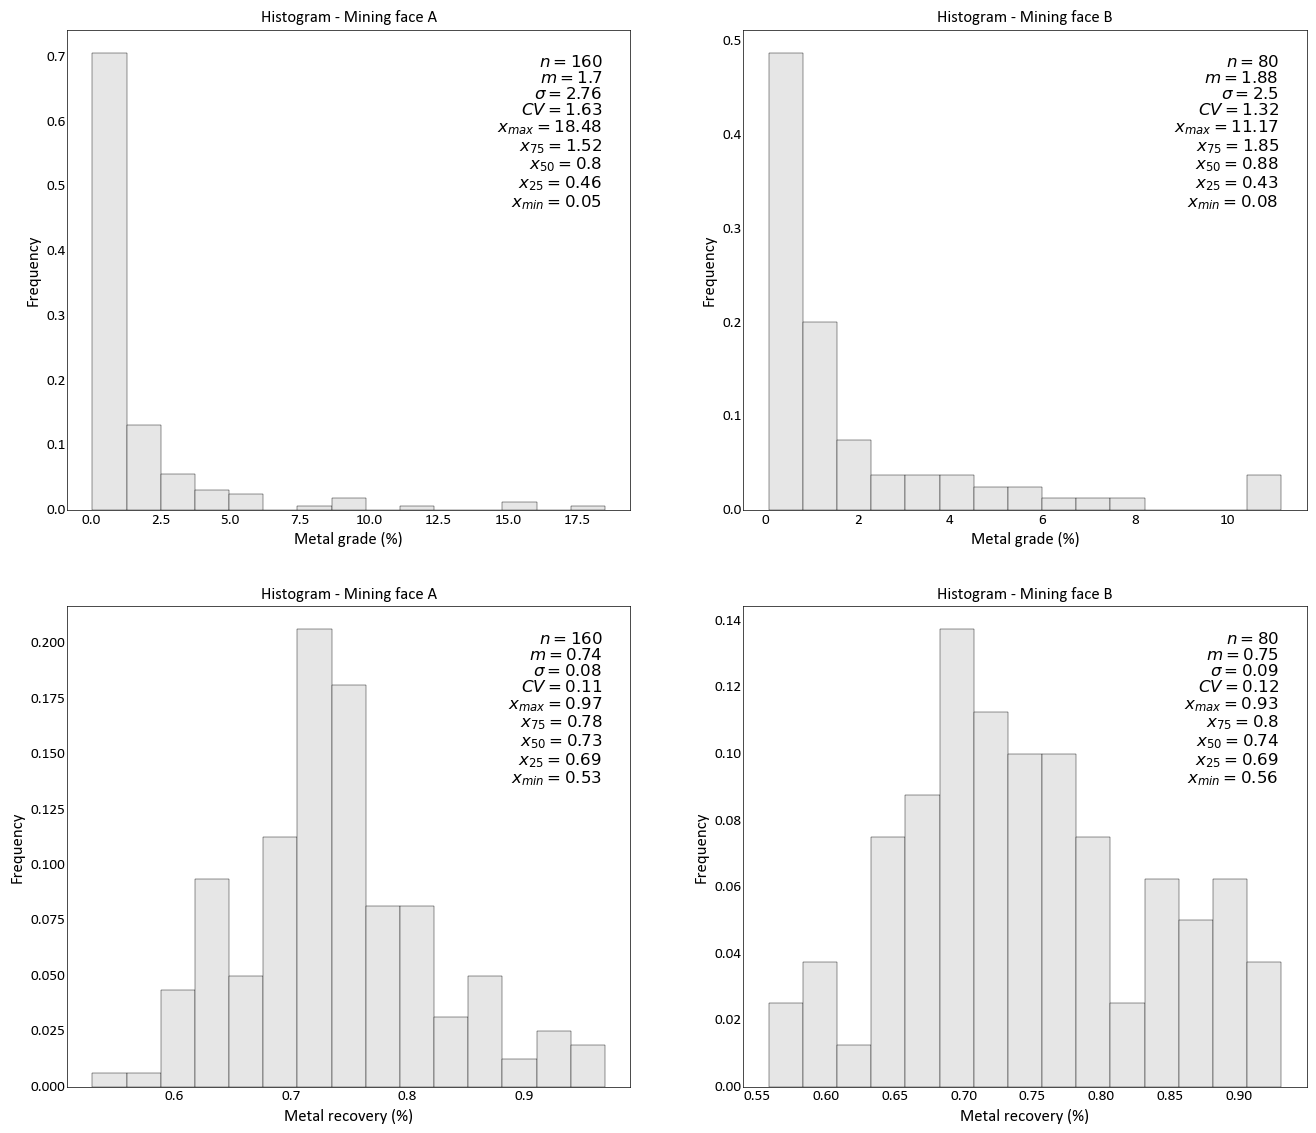

In [21]:
#visualizing attributes
fig, axes = plt.subplots(2,2, figsize=(16,14))
axes=axes.flatten()
gs.histogram_plot(data_g, xlabel='Metal grade (%)', ax=axes[0], title = 'Histogram - Mining face A')
gs.histogram_plot(data_g2, xlabel='Metal grade (%)', ax=axes[1], title = 'Histogram - Mining face B')
gs.histogram_plot(data_file.data['var2_n'], xlabel='Metal recovery (%)', ax=axes[2], title = 'Histogram - Mining face A')
gs.histogram_plot(data_file_mf2.data['var2_n'], xlabel='Metal recovery (%)', ax=axes[3], title = 'Histogram - Mining face B')
plt.savefig (figfolder+'/hist_grade.png', bbox_inches = 'tight', dpi = 300)

In [22]:
#creating another variable: recoverable metal (gr)
gr = np.multiply(data_g,data_r)
gr2 = np.multiply(data_g2,data_r2)

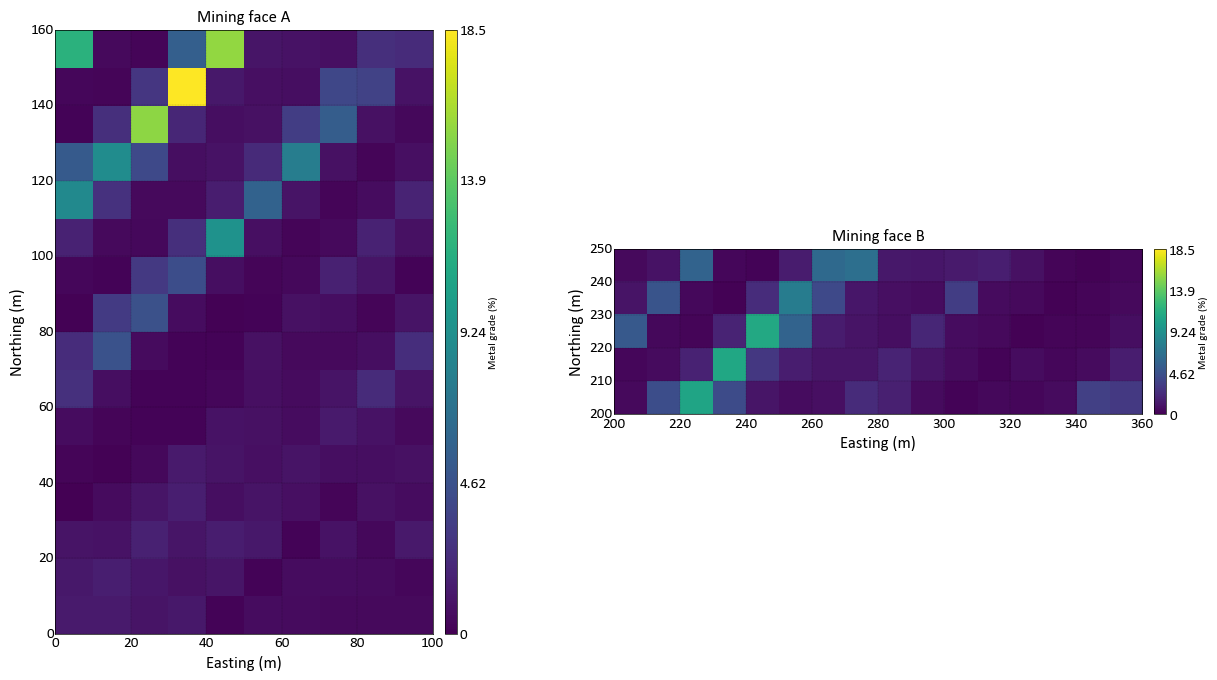

In [23]:
#visuaizing grade in each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.slice_plot(data=gradev.flatten(order='F'),griddef=grid, ax=axes[0],vlim=(0.0,max(data_g+data_g2)),grid=True, title='Mining face A', cbar_label='Metal grade (%)')
gs.slice_plot(data=gradev2.flatten(order='F'),griddef=grid2, ax=axes[1],vlim=(0.0,max(data_g+data_g2)),grid=True,title='Mining face B', cbar_label='Metal grade (%)')
plt.savefig (figfolder+'/mfaces_grade.png', bbox_inches = 'tight', dpi = 300)

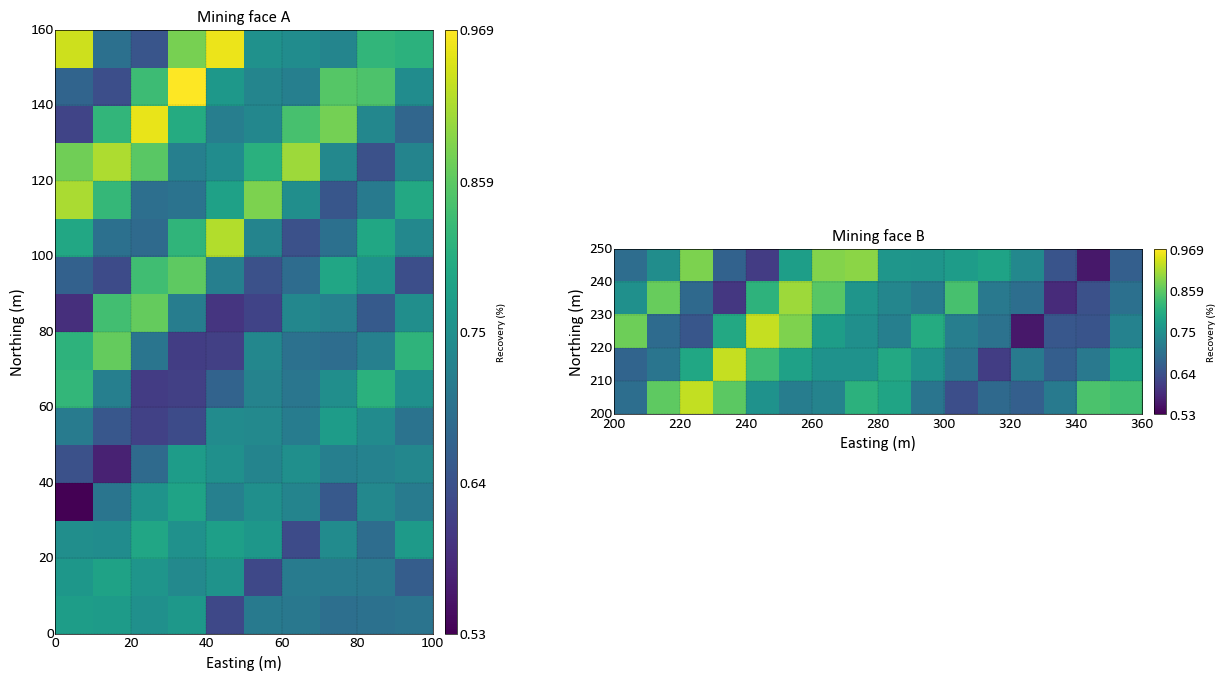

In [24]:
#visuaizing meal recovery in each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.slice_plot(data=pv.flatten(order='F'),griddef=grid, ax=axes[0],vlim=(min(data_r+data_r2),max(data_r+data_r2)),grid=True, title='Mining face A', cbar_label='Recovery (%)')
gs.slice_plot(data=pv2.flatten(order='F'),griddef=grid2, ax=axes[1],vlim=(min(data_r+data_r2),max(data_r+data_r2)),grid=True,title='Mining face B', cbar_label='Recovery (%)')
plt.savefig (figfolder+'/mfaces_rec.png', bbox_inches = 'tight', dpi = 300)

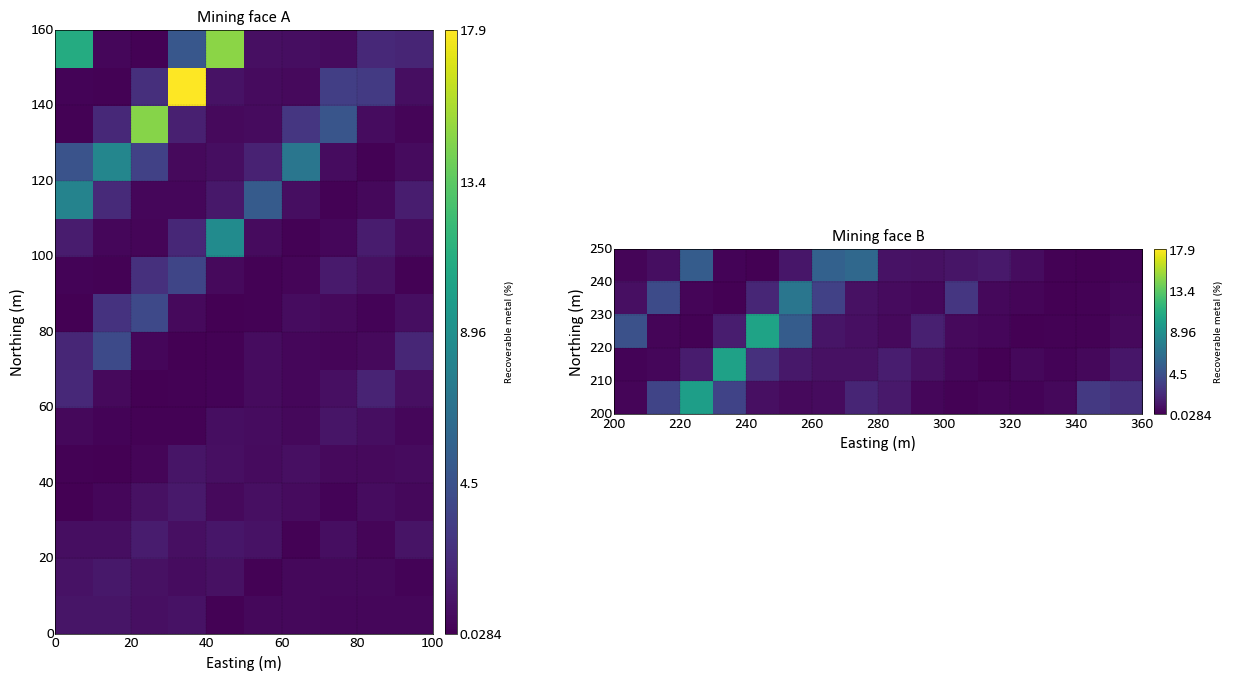

In [25]:
#visuaizing recoverable metal in each mining face
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
gs.slice_plot(data=gr.flatten(order='F'),griddef=grid,ax=axes[0], vlim=(min(gr.tolist()+gr2.tolist()),max(gr.tolist()+gr2.tolist())), grid=True, title='Mining face A',cbar_label='Recoverable metal (%)')
gs.slice_plot(data=gr2.flatten(order='F'),griddef=grid2, ax=axes[1],vlim=(min(gr.tolist()+gr2.tolist()),max(gr.tolist()+gr2.tolist())),grid=True,title='Mining face B', cbar_label='Recoverable metal (%)')
plt.savefig (figfolder+'/gr.png', bbox_inches = 'tight', dpi = 300)

In [26]:
mfA = pd.DataFrame(gr, columns = ['Recoverable_metal'])
mfB = pd.DataFrame(gr2, columns = ['Recoverable_metal'])

In [27]:
gs.write_gslib(mfA, flname=figfolder+'/mfA.dat')
gs.write_gslib(mfB, flname=figfolder+'/mfB.dat')

## Functions

In [28]:
def rec_blend_unit(r_list, m_list, g_list, w):
    '''This fuction computes and returns the effective recovery of a blending unit.
    INPUT:
    It takes as input a list of parcels recoveries, mass and grades and a value w (power function). 
    If w<1, synergistic blend
    If w=0, neutral blend
    If w>1, antagonistic blend: 
    OUTPUT:
    A value of effective recovery of that blend unit
    '''
    r_arr, m_arr, g_arr = np.array(r_list), np.array(m_list), np.array(g_list)
    r_num = np.sum(r_arr*m_arr*g_arr)
    r_den = np.sum(m_arr*g_arr)
    r_wt = r_num/r_den
    rmin=min(r_list)
    rmax=max(r_list)
    if rmax==rmin:
        return rmin
    else:
        blend_rec = rmin+(np.power((r_wt-rmin)/(rmax-rmin),w))*(rmax-rmin)
        return (blend_rec)

In [29]:
# function to get sum of distances between parcels for all blend units
def sum_dist(pv_blend, b_units):
    import math
    d_b_units=[]
    for i in range(1,b_units+1):
        x_lst=[]
        y_lst=[]
        for parcel in np.argwhere(pv_blend==i):
            x_lst.append(parcel[0])
            y_lst.append(parcel[1])
        x_lst_f = x_lst[1:] + [x_lst[0]]
        y_lst_f = y_lst[1:] + [y_lst[0]]
        x_diff = [abs(j-i) for i,j in zip(x_lst, x_lst_f)]
        y_diff = [abs(j-i) for i,j in zip(y_lst, y_lst_f)]
        d_lst = [math.sqrt(i**2 + j**2) for i,j in zip (x_diff,y_diff)]
        d_b_units.append(sum(d_lst))
    return (sum(d_b_units))

In [30]:
# objective function for simulated annealing
def gobj(b_r_list, m_unit, g_unit, dist_t, dist_penal):
    '''This function calculates the total metal recovery
    INPUT:
    b_r_list: list of blend recoveries
    m_unit: nested list with parcels mass
    g_unit: nested list with parcels grades
    dist_t: total movement distance to mine
    dist_penal: penalization factor for distance 
    '''
    tmr=[]
    for i,j,k in zip(b_r_list, m_unit, g_unit):
        #multiply the blended recovery (i) with the mass linear avg.(j), the wtd. avg. grade (k) and the number of parcels
        mr_bunit = i*mean(j)*(sum(np.multiply(k,j))/sum(j))*len(j)
        mr_bunit = round(mr_bunit, 9)
        tmr.append(mr_bunit)
    return ((sum(tmr) - (dist_penal*dist_t)),sum(tmr))

In [31]:
def dflt_sched(pv,pv_mined,b_units,p_units):
    '''This function makes a default schedule. It starts from left to right and goes in zigzag.
    INPUT:
    pv: array with parcels values
    pv_mined: array with parcels mined mask
    b_units: integer of blending units in that array
    p_units: integer of parcels that will make up each b_unit
    '''
    lst_dflt_blend_id = []
    pv_blend = np.zeros((pv.shape[0],pv.shape[1]))
    for blend_id in range(b_units):
        for parcel in range(p_units,0,-1):
            lst_dflt_blend_id.append(blend_id+1)
    for y in range(pv_blend.shape[1]):
        for x in range (pv_blend.shape[0]):
            if y % 2 == 0:
                if pv_mined[x][y]==1:
                    pv_blend[x][y]=0
                elif pv_mined[x][y]==999:
                    pv_blend[x][y]=999
                else:
                    pv_blend[x][y] = lst_dflt_blend_id.pop(0) 
            else:
                if pv_mined[pv_blend.shape[0]-x-1][y]==1:
                    pv_blend[pv_blend.shape[0]-x-1][y]=0
                elif pv_mined[pv_blend.shape[0]-x-1][y]==999:
                    pv_blend[pv_blend.shape[0]-x-1][y]=999
                else:
                    pv_blend[pv_blend.shape[0]-x-1][y] = lst_dflt_blend_id.pop(0)
    return (pv_blend)

In [32]:
def valid_swap(pv_blend):
    '''INPUT: 
    This function gets an array of parcels with their blending unit schedule.
    It tries to swaps parcels of two different blending units, subject to constraints.
    OUTPUT: array with different parcels schedule.
    '''
    import random
    swapvalid=False
    
    while swapvalid is not True:
        pv_blend_mod = np.copy(pv_blend)
        p1valid=False
        p2valid=False

        while p1valid is not True:
            #choose parcel1 at random
            x1 = np.random.randint(len(pv_blend_mod))
            y1 = np.random.randint(len(pv_blend_mod[x1]))

            #check p1 is valid. If not, continue p1valid while loop
            if pv_blend_mod[x1][y1]==0 or pv_blend_mod[x1][y1]==999 : #do not select value 0 (already mined) or 9999 (prohibit to mine)
                continue

            #get p1 value
            p1old = pv_blend_mod[x1][y1].copy()
            p1valid=True

        while p2valid is not True:
            #choose parcel2 at random
            x2 = np.random.randint(len(pv_blend_mod))
            y2 = np.random.randint(len(pv_blend_mod[x2]))

            #check p2 is valid. If not, continue p2valid while loop
            if pv_blend_mod[x2][y2]==0 or pv_blend_mod[x2][y2]==999 : #do not select value 0 (already mined) or 9999 (prohibit to mine)
                continue
            if pv_blend_mod[x2][y2]==p1old: #do not select if they are the same blend_unit
                continue

            #get p2 value    
            p2old = pv_blend_mod[x2][y2].copy()
            p2valid = True

        # swap p1 and p2
        pv_blend_mod[x1][y1], pv_blend_mod[x2][y2] = p2old, p1old
        
        #get neighbours
        n_above1, n_ne1, n_right1, n_se1, n_below1, n_sw1, n_left1, n_nw1 = get_neigh(pv_blend_mod, x1, y1)
        n_above2, n_ne2, n_right2, n_se2, n_below2, n_sw2, n_left2, n_nw2 = get_neigh(pv_blend_mod, x2, y2)
        
        # check if the joint p1 and p2 are valid. If not, restart swapvalid while loop
        if (p1old >= n_below2 and p1old >= n_sw2 and p1old >= n_se2) and ( #p1 geq than below and 45 degrees
            p1old <=n_above2 and p1old <=n_nw2 and p1old <=n_ne2) and (    #p1 leq than above and 45 degrees
            p2old>=n_below1 and p2old >= n_sw1 and p2old >= n_se1) and (   #p2 geq than below and 45 degrees
            p2old <=n_above1 and p2old <=n_nw1 and p2old <=n_ne1
           ):         #p2 leq than above and 45 degrees
            swapvalid=True    
    
    return (pv_blend_mod)

In [33]:
def get_neigh(pv_blend, x, y):
    '''This function inputs are an array of blend_id values and a index x,y of a parcel coordinate.
    It returns the blend_id values of the neighbours in the order: north, ne, east, se, south, sw, west, nw.
    '''
    
    #right, above, left, below
    if x<len(pv_blend)-1:
        n_right = pv_blend[x+1][y]
    else:
        n_right = 9999
    if y<len(pv_blend[x])-1:
        n_above = pv_blend[x][y+1]
    else:
        n_above = 9999
    if x>0:
        n_left = pv_blend[x-1][y]
    else:
        n_left = 9999
    if y>0:
        n_below = pv_blend[x][y-1]
    else:
        n_below = 0     
    
    #diagonals neighbors (ne,nw,sw,se)
    if x<len(pv_blend)-1 and y<len(pv_blend[x])-1:
        n_ne = pv_blend[x+1][y+1]
    else:
        n_ne = 9999
    if x>0 and y<len(pv_blend[x])-1:
        n_nw = pv_blend[x-1][y+1]
    else:
        n_nw = 9999
    if x>0 and y>0:
        n_sw = pv_blend[x-1][y-1]
    else:
        n_sw = 0
    if x<len(pv_blend)-1 and y>0:
        n_se = pv_blend[x+1][y-1]
    else:
        n_se = 0
        
    return (n_above, n_ne, n_right, n_se, n_below, n_sw, n_left, n_nw)

In [127]:
def sim_annealing_2f(pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
                      pv2, pv_mined2, gradev2, massv2, p_units2, b_units2, #miningface2
                     dist_penal,                                           #penalty for shovel movement (0-nothing; 0.01 - better option if want parcels together)
                      w,                                                 #processing_par
                      n_iterations, temp):                               #sim_annealing_par
    '''
    This function uses simulated annealing to provide the better schedule considering 2 mining faces and blending.
    INPUT:
    pv = 3d array with parcels recovery or any other attribute values
    pv_mined = 3d array with 0 (not mined) or 1 (already mined) values
    gradev, massv = 3d array with parcels grade and mass values
    p_units = integer (how many parcels in a blending unit)
    b_units = integer (how many blending units)
    dist_penal = penalty factor for shovel movement (0-nothing; 0.01 - better option if want parcels together)
    w = power factor used in the nonlinear function to estimate blending attribute
    n_interation = iteration used in simulating annealing
    temp = initial temperature of annealing
    OUTPUT:
    
    '''
    import random
    import math
    
    # creating nested lists for the blend_units resulted from the 2 faces
    att_unit, m_unit, g_unit = [],[],[]
    
    #creating list of average blending attribute
    att_blend_units=[]
    
    # check all conditions that may crash the algorithm
    # check if face1 is feasible
    if np.count_nonzero(pv_mined==0) != (p_units*b_units):
        raise ValueError('number of parcels not mined in face1 are not multiple of p_units in blend')
        
     # check if face2 is feasible
    if np.count_nonzero(pv_mined2==0) != (p_units2*b_units2):
        raise ValueError('number of parcels not mined in face2 are not multiple of p_units2 in blend')
        
    #check if number of blending units in the mining faces match
    if  b_units != b_units2:
        raise ValueError('mining faces should have the same quantity of blending units to be mined') 
        
    # evaluate initial solution for simulated annealing
    # calling function defauld sched
    pv_blend = dflt_sched(pv,pv_mined,b_units,p_units)
    pv_blend2 = dflt_sched(pv2,pv_mined2,b_units2,p_units2)
    
    #calculating effective recovery per blending unit 
    for j,h in zip(range(1,b_units+1),range(1,b_units2+1)):
        #list with parcels from face1
        att_lst_unit = pv[pv_blend==j].flatten().tolist()
        m_lst_unit = massv[pv_blend==j].flatten().tolist()
        g_lst_unit = gradev[pv_blend==j].flatten().tolist()
        #list with parcels from face2
        att_lst_unit2 = pv2[pv_blend2==h].flatten().tolist()
        m_lst_unit2 = massv2[pv_blend2==h].flatten().tolist()
        g_lst_unit2 = gradev2[pv_blend2==h].flatten().tolist()
        #join list face1 and face2
        att_lst_unit.extend(att_lst_unit2)
        m_lst_unit.extend(m_lst_unit2)
        g_lst_unit.extend(g_lst_unit2)
        #impute values in nested lists for the blend_units resulted from the 2 faces
        att_unit.append(att_lst_unit)
        m_unit.append(m_lst_unit)
        g_unit.append(g_lst_unit)
        
        #calculate effective recovery for each blend unit and append in a list
        att_blend_units.append(rec_blend_unit(att_lst_unit,m_lst_unit,g_lst_unit,w))
        
    # evaluate initial solution
    dist = sum_dist(pv_blend, b_units)
    dist2 = sum_dist(pv_blend2, b_units2)
    dist_t = dist + dist2
    blendset_eval, tmr = gobj(att_blend_units, m_unit, g_unit, dist_t, dist_penal)
    
    # setting this initial solution as current working solution and best
    curr_att_unit, curr_g_unit, curr_m_unit, curr_blend, curr_blend2, curr_blendset_eval, curr_tmr = att_unit, g_unit, m_unit, pv_blend, pv_blend2, blendset_eval, tmr
    best_att_unit, best_g_unit, best_m_unit, best_blend, best_blend2, best_blendset_eval, best_tmr  = att_unit, g_unit, m_unit, pv_blend, pv_blend2, blendset_eval, tmr
    
    #code to convergence analysis
    if n_iterations==0:
        itera_values = [0]
    else:
        itera_values = list(range(0, n_iterations+1, int((n_iterations)/10)))
    itera_values_result=[curr_tmr]
    
    #iterating 
    for it in range(1, n_iterations+1):
        
        #reset every variable
        att_blend_units.clear() #reset to 0
        att_unit, m_unit, g_unit = [], [], []
        
        #random choose a face to swap
        if np.random.randint(2, size=1)==0: #probability of 0 (1-100% (swap just face1), 2-50% (face 1 and face 2 50%))
            pv_blend = valid_swap(curr_blend)
            pv_blend2 = curr_blend2
        else:
            pv_blend = curr_blend
            pv_blend2 = valid_swap(curr_blend2)
            
        #calculating effective recovery per blending unit 
        for j,h in zip(range(1,b_units+1),range(1,b_units2+1)):
            #list with parcels from face1
            att_lst_unit = pv[pv_blend==j].flatten().tolist()
            m_lst_unit = massv[pv_blend==j].flatten().tolist()
            g_lst_unit = gradev[pv_blend==j].flatten().tolist()
            #list with parcels from face2
            att_lst_unit2 = pv2[pv_blend2==h].flatten().tolist()
            m_lst_unit2 = massv2[pv_blend2==h].flatten().tolist()
            g_lst_unit2 = gradev2[pv_blend2==h].flatten().tolist()
            #join list face1 and face2
            att_lst_unit.extend(att_lst_unit2)
            m_lst_unit.extend(m_lst_unit2)
            g_lst_unit.extend(g_lst_unit2)
            #impute values in nested lists for the blend_units resulted from the 2 faces
            att_unit.append(att_lst_unit)
            m_unit.append(m_lst_unit)
            g_unit.append(g_lst_unit)

            #calculate effective recovery for each blend unit and append in a list
            att_blend_units.append(rec_blend_unit(att_lst_unit,m_lst_unit,g_lst_unit,w))

        # evaluate candidate solution
        dist = sum_dist(pv_blend, b_units)
        dist2 = sum_dist(pv_blend2, b_units2)
        dist_t = dist + dist2
        blendset_eval, tmr = gobj(att_blend_units, m_unit, g_unit, dist_t, dist_penal)
        
        # check for new best solution
        if blendset_eval < best_blendset_eval:
            print('iteration {} found worse value: {}.'.format(it,best_blendset_eval))
        if blendset_eval == best_blendset_eval:
            print('iteration {} found equal value: {}.'.format(it,best_blendset_eval))
        if blendset_eval > best_blendset_eval:
            # store new best point
            best_att_unit, best_g_unit, best_m_unit, best_blend, best_blend2, best_blendset_eval, best_tmr = att_unit, g_unit, m_unit, pv_blend, pv_blend2 , blendset_eval, tmr 
            # report progress
            print('iteration {} found better value: {}'.format(it,blendset_eval))
            
        # difference between candidate and current point evaluation
        diff = -(blendset_eval - curr_blendset_eval)
        # calculate temperature for current iteration
        t = temp / float(it)
        # calculate metropolis acceptance criterion
        metropolis = math.exp(-diff / t)
        # check if we should keep the new point
        if np.random.rand() < metropolis and diff > 0:
            print('iteration {}, perturbing to get out of local maxima'.format(it))
            curr_att_unit, curr_g_unit, curr_m_unit, curr_blend, curr_blend2, curr_blendset_eval, curr_tmr = att_unit, g_unit, m_unit, pv_blend, pv_blend2, blendset_eval, tmr
        if diff < 0:
            # store the new current point
            curr_att_unit, curr_g_unit, curr_m_unit, curr_blend, curr_blend2, curr_blendset_eval, curr_tmr = att_unit, g_unit, m_unit, pv_blend, pv_blend2, blendset_eval, tmr

        #code to convergence analysis
        if it in itera_values:
            itera_values_result.append(best_tmr)    
        
    return (best_att_unit, best_g_unit, best_m_unit, best_blend, best_blend2, best_tmr, itera_values_result)

## Results

### considering that metal recovery averages linearly

In [177]:
dflt_att_unit, dflt_g_unit, dflt_m_unit, dflt_blend, dflt_blend2, dflt_tmr, conv_lst_tmr = sim_annealing_2f(
    pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
    pv2, pv_mined2, gradev2, massv2, p_units2, b_units2,  #miningface2
    dist_penal=0.000,                                          #penalty for shovel movement
    w=1,                                                 #processing_par
    n_iterations=0, temp=5)

In [178]:
dflt_tmr #total metal recovered (units of mass)

356.637659352

### considering that metal recovery has synergistic blending (w=0.8)

#### default schedule (zig-zag)

In [179]:
dflt_att_unit, dflt_g_unit, dflt_m_unit, dflt_blend, dflt_blend2, dflt_tmr, conv_lst_tmr = sim_annealing_2f(
    pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
    pv2, pv_mined2, gradev2, massv2, p_units2, b_units2,  #miningface2
    dist_penal=0.000,                                          #penalty for shovel movement
    w=0.8,                                                 #processing_par
    n_iterations=0, temp=5)

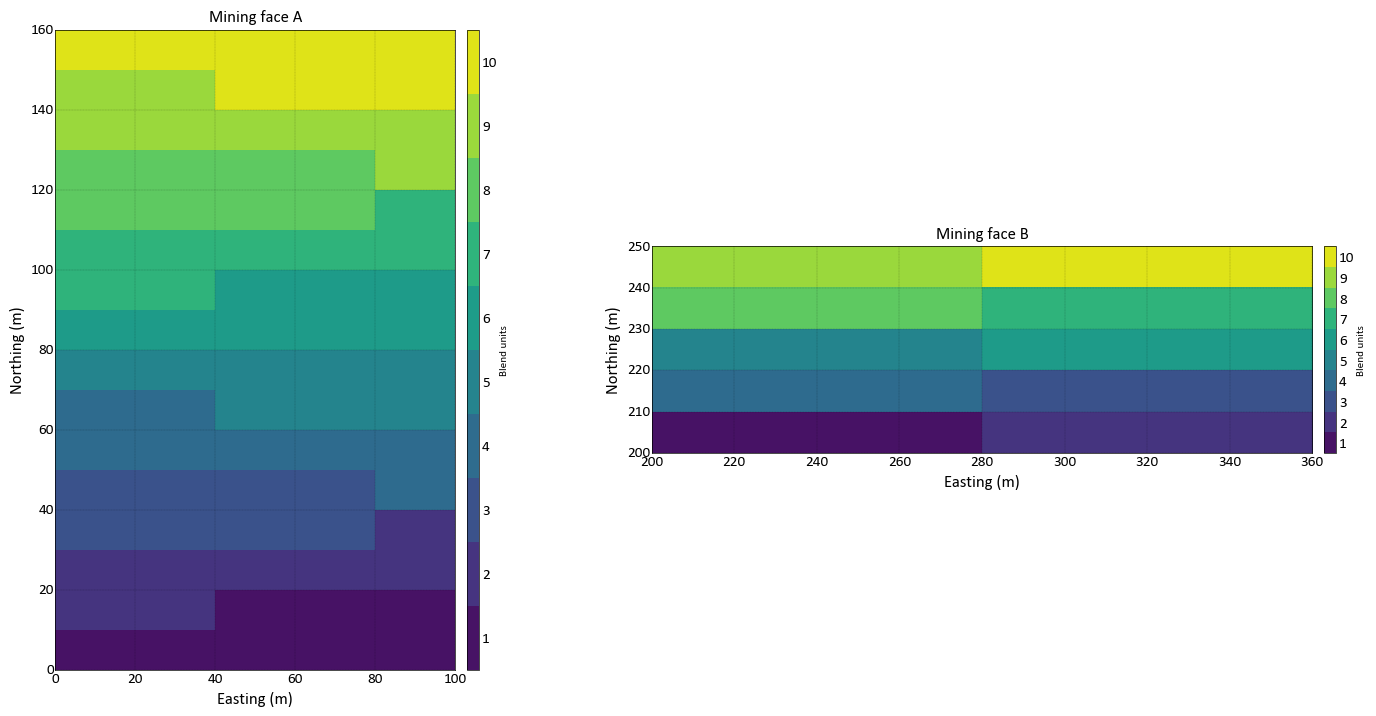

In [180]:
#visualizing default schedule
#if few units, use .astype(int)
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
_=gs.slice_plot(data=dflt_blend.astype(int).flatten(order='F'),griddef=grid,catdata=True, ax=axes[0], title='Mining face A', grid=True,cmap='viridis',cbar_label='Blend units')
_=gs.slice_plot(data=dflt_blend2.astype(int).flatten(order='F'),griddef=grid2,catdata=True, ax=axes[1],title='Mining face B',grid=True,cmap='viridis',cbar_label='Blend units')
plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 1.05, top = 0.9, wspace = 0.1, hspace = 0.1)
plt.savefig (figfolder + '/figure_dflt.png', bbox_inches = 'tight', dpi = 300)

In [181]:
dflt_tmr #total metal recovered (units of mass)

362.509752909

In [182]:
dflt_tmr/240 #total metal recovered (units of mass per block)

1.5104573037875

In [183]:
# calculating recoverable metal (%)
tmr_list = np.multiply(dflt_att_unit,dflt_g_unit)
tmr_list = tmr_list.tolist()

Text(0, 0.5, 'Recoverable metal (%)')

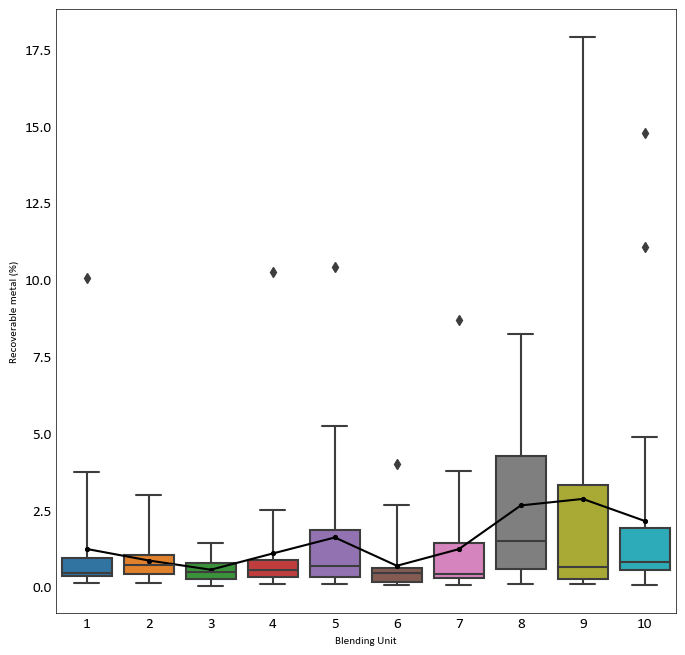

In [184]:
#visualizing box-plots of each blending unit
b_means = [np.mean(i) for i in tmr_list]
ax=sns.boxplot(data=tmr_list,whis=5)
ax=sns.lineplot(data=b_means,color='black',marker='o',markerfacecolor="black", markeredgecolor="black",markersize='3')
ax.set_xlabel('Blending Unit')
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
ax.set_ylabel('Recoverable metal (%)')

#### optimized schedule

In [185]:
best_att_unit, best_g_unit, best_m_unit, best_blend, best_blend2, best_tmr, conv_lst_tmr = sim_annealing_2f(
    pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
    pv2, pv_mined2, gradev2, massv2, p_units2, b_units2,  #miningface2
    dist_penal=0.00,                                          #penalty for shovel movement
    w=0.8,                                                 #processing_par
    n_iterations=20000, temp=100)

iteration 1 found worse value: 362.509752909.
iteration 1, perturbing to get out of local maxima
iteration 2 found worse value: 362.509752909.
iteration 2, perturbing to get out of local maxima
iteration 3 found worse value: 362.509752909.
iteration 4 found worse value: 362.509752909.
iteration 5 found worse value: 362.509752909.
iteration 5, perturbing to get out of local maxima
iteration 6 found worse value: 362.509752909.
iteration 6, perturbing to get out of local maxima
iteration 7 found worse value: 362.509752909.
iteration 8 found worse value: 362.509752909.
iteration 8, perturbing to get out of local maxima
iteration 9 found worse value: 362.509752909.
iteration 9, perturbing to get out of local maxima
iteration 10 found worse value: 362.509752909.
iteration 11 found worse value: 362.509752909.
iteration 11, perturbing to get out of local maxima
iteration 12 found worse value: 362.509752909.
iteration 12, perturbing to get out of local maxima
iteration 13 found worse value: 362

iteration 169 found worse value: 363.115943084.
iteration 170 found worse value: 363.115943084.
iteration 170, perturbing to get out of local maxima
iteration 171 found worse value: 363.115943084.
iteration 172 found worse value: 363.115943084.
iteration 172, perturbing to get out of local maxima
iteration 173 found worse value: 363.115943084.
iteration 174 found worse value: 363.115943084.
iteration 175 found worse value: 363.115943084.
iteration 176 found worse value: 363.115943084.
iteration 177 found worse value: 363.115943084.
iteration 177, perturbing to get out of local maxima
iteration 178 found worse value: 363.115943084.
iteration 178, perturbing to get out of local maxima
iteration 179 found worse value: 363.115943084.
iteration 179, perturbing to get out of local maxima
iteration 180 found worse value: 363.115943084.
iteration 181 found worse value: 363.115943084.
iteration 182 found worse value: 363.115943084.
iteration 183 found worse value: 363.115943084.
iteration 184 f

iteration 285 found worse value: 363.115943084.
iteration 285, perturbing to get out of local maxima
iteration 286 found worse value: 363.115943084.
iteration 286, perturbing to get out of local maxima
iteration 287 found worse value: 363.115943084.
iteration 288 found worse value: 363.115943084.
iteration 289 found worse value: 363.115943084.
iteration 290 found worse value: 363.115943084.
iteration 291 found worse value: 363.115943084.
iteration 292 found worse value: 363.115943084.
iteration 293 found worse value: 363.115943084.
iteration 293, perturbing to get out of local maxima
iteration 294 found worse value: 363.115943084.
iteration 294, perturbing to get out of local maxima
iteration 295 found worse value: 363.115943084.
iteration 295, perturbing to get out of local maxima
iteration 296 found worse value: 363.115943084.
iteration 297 found worse value: 363.115943084.
iteration 298 found worse value: 363.115943084.
iteration 298, perturbing to get out of local maxima
iteration 

iteration 415 found worse value: 363.115943084.
iteration 416 found worse value: 363.115943084.
iteration 417 found worse value: 363.115943084.
iteration 418 found worse value: 363.115943084.
iteration 418, perturbing to get out of local maxima
iteration 419 found worse value: 363.115943084.
iteration 419, perturbing to get out of local maxima
iteration 420 found worse value: 363.115943084.
iteration 421 found worse value: 363.115943084.
iteration 422 found worse value: 363.115943084.
iteration 422, perturbing to get out of local maxima
iteration 423 found worse value: 363.115943084.
iteration 423, perturbing to get out of local maxima
iteration 424 found worse value: 363.115943084.
iteration 424, perturbing to get out of local maxima
iteration 425 found worse value: 363.115943084.
iteration 425, perturbing to get out of local maxima
iteration 426 found worse value: 363.115943084.
iteration 427 found worse value: 363.115943084.
iteration 427, perturbing to get out of local maxima
itera

iteration 539 found worse value: 363.115943084.
iteration 540 found worse value: 363.115943084.
iteration 540, perturbing to get out of local maxima
iteration 541 found worse value: 363.115943084.
iteration 541, perturbing to get out of local maxima
iteration 542 found worse value: 363.115943084.
iteration 543 found worse value: 363.115943084.
iteration 544 found worse value: 363.115943084.
iteration 545 found worse value: 363.115943084.
iteration 546 found worse value: 363.115943084.
iteration 547 found worse value: 363.115943084.
iteration 548 found worse value: 363.115943084.
iteration 549 found worse value: 363.115943084.
iteration 549, perturbing to get out of local maxima
iteration 550 found worse value: 363.115943084.
iteration 550, perturbing to get out of local maxima
iteration 551 found worse value: 363.115943084.
iteration 552 found worse value: 363.115943084.
iteration 552, perturbing to get out of local maxima
iteration 553 found worse value: 363.115943084.
iteration 553, 

iteration 652 found worse value: 363.115943084.
iteration 653 found worse value: 363.115943084.
iteration 654 found worse value: 363.115943084.
iteration 655 found worse value: 363.115943084.
iteration 656 found worse value: 363.115943084.
iteration 657 found worse value: 363.115943084.
iteration 657, perturbing to get out of local maxima
iteration 658 found worse value: 363.115943084.
iteration 658, perturbing to get out of local maxima
iteration 659 found worse value: 363.115943084.
iteration 660 found worse value: 363.115943084.
iteration 661 found worse value: 363.115943084.
iteration 661, perturbing to get out of local maxima
iteration 662 found worse value: 363.115943084.
iteration 663 found worse value: 363.115943084.
iteration 663, perturbing to get out of local maxima
iteration 664 found worse value: 363.115943084.
iteration 665 found worse value: 363.115943084.
iteration 665, perturbing to get out of local maxima
iteration 666 found worse value: 363.115943084.
iteration 666, 

iteration 873 found worse value: 363.115943084.
iteration 873, perturbing to get out of local maxima
iteration 874 found worse value: 363.115943084.
iteration 874, perturbing to get out of local maxima
iteration 875 found worse value: 363.115943084.
iteration 876 found worse value: 363.115943084.
iteration 877 found worse value: 363.115943084.
iteration 877, perturbing to get out of local maxima
iteration 878 found worse value: 363.115943084.
iteration 879 found worse value: 363.115943084.
iteration 879, perturbing to get out of local maxima
iteration 880 found better value: 363.125567924
iteration 881 found better value: 363.127437339
iteration 882 found worse value: 363.127437339.
iteration 882, perturbing to get out of local maxima
iteration 883 found worse value: 363.127437339.
iteration 883, perturbing to get out of local maxima
iteration 884 found worse value: 363.127437339.
iteration 884, perturbing to get out of local maxima
iteration 885 found worse value: 363.127437339.
itera

iteration 1038 found worse value: 363.177695021.
iteration 1039 found worse value: 363.177695021.
iteration 1039, perturbing to get out of local maxima
iteration 1040 found worse value: 363.177695021.
iteration 1041 found worse value: 363.177695021.
iteration 1042 found worse value: 363.177695021.
iteration 1043 found worse value: 363.177695021.
iteration 1044 found worse value: 363.177695021.
iteration 1044, perturbing to get out of local maxima
iteration 1045 found worse value: 363.177695021.
iteration 1045, perturbing to get out of local maxima
iteration 1046 found worse value: 363.177695021.
iteration 1046, perturbing to get out of local maxima
iteration 1047 found worse value: 363.177695021.
iteration 1048 found worse value: 363.177695021.
iteration 1049 found worse value: 363.177695021.
iteration 1050 found worse value: 363.177695021.
iteration 1051 found worse value: 363.177695021.
iteration 1051, perturbing to get out of local maxima
iteration 1052 found worse value: 363.177695

iteration 1249 found worse value: 363.287945278.
iteration 1249, perturbing to get out of local maxima
iteration 1250 found worse value: 363.287945278.
iteration 1251 found worse value: 363.287945278.
iteration 1251, perturbing to get out of local maxima
iteration 1252 found better value: 363.29081544499996
iteration 1253 found worse value: 363.29081544499996.
iteration 1253, perturbing to get out of local maxima
iteration 1254 found worse value: 363.29081544499996.
iteration 1255 found worse value: 363.29081544499996.
iteration 1255, perturbing to get out of local maxima
iteration 1256 found worse value: 363.29081544499996.
iteration 1256, perturbing to get out of local maxima
iteration 1257 found worse value: 363.29081544499996.
iteration 1257, perturbing to get out of local maxima
iteration 1258 found worse value: 363.29081544499996.
iteration 1258, perturbing to get out of local maxima
iteration 1259 found worse value: 363.29081544499996.
iteration 1260 found worse value: 363.29081

iteration 1433 found worse value: 363.29081544499996.
iteration 1433, perturbing to get out of local maxima
iteration 1434 found worse value: 363.29081544499996.
iteration 1434, perturbing to get out of local maxima
iteration 1435 found worse value: 363.29081544499996.
iteration 1436 found worse value: 363.29081544499996.
iteration 1436, perturbing to get out of local maxima
iteration 1437 found worse value: 363.29081544499996.
iteration 1438 found worse value: 363.29081544499996.
iteration 1438, perturbing to get out of local maxima
iteration 1439 found worse value: 363.29081544499996.
iteration 1440 found worse value: 363.29081544499996.
iteration 1441 found worse value: 363.29081544499996.
iteration 1442 found worse value: 363.29081544499996.
iteration 1442, perturbing to get out of local maxima
iteration 1443 found worse value: 363.29081544499996.
iteration 1444 found worse value: 363.29081544499996.
iteration 1444, perturbing to get out of local maxima
iteration 1445 found worse v

iteration 1637 found worse value: 363.29081544499996.
iteration 1638 found worse value: 363.29081544499996.
iteration 1639 found worse value: 363.29081544499996.
iteration 1640 found worse value: 363.29081544499996.
iteration 1641 found worse value: 363.29081544499996.
iteration 1641, perturbing to get out of local maxima
iteration 1642 found worse value: 363.29081544499996.
iteration 1642, perturbing to get out of local maxima
iteration 1643 found worse value: 363.29081544499996.
iteration 1643, perturbing to get out of local maxima
iteration 1644 found worse value: 363.29081544499996.
iteration 1645 found worse value: 363.29081544499996.
iteration 1645, perturbing to get out of local maxima
iteration 1646 found worse value: 363.29081544499996.
iteration 1646, perturbing to get out of local maxima
iteration 1647 found worse value: 363.29081544499996.
iteration 1647, perturbing to get out of local maxima
iteration 1648 found worse value: 363.29081544499996.
iteration 1649 found worse v

iteration 1819 found worse value: 363.335571731.
iteration 1819, perturbing to get out of local maxima
iteration 1820 found worse value: 363.335571731.
iteration 1821 found worse value: 363.335571731.
iteration 1822 found worse value: 363.335571731.
iteration 1822, perturbing to get out of local maxima
iteration 1823 found worse value: 363.335571731.
iteration 1824 found worse value: 363.335571731.
iteration 1825 found worse value: 363.335571731.
iteration 1825, perturbing to get out of local maxima
iteration 1826 found worse value: 363.335571731.
iteration 1826, perturbing to get out of local maxima
iteration 1827 found worse value: 363.335571731.
iteration 1827, perturbing to get out of local maxima
iteration 1828 found worse value: 363.335571731.
iteration 1829 found worse value: 363.335571731.
iteration 1830 found worse value: 363.335571731.
iteration 1830, perturbing to get out of local maxima
iteration 1831 found worse value: 363.335571731.
iteration 1832 found worse value: 363.3

iteration 2001 found worse value: 363.335571731.
iteration 2002 found worse value: 363.335571731.
iteration 2002, perturbing to get out of local maxima
iteration 2003 found worse value: 363.335571731.
iteration 2004 found worse value: 363.335571731.
iteration 2004, perturbing to get out of local maxima
iteration 2005 found worse value: 363.335571731.
iteration 2006 found worse value: 363.335571731.
iteration 2006, perturbing to get out of local maxima
iteration 2007 found worse value: 363.335571731.
iteration 2008 found worse value: 363.335571731.
iteration 2008, perturbing to get out of local maxima
iteration 2009 found worse value: 363.335571731.
iteration 2010 found worse value: 363.335571731.
iteration 2011 found worse value: 363.335571731.
iteration 2012 found worse value: 363.335571731.
iteration 2013 found worse value: 363.335571731.
iteration 2014 found worse value: 363.335571731.
iteration 2014, perturbing to get out of local maxima
iteration 2015 found worse value: 363.335571

iteration 2213 found worse value: 363.335571731.
iteration 2213, perturbing to get out of local maxima
iteration 2214 found worse value: 363.335571731.
iteration 2215 found worse value: 363.335571731.
iteration 2216 found worse value: 363.335571731.
iteration 2217 found worse value: 363.335571731.
iteration 2217, perturbing to get out of local maxima
iteration 2218 found worse value: 363.335571731.
iteration 2218, perturbing to get out of local maxima
iteration 2219 found worse value: 363.335571731.
iteration 2220 found worse value: 363.335571731.
iteration 2220, perturbing to get out of local maxima
iteration 2221 found worse value: 363.335571731.
iteration 2222 found worse value: 363.335571731.
iteration 2223 found worse value: 363.335571731.
iteration 2223, perturbing to get out of local maxima
iteration 2224 found worse value: 363.335571731.
iteration 2225 found worse value: 363.335571731.
iteration 2225, perturbing to get out of local maxima
iteration 2226 found worse value: 363.3

iteration 2424 found worse value: 363.335571731.
iteration 2424, perturbing to get out of local maxima
iteration 2425 found worse value: 363.335571731.
iteration 2425, perturbing to get out of local maxima
iteration 2426 found worse value: 363.335571731.
iteration 2427 found worse value: 363.335571731.
iteration 2428 found worse value: 363.335571731.
iteration 2429 found worse value: 363.335571731.
iteration 2429, perturbing to get out of local maxima
iteration 2430 found worse value: 363.335571731.
iteration 2431 found worse value: 363.335571731.
iteration 2432 found worse value: 363.335571731.
iteration 2432, perturbing to get out of local maxima
iteration 2433 found worse value: 363.335571731.
iteration 2434 found worse value: 363.335571731.
iteration 2435 found worse value: 363.335571731.
iteration 2435, perturbing to get out of local maxima
iteration 2436 found worse value: 363.335571731.
iteration 2437 found worse value: 363.335571731.
iteration 2438 found worse value: 363.335571

iteration 2616 found worse value: 363.335571731.
iteration 2617 found worse value: 363.335571731.
iteration 2617, perturbing to get out of local maxima
iteration 2618 found worse value: 363.335571731.
iteration 2619 found worse value: 363.335571731.
iteration 2619, perturbing to get out of local maxima
iteration 2620 found worse value: 363.335571731.
iteration 2621 found worse value: 363.335571731.
iteration 2622 found worse value: 363.335571731.
iteration 2622, perturbing to get out of local maxima
iteration 2623 found worse value: 363.335571731.
iteration 2624 found worse value: 363.335571731.
iteration 2624, perturbing to get out of local maxima
iteration 2625 found worse value: 363.335571731.
iteration 2626 found worse value: 363.335571731.
iteration 2627 found worse value: 363.335571731.
iteration 2628 found worse value: 363.335571731.
iteration 2629 found worse value: 363.335571731.
iteration 2630 found worse value: 363.335571731.
iteration 2631 found worse value: 363.335571731.


iteration 2832 found worse value: 363.406200104.
iteration 2832, perturbing to get out of local maxima
iteration 2833 found worse value: 363.406200104.
iteration 2833, perturbing to get out of local maxima
iteration 2834 found worse value: 363.406200104.
iteration 2834, perturbing to get out of local maxima
iteration 2835 found worse value: 363.406200104.
iteration 2835, perturbing to get out of local maxima
iteration 2836 found worse value: 363.406200104.
iteration 2836, perturbing to get out of local maxima
iteration 2837 found worse value: 363.406200104.
iteration 2838 found worse value: 363.406200104.
iteration 2839 found worse value: 363.406200104.
iteration 2840 found worse value: 363.406200104.
iteration 2840, perturbing to get out of local maxima
iteration 2841 found worse value: 363.406200104.
iteration 2842 found worse value: 363.406200104.
iteration 2842, perturbing to get out of local maxima
iteration 2843 found worse value: 363.406200104.
iteration 2843, perturbing to get 

iteration 3053 found worse value: 363.406200104.
iteration 3054 found worse value: 363.406200104.
iteration 3054, perturbing to get out of local maxima
iteration 3055 found worse value: 363.406200104.
iteration 3055, perturbing to get out of local maxima
iteration 3056 found worse value: 363.406200104.
iteration 3057 found worse value: 363.406200104.
iteration 3058 found worse value: 363.406200104.
iteration 3059 found worse value: 363.406200104.
iteration 3060 found worse value: 363.406200104.
iteration 3060, perturbing to get out of local maxima
iteration 3061 found worse value: 363.406200104.
iteration 3062 found worse value: 363.406200104.
iteration 3062, perturbing to get out of local maxima
iteration 3063 found worse value: 363.406200104.
iteration 3063, perturbing to get out of local maxima
iteration 3064 found worse value: 363.406200104.
iteration 3065 found worse value: 363.406200104.
iteration 3066 found worse value: 363.406200104.
iteration 3067 found worse value: 363.406200

iteration 3270 found worse value: 363.406200104.
iteration 3271 found worse value: 363.406200104.
iteration 3272 found worse value: 363.406200104.
iteration 3273 found worse value: 363.406200104.
iteration 3274 found worse value: 363.406200104.
iteration 3274, perturbing to get out of local maxima
iteration 3275 found worse value: 363.406200104.
iteration 3275, perturbing to get out of local maxima
iteration 3276 found worse value: 363.406200104.
iteration 3277 found worse value: 363.406200104.
iteration 3277, perturbing to get out of local maxima
iteration 3278 found worse value: 363.406200104.
iteration 3278, perturbing to get out of local maxima
iteration 3279 found worse value: 363.406200104.
iteration 3280 found worse value: 363.406200104.
iteration 3281 found worse value: 363.406200104.
iteration 3282 found worse value: 363.406200104.
iteration 3283 found worse value: 363.406200104.
iteration 3283, perturbing to get out of local maxima
iteration 3284 found worse value: 363.406200

iteration 3493 found worse value: 363.442658006.
iteration 3493, perturbing to get out of local maxima
iteration 3494 found worse value: 363.442658006.
iteration 3494, perturbing to get out of local maxima
iteration 3495 found worse value: 363.442658006.
iteration 3495, perturbing to get out of local maxima
iteration 3496 found worse value: 363.442658006.
iteration 3496, perturbing to get out of local maxima
iteration 3497 found worse value: 363.442658006.
iteration 3497, perturbing to get out of local maxima
iteration 3498 found worse value: 363.442658006.
iteration 3498, perturbing to get out of local maxima
iteration 3499 found worse value: 363.442658006.
iteration 3499, perturbing to get out of local maxima
iteration 3500 found worse value: 363.442658006.
iteration 3500, perturbing to get out of local maxima
iteration 3501 found worse value: 363.442658006.
iteration 3502 found worse value: 363.442658006.
iteration 3503 found worse value: 363.442658006.
iteration 3504 found worse va

iteration 3616 found worse value: 363.46684235000004.
iteration 3616, perturbing to get out of local maxima
iteration 3617 found worse value: 363.46684235000004.
iteration 3618 found better value: 363.473215951
iteration 3619 found better value: 363.474193402
iteration 3620 found worse value: 363.474193402.
iteration 3620, perturbing to get out of local maxima
iteration 3621 found better value: 363.474241365
iteration 3622 found better value: 363.47478099200003
iteration 3623 found better value: 363.47542885700005
iteration 3624 found worse value: 363.47542885700005.
iteration 3624, perturbing to get out of local maxima
iteration 3625 found worse value: 363.47542885700005.
iteration 3626 found worse value: 363.47542885700005.
iteration 3626, perturbing to get out of local maxima
iteration 3627 found worse value: 363.47542885700005.
iteration 3627, perturbing to get out of local maxima
iteration 3628 found worse value: 363.47542885700005.
iteration 3628, perturbing to get out of local m

iteration 3728 found worse value: 363.487436847.
iteration 3729 found worse value: 363.487436847.
iteration 3730 found worse value: 363.487436847.
iteration 3731 found worse value: 363.487436847.
iteration 3732 found worse value: 363.487436847.
iteration 3733 found worse value: 363.487436847.
iteration 3733, perturbing to get out of local maxima
iteration 3734 found worse value: 363.487436847.
iteration 3734, perturbing to get out of local maxima
iteration 3735 found worse value: 363.487436847.
iteration 3735, perturbing to get out of local maxima
iteration 3736 found worse value: 363.487436847.
iteration 3737 found worse value: 363.487436847.
iteration 3738 found worse value: 363.487436847.
iteration 3738, perturbing to get out of local maxima
iteration 3739 found worse value: 363.487436847.
iteration 3740 found worse value: 363.487436847.
iteration 3741 found worse value: 363.487436847.
iteration 3741, perturbing to get out of local maxima
iteration 3742 found worse value: 363.487436

iteration 3942 found worse value: 363.487436847.
iteration 3942, perturbing to get out of local maxima
iteration 3943 found worse value: 363.487436847.
iteration 3944 found worse value: 363.487436847.
iteration 3944, perturbing to get out of local maxima
iteration 3945 found worse value: 363.487436847.
iteration 3946 found worse value: 363.487436847.
iteration 3947 found worse value: 363.487436847.
iteration 3947, perturbing to get out of local maxima
iteration 3948 found worse value: 363.487436847.
iteration 3948, perturbing to get out of local maxima
iteration 3949 found worse value: 363.487436847.
iteration 3950 found worse value: 363.487436847.
iteration 3950, perturbing to get out of local maxima
iteration 3951 found worse value: 363.487436847.
iteration 3952 found worse value: 363.487436847.
iteration 3953 found worse value: 363.487436847.
iteration 3954 found worse value: 363.487436847.
iteration 3954, perturbing to get out of local maxima
iteration 3955 found worse value: 363.4

iteration 4153 found worse value: 363.487436847.
iteration 4154 found worse value: 363.487436847.
iteration 4154, perturbing to get out of local maxima
iteration 4155 found worse value: 363.487436847.
iteration 4156 found worse value: 363.487436847.
iteration 4157 found worse value: 363.487436847.
iteration 4158 found worse value: 363.487436847.
iteration 4159 found worse value: 363.487436847.
iteration 4160 found worse value: 363.487436847.
iteration 4160, perturbing to get out of local maxima
iteration 4161 found worse value: 363.487436847.
iteration 4161, perturbing to get out of local maxima
iteration 4162 found worse value: 363.487436847.
iteration 4163 found worse value: 363.487436847.
iteration 4164 found worse value: 363.487436847.
iteration 4164, perturbing to get out of local maxima
iteration 4165 found worse value: 363.487436847.
iteration 4166 found worse value: 363.487436847.
iteration 4167 found worse value: 363.487436847.
iteration 4167, perturbing to get out of local ma

iteration 4354 found worse value: 363.487436847.
iteration 4355 found worse value: 363.487436847.
iteration 4355, perturbing to get out of local maxima
iteration 4356 found worse value: 363.487436847.
iteration 4356, perturbing to get out of local maxima
iteration 4357 found worse value: 363.487436847.
iteration 4357, perturbing to get out of local maxima
iteration 4358 found worse value: 363.487436847.
iteration 4358, perturbing to get out of local maxima
iteration 4359 found worse value: 363.487436847.
iteration 4359, perturbing to get out of local maxima
iteration 4360 found worse value: 363.487436847.
iteration 4360, perturbing to get out of local maxima
iteration 4361 found worse value: 363.487436847.
iteration 4361, perturbing to get out of local maxima
iteration 4362 found worse value: 363.487436847.
iteration 4363 found worse value: 363.487436847.
iteration 4364 found worse value: 363.487436847.
iteration 4364, perturbing to get out of local maxima
iteration 4365 found worse va

iteration 4539 found worse value: 363.487436847.
iteration 4540 found worse value: 363.487436847.
iteration 4541 found worse value: 363.487436847.
iteration 4541, perturbing to get out of local maxima
iteration 4542 found worse value: 363.487436847.
iteration 4542, perturbing to get out of local maxima
iteration 4543 found worse value: 363.487436847.
iteration 4544 found worse value: 363.487436847.
iteration 4545 found worse value: 363.487436847.
iteration 4546 found worse value: 363.487436847.
iteration 4546, perturbing to get out of local maxima
iteration 4547 found worse value: 363.487436847.
iteration 4548 found worse value: 363.487436847.
iteration 4549 found worse value: 363.487436847.
iteration 4550 found worse value: 363.487436847.
iteration 4550, perturbing to get out of local maxima
iteration 4551 found worse value: 363.487436847.
iteration 4552 found worse value: 363.487436847.
iteration 4553 found worse value: 363.487436847.
iteration 4553, perturbing to get out of local ma

iteration 4732 found worse value: 363.487436847.
iteration 4733 found worse value: 363.487436847.
iteration 4733, perturbing to get out of local maxima
iteration 4734 found worse value: 363.487436847.
iteration 4735 found worse value: 363.487436847.
iteration 4736 found worse value: 363.487436847.
iteration 4737 found worse value: 363.487436847.
iteration 4738 found worse value: 363.487436847.
iteration 4738, perturbing to get out of local maxima
iteration 4739 found worse value: 363.487436847.
iteration 4739, perturbing to get out of local maxima
iteration 4740 found worse value: 363.487436847.
iteration 4741 found worse value: 363.487436847.
iteration 4742 found worse value: 363.487436847.
iteration 4743 found worse value: 363.487436847.
iteration 4743, perturbing to get out of local maxima
iteration 4744 found worse value: 363.487436847.
iteration 4745 found worse value: 363.487436847.
iteration 4746 found worse value: 363.487436847.
iteration 4747 found worse value: 363.487436847.


iteration 4927 found worse value: 363.487436847.
iteration 4928 found worse value: 363.487436847.
iteration 4929 found worse value: 363.487436847.
iteration 4930 found worse value: 363.487436847.
iteration 4930, perturbing to get out of local maxima
iteration 4931 found worse value: 363.487436847.
iteration 4932 found worse value: 363.487436847.
iteration 4933 found worse value: 363.487436847.
iteration 4933, perturbing to get out of local maxima
iteration 4934 found worse value: 363.487436847.
iteration 4935 found worse value: 363.487436847.
iteration 4935, perturbing to get out of local maxima
iteration 4936 found worse value: 363.487436847.
iteration 4937 found worse value: 363.487436847.
iteration 4937, perturbing to get out of local maxima
iteration 4938 found worse value: 363.487436847.
iteration 4939 found worse value: 363.487436847.
iteration 4940 found worse value: 363.487436847.
iteration 4940, perturbing to get out of local maxima
iteration 4941 found worse value: 363.487436

iteration 5094 found worse value: 363.487436847.
iteration 5095 found worse value: 363.487436847.
iteration 5095, perturbing to get out of local maxima
iteration 5096 found worse value: 363.487436847.
iteration 5096, perturbing to get out of local maxima
iteration 5097 found worse value: 363.487436847.
iteration 5098 found worse value: 363.487436847.
iteration 5099 found worse value: 363.487436847.
iteration 5100 found worse value: 363.487436847.
iteration 5101 found worse value: 363.487436847.
iteration 5101, perturbing to get out of local maxima
iteration 5102 found worse value: 363.487436847.
iteration 5103 found worse value: 363.487436847.
iteration 5104 found worse value: 363.487436847.
iteration 5105 found worse value: 363.487436847.
iteration 5106 found worse value: 363.487436847.
iteration 5107 found worse value: 363.487436847.
iteration 5108 found worse value: 363.487436847.
iteration 5109 found worse value: 363.487436847.
iteration 5110 found worse value: 363.487436847.
itera

iteration 5298 found worse value: 363.487436847.
iteration 5298, perturbing to get out of local maxima
iteration 5299 found worse value: 363.487436847.
iteration 5300 found worse value: 363.487436847.
iteration 5301 found worse value: 363.487436847.
iteration 5302 found worse value: 363.487436847.
iteration 5303 found worse value: 363.487436847.
iteration 5304 found worse value: 363.487436847.
iteration 5305 found worse value: 363.487436847.
iteration 5306 found worse value: 363.487436847.
iteration 5306, perturbing to get out of local maxima
iteration 5307 found worse value: 363.487436847.
iteration 5307, perturbing to get out of local maxima
iteration 5308 found worse value: 363.487436847.
iteration 5309 found worse value: 363.487436847.
iteration 5310 found worse value: 363.487436847.
iteration 5310, perturbing to get out of local maxima
iteration 5311 found worse value: 363.487436847.
iteration 5311, perturbing to get out of local maxima
iteration 5312 found worse value: 363.487436

iteration 5509 found worse value: 363.487436847.
iteration 5510 found worse value: 363.487436847.
iteration 5510, perturbing to get out of local maxima
iteration 5511 found worse value: 363.487436847.
iteration 5511, perturbing to get out of local maxima
iteration 5512 found worse value: 363.487436847.
iteration 5512, perturbing to get out of local maxima
iteration 5513 found worse value: 363.487436847.
iteration 5513, perturbing to get out of local maxima
iteration 5514 found worse value: 363.487436847.
iteration 5514, perturbing to get out of local maxima
iteration 5515 found worse value: 363.487436847.
iteration 5515, perturbing to get out of local maxima
iteration 5516 found worse value: 363.487436847.
iteration 5517 found worse value: 363.487436847.
iteration 5517, perturbing to get out of local maxima
iteration 5518 found worse value: 363.487436847.
iteration 5519 found worse value: 363.487436847.
iteration 5519, perturbing to get out of local maxima
iteration 5520 found worse va

iteration 5714 found worse value: 363.487436847.
iteration 5715 found worse value: 363.487436847.
iteration 5716 found worse value: 363.487436847.
iteration 5717 found worse value: 363.487436847.
iteration 5718 found worse value: 363.487436847.
iteration 5719 found worse value: 363.487436847.
iteration 5720 found worse value: 363.487436847.
iteration 5721 found worse value: 363.487436847.
iteration 5721, perturbing to get out of local maxima
iteration 5722 found worse value: 363.487436847.
iteration 5723 found worse value: 363.487436847.
iteration 5724 found worse value: 363.487436847.
iteration 5724, perturbing to get out of local maxima
iteration 5725 found worse value: 363.487436847.
iteration 5726 found worse value: 363.487436847.
iteration 5726, perturbing to get out of local maxima
iteration 5727 found worse value: 363.487436847.
iteration 5728 found worse value: 363.487436847.
iteration 5729 found worse value: 363.487436847.
iteration 5729, perturbing to get out of local maxima


iteration 5920 found worse value: 363.487436847.
iteration 5920, perturbing to get out of local maxima
iteration 5921 found worse value: 363.487436847.
iteration 5922 found worse value: 363.487436847.
iteration 5923 found worse value: 363.487436847.
iteration 5924 found worse value: 363.487436847.
iteration 5924, perturbing to get out of local maxima
iteration 5925 found worse value: 363.487436847.
iteration 5926 found worse value: 363.487436847.
iteration 5927 found worse value: 363.487436847.
iteration 5928 found worse value: 363.487436847.
iteration 5928, perturbing to get out of local maxima
iteration 5929 found worse value: 363.487436847.
iteration 5929, perturbing to get out of local maxima
iteration 5930 found worse value: 363.487436847.
iteration 5930, perturbing to get out of local maxima
iteration 5931 found worse value: 363.487436847.
iteration 5931, perturbing to get out of local maxima
iteration 5932 found worse value: 363.487436847.
iteration 5933 found worse value: 363.4

iteration 6137 found worse value: 363.487436847.
iteration 6137, perturbing to get out of local maxima
iteration 6138 found worse value: 363.487436847.
iteration 6139 found worse value: 363.487436847.
iteration 6140 found worse value: 363.487436847.
iteration 6141 found worse value: 363.487436847.
iteration 6141, perturbing to get out of local maxima
iteration 6142 found worse value: 363.487436847.
iteration 6142, perturbing to get out of local maxima
iteration 6143 found worse value: 363.487436847.
iteration 6143, perturbing to get out of local maxima
iteration 6144 found worse value: 363.487436847.
iteration 6145 found worse value: 363.487436847.
iteration 6146 found worse value: 363.487436847.
iteration 6146, perturbing to get out of local maxima
iteration 6147 found worse value: 363.487436847.
iteration 6147, perturbing to get out of local maxima
iteration 6148 found worse value: 363.487436847.
iteration 6149 found worse value: 363.487436847.
iteration 6149, perturbing to get out o

iteration 6332 found worse value: 363.487436847.
iteration 6332, perturbing to get out of local maxima
iteration 6333 found worse value: 363.487436847.
iteration 6334 found worse value: 363.487436847.
iteration 6335 found worse value: 363.487436847.
iteration 6336 found worse value: 363.487436847.
iteration 6336, perturbing to get out of local maxima
iteration 6337 found worse value: 363.487436847.
iteration 6338 found worse value: 363.487436847.
iteration 6339 found worse value: 363.487436847.
iteration 6340 found worse value: 363.487436847.
iteration 6341 found worse value: 363.487436847.
iteration 6342 found worse value: 363.487436847.
iteration 6343 found worse value: 363.487436847.
iteration 6343, perturbing to get out of local maxima
iteration 6344 found worse value: 363.487436847.
iteration 6344, perturbing to get out of local maxima
iteration 6345 found worse value: 363.487436847.
iteration 6346 found worse value: 363.487436847.
iteration 6347 found worse value: 363.487436847.


iteration 6542 found worse value: 363.490837197.
iteration 6543 found worse value: 363.490837197.
iteration 6544 found worse value: 363.490837197.
iteration 6545 found worse value: 363.490837197.
iteration 6545, perturbing to get out of local maxima
iteration 6546 found worse value: 363.490837197.
iteration 6546, perturbing to get out of local maxima
iteration 6547 found worse value: 363.490837197.
iteration 6548 found worse value: 363.490837197.
iteration 6548, perturbing to get out of local maxima
iteration 6549 found worse value: 363.490837197.
iteration 6550 found worse value: 363.490837197.
iteration 6550, perturbing to get out of local maxima
iteration 6551 found worse value: 363.490837197.
iteration 6552 found worse value: 363.490837197.
iteration 6553 found worse value: 363.490837197.
iteration 6554 found worse value: 363.490837197.
iteration 6555 found worse value: 363.490837197.
iteration 6556 found worse value: 363.490837197.
iteration 6557 found worse value: 363.490837197.


iteration 6747 found worse value: 363.490837197.
iteration 6748 found worse value: 363.490837197.
iteration 6749 found worse value: 363.490837197.
iteration 6750 found worse value: 363.490837197.
iteration 6750, perturbing to get out of local maxima
iteration 6751 found worse value: 363.490837197.
iteration 6752 found worse value: 363.490837197.
iteration 6753 found worse value: 363.490837197.
iteration 6753, perturbing to get out of local maxima
iteration 6754 found worse value: 363.490837197.
iteration 6754, perturbing to get out of local maxima
iteration 6755 found worse value: 363.490837197.
iteration 6756 found worse value: 363.490837197.
iteration 6757 found worse value: 363.490837197.
iteration 6757, perturbing to get out of local maxima
iteration 6758 found worse value: 363.490837197.
iteration 6758, perturbing to get out of local maxima
iteration 6759 found worse value: 363.490837197.
iteration 6760 found worse value: 363.490837197.
iteration 6761 found worse value: 363.490837

iteration 6864 found worse value: 363.490837197.
iteration 6864, perturbing to get out of local maxima
iteration 6865 found worse value: 363.490837197.
iteration 6866 found worse value: 363.490837197.
iteration 6867 found worse value: 363.490837197.
iteration 6867, perturbing to get out of local maxima
iteration 6868 found worse value: 363.490837197.
iteration 6869 found worse value: 363.490837197.
iteration 6870 found worse value: 363.490837197.
iteration 6871 found worse value: 363.490837197.
iteration 6872 found worse value: 363.490837197.
iteration 6873 found worse value: 363.490837197.
iteration 6873, perturbing to get out of local maxima
iteration 6874 found worse value: 363.490837197.
iteration 6874, perturbing to get out of local maxima
iteration 6875 found worse value: 363.490837197.
iteration 6876 found worse value: 363.490837197.
iteration 6877 found worse value: 363.490837197.
iteration 6877, perturbing to get out of local maxima
iteration 6878 found worse value: 363.490837

iteration 6980 found worse value: 363.490837197.
iteration 6981 found worse value: 363.490837197.
iteration 6981, perturbing to get out of local maxima
iteration 6982 found worse value: 363.490837197.
iteration 6982, perturbing to get out of local maxima
iteration 6983 found worse value: 363.490837197.
iteration 6983, perturbing to get out of local maxima
iteration 6984 found worse value: 363.490837197.
iteration 6985 found worse value: 363.490837197.
iteration 6985, perturbing to get out of local maxima
iteration 6986 found worse value: 363.490837197.
iteration 6987 found worse value: 363.490837197.
iteration 6988 found worse value: 363.490837197.
iteration 6989 found worse value: 363.490837197.
iteration 6990 found worse value: 363.490837197.
iteration 6991 found worse value: 363.490837197.
iteration 6992 found worse value: 363.490837197.
iteration 6993 found worse value: 363.490837197.
iteration 6993, perturbing to get out of local maxima
iteration 6994 found worse value: 363.490837

iteration 7199 found worse value: 363.49635377999994.
iteration 7200 found worse value: 363.49635377999994.
iteration 7201 found worse value: 363.49635377999994.
iteration 7202 found worse value: 363.49635377999994.
iteration 7203 found worse value: 363.49635377999994.
iteration 7204 found worse value: 363.49635377999994.
iteration 7204, perturbing to get out of local maxima
iteration 7205 found worse value: 363.49635377999994.
iteration 7206 found worse value: 363.49635377999994.
iteration 7207 found worse value: 363.49635377999994.
iteration 7208 found worse value: 363.49635377999994.
iteration 7208, perturbing to get out of local maxima
iteration 7209 found worse value: 363.49635377999994.
iteration 7210 found worse value: 363.49635377999994.
iteration 7211 found worse value: 363.49635377999994.
iteration 7212 found worse value: 363.49635377999994.
iteration 7213 found worse value: 363.49635377999994.
iteration 7213, perturbing to get out of local maxima
iteration 7214 found worse v

iteration 7401 found worse value: 363.49635377999994.
iteration 7402 found worse value: 363.49635377999994.
iteration 7403 found worse value: 363.49635377999994.
iteration 7404 found worse value: 363.49635377999994.
iteration 7404, perturbing to get out of local maxima
iteration 7405 found worse value: 363.49635377999994.
iteration 7406 found worse value: 363.49635377999994.
iteration 7407 found worse value: 363.49635377999994.
iteration 7408 found worse value: 363.49635377999994.
iteration 7409 found worse value: 363.49635377999994.
iteration 7410 found worse value: 363.49635377999994.
iteration 7411 found worse value: 363.49635377999994.
iteration 7412 found worse value: 363.49635377999994.
iteration 7413 found worse value: 363.49635377999994.
iteration 7414 found worse value: 363.49635377999994.
iteration 7415 found worse value: 363.49635377999994.
iteration 7416 found worse value: 363.49635377999994.
iteration 7416, perturbing to get out of local maxima
iteration 7417 found worse v

iteration 7620 found worse value: 363.49635377999994.
iteration 7621 found worse value: 363.49635377999994.
iteration 7622 found worse value: 363.49635377999994.
iteration 7622, perturbing to get out of local maxima
iteration 7623 found worse value: 363.49635377999994.
iteration 7624 found worse value: 363.49635377999994.
iteration 7624, perturbing to get out of local maxima
iteration 7625 found worse value: 363.49635377999994.
iteration 7626 found worse value: 363.49635377999994.
iteration 7626, perturbing to get out of local maxima
iteration 7627 found worse value: 363.49635377999994.
iteration 7628 found worse value: 363.49635377999994.
iteration 7629 found worse value: 363.49635377999994.
iteration 7629, perturbing to get out of local maxima
iteration 7630 found worse value: 363.49635377999994.
iteration 7631 found worse value: 363.49635377999994.
iteration 7632 found worse value: 363.49635377999994.
iteration 7632, perturbing to get out of local maxima
iteration 7633 found worse v

iteration 7815 found worse value: 363.49635377999994.
iteration 7816 found worse value: 363.49635377999994.
iteration 7817 found worse value: 363.49635377999994.
iteration 7818 found worse value: 363.49635377999994.
iteration 7819 found worse value: 363.49635377999994.
iteration 7819, perturbing to get out of local maxima
iteration 7820 found worse value: 363.49635377999994.
iteration 7821 found worse value: 363.49635377999994.
iteration 7822 found worse value: 363.49635377999994.
iteration 7823 found worse value: 363.49635377999994.
iteration 7823, perturbing to get out of local maxima
iteration 7824 found worse value: 363.49635377999994.
iteration 7825 found worse value: 363.49635377999994.
iteration 7825, perturbing to get out of local maxima
iteration 7826 found worse value: 363.49635377999994.
iteration 7826, perturbing to get out of local maxima
iteration 7827 found worse value: 363.49635377999994.
iteration 7828 found worse value: 363.49635377999994.
iteration 7828, perturbing t

iteration 8009 found worse value: 363.49635377999994.
iteration 8009, perturbing to get out of local maxima
iteration 8010 found worse value: 363.49635377999994.
iteration 8010, perturbing to get out of local maxima
iteration 8011 found worse value: 363.49635377999994.
iteration 8012 found worse value: 363.49635377999994.
iteration 8013 found worse value: 363.49635377999994.
iteration 8013, perturbing to get out of local maxima
iteration 8014 found worse value: 363.49635377999994.
iteration 8015 found worse value: 363.49635377999994.
iteration 8015, perturbing to get out of local maxima
iteration 8016 found worse value: 363.49635377999994.
iteration 8017 found worse value: 363.49635377999994.
iteration 8018 found worse value: 363.49635377999994.
iteration 8019 found worse value: 363.49635377999994.
iteration 8020 found worse value: 363.49635377999994.
iteration 8021 found worse value: 363.49635377999994.
iteration 8022 found worse value: 363.49635377999994.
iteration 8023 found worse v

iteration 8207 found worse value: 363.49635377999994.
iteration 8208 found worse value: 363.49635377999994.
iteration 8209 found worse value: 363.49635377999994.
iteration 8209, perturbing to get out of local maxima
iteration 8210 found worse value: 363.49635377999994.
iteration 8210, perturbing to get out of local maxima
iteration 8211 found worse value: 363.49635377999994.
iteration 8211, perturbing to get out of local maxima
iteration 8212 found worse value: 363.49635377999994.
iteration 8213 found worse value: 363.49635377999994.
iteration 8214 found worse value: 363.49635377999994.
iteration 8214, perturbing to get out of local maxima
iteration 8215 found worse value: 363.49635377999994.
iteration 8216 found worse value: 363.49635377999994.
iteration 8217 found worse value: 363.49635377999994.
iteration 8218 found worse value: 363.49635377999994.
iteration 8219 found worse value: 363.49635377999994.
iteration 8219, perturbing to get out of local maxima
iteration 8220 found worse v

iteration 8434 found worse value: 363.49635377999994.
iteration 8435 found worse value: 363.49635377999994.
iteration 8435, perturbing to get out of local maxima
iteration 8436 found worse value: 363.49635377999994.
iteration 8437 found worse value: 363.49635377999994.
iteration 8437, perturbing to get out of local maxima
iteration 8438 found worse value: 363.49635377999994.
iteration 8439 found worse value: 363.49635377999994.
iteration 8440 found worse value: 363.49635377999994.
iteration 8441 found worse value: 363.49635377999994.
iteration 8442 found worse value: 363.49635377999994.
iteration 8443 found worse value: 363.49635377999994.
iteration 8444 found worse value: 363.49635377999994.
iteration 8445 found worse value: 363.49635377999994.
iteration 8446 found worse value: 363.49635377999994.
iteration 8447 found worse value: 363.49635377999994.
iteration 8448 found worse value: 363.49635377999994.
iteration 8449 found worse value: 363.49635377999994.
iteration 8450 found worse v

iteration 8608 found worse value: 363.53302161600004.
iteration 8609 found worse value: 363.53302161600004.
iteration 8610 found worse value: 363.53302161600004.
iteration 8611 found worse value: 363.53302161600004.
iteration 8612 found worse value: 363.53302161600004.
iteration 8613 found worse value: 363.53302161600004.
iteration 8613, perturbing to get out of local maxima
iteration 8614 found worse value: 363.53302161600004.
iteration 8615 found worse value: 363.53302161600004.
iteration 8615, perturbing to get out of local maxima
iteration 8616 found worse value: 363.53302161600004.
iteration 8617 found worse value: 363.53302161600004.
iteration 8618 found worse value: 363.53302161600004.
iteration 8619 found worse value: 363.53302161600004.
iteration 8619, perturbing to get out of local maxima
iteration 8620 found worse value: 363.53302161600004.
iteration 8621 found worse value: 363.53302161600004.
iteration 8621, perturbing to get out of local maxima
iteration 8622 found worse v

iteration 8792 found worse value: 363.581022294.
iteration 8793 found worse value: 363.581022294.
iteration 8794 found worse value: 363.581022294.
iteration 8795 found worse value: 363.581022294.
iteration 8796 found worse value: 363.581022294.
iteration 8796, perturbing to get out of local maxima
iteration 8797 found worse value: 363.581022294.
iteration 8798 found worse value: 363.581022294.
iteration 8798, perturbing to get out of local maxima
iteration 8799 found worse value: 363.581022294.
iteration 8799, perturbing to get out of local maxima
iteration 8800 found worse value: 363.581022294.
iteration 8800, perturbing to get out of local maxima
iteration 8801 found worse value: 363.581022294.
iteration 8802 found worse value: 363.581022294.
iteration 8803 found worse value: 363.581022294.
iteration 8804 found worse value: 363.581022294.
iteration 8804, perturbing to get out of local maxima
iteration 8805 found worse value: 363.581022294.
iteration 8805, perturbing to get out of loc

iteration 8985 found worse value: 363.581022294.
iteration 8985, perturbing to get out of local maxima
iteration 8986 found worse value: 363.581022294.
iteration 8986, perturbing to get out of local maxima
iteration 8987 found worse value: 363.581022294.
iteration 8988 found worse value: 363.581022294.
iteration 8989 found worse value: 363.581022294.
iteration 8990 found worse value: 363.581022294.
iteration 8991 found worse value: 363.581022294.
iteration 8992 found worse value: 363.581022294.
iteration 8993 found worse value: 363.581022294.
iteration 8993, perturbing to get out of local maxima
iteration 8994 found worse value: 363.581022294.
iteration 8995 found worse value: 363.581022294.
iteration 8996 found worse value: 363.581022294.
iteration 8997 found worse value: 363.581022294.
iteration 8998 found worse value: 363.581022294.
iteration 8999 found worse value: 363.581022294.
iteration 9000 found worse value: 363.581022294.
iteration 9001 found worse value: 363.581022294.
itera

iteration 9176 found worse value: 363.59181693600004.
iteration 9176, perturbing to get out of local maxima
iteration 9177 found worse value: 363.59181693600004.
iteration 9178 found worse value: 363.59181693600004.
iteration 9179 found worse value: 363.59181693600004.
iteration 9179, perturbing to get out of local maxima
iteration 9180 found worse value: 363.59181693600004.
iteration 9181 found worse value: 363.59181693600004.
iteration 9181, perturbing to get out of local maxima
iteration 9182 found worse value: 363.59181693600004.
iteration 9183 found worse value: 363.59181693600004.
iteration 9184 found worse value: 363.59181693600004.
iteration 9184, perturbing to get out of local maxima
iteration 9185 found worse value: 363.59181693600004.
iteration 9186 found worse value: 363.59181693600004.
iteration 9186, perturbing to get out of local maxima
iteration 9187 found worse value: 363.59181693600004.
iteration 9188 found worse value: 363.59181693600004.
iteration 9189 found worse v

iteration 9372 found worse value: 363.59181693600004.
iteration 9373 found worse value: 363.59181693600004.
iteration 9373, perturbing to get out of local maxima
iteration 9374 found worse value: 363.59181693600004.
iteration 9375 found worse value: 363.59181693600004.
iteration 9376 found worse value: 363.59181693600004.
iteration 9377 found worse value: 363.59181693600004.
iteration 9378 found worse value: 363.59181693600004.
iteration 9379 found worse value: 363.59181693600004.
iteration 9379, perturbing to get out of local maxima
iteration 9380 found worse value: 363.59181693600004.
iteration 9380, perturbing to get out of local maxima
iteration 9381 found worse value: 363.59181693600004.
iteration 9381, perturbing to get out of local maxima
iteration 9382 found worse value: 363.59181693600004.
iteration 9382, perturbing to get out of local maxima
iteration 9383 found worse value: 363.59181693600004.
iteration 9383, perturbing to get out of local maxima
iteration 9384 found worse v

iteration 9481 found worse value: 363.59181693600004.
iteration 9481, perturbing to get out of local maxima
iteration 9482 found worse value: 363.59181693600004.
iteration 9483 found worse value: 363.59181693600004.
iteration 9484 found worse value: 363.59181693600004.
iteration 9485 found worse value: 363.59181693600004.
iteration 9486 found worse value: 363.59181693600004.
iteration 9487 found worse value: 363.59181693600004.
iteration 9488 found worse value: 363.59181693600004.
iteration 9489 found worse value: 363.59181693600004.
iteration 9490 found worse value: 363.59181693600004.
iteration 9491 found worse value: 363.59181693600004.
iteration 9491, perturbing to get out of local maxima
iteration 9492 found worse value: 363.59181693600004.
iteration 9492, perturbing to get out of local maxima
iteration 9493 found worse value: 363.59181693600004.
iteration 9494 found worse value: 363.59181693600004.
iteration 9495 found worse value: 363.59181693600004.
iteration 9495, perturbing t

iteration 9705 found worse value: 363.59181693600004.
iteration 9706 found worse value: 363.59181693600004.
iteration 9707 found worse value: 363.59181693600004.
iteration 9707, perturbing to get out of local maxima
iteration 9708 found worse value: 363.59181693600004.
iteration 9709 found worse value: 363.59181693600004.
iteration 9709, perturbing to get out of local maxima
iteration 9710 found worse value: 363.59181693600004.
iteration 9710, perturbing to get out of local maxima
iteration 9711 found worse value: 363.59181693600004.
iteration 9712 found worse value: 363.59181693600004.
iteration 9713 found worse value: 363.59181693600004.
iteration 9714 found worse value: 363.59181693600004.
iteration 9714, perturbing to get out of local maxima
iteration 9715 found worse value: 363.59181693600004.
iteration 9715, perturbing to get out of local maxima
iteration 9716 found worse value: 363.59181693600004.
iteration 9717 found worse value: 363.59181693600004.
iteration 9717, perturbing t

iteration 9906 found worse value: 363.59181693600004.
iteration 9906, perturbing to get out of local maxima
iteration 9907 found worse value: 363.59181693600004.
iteration 9908 found worse value: 363.59181693600004.
iteration 9908, perturbing to get out of local maxima
iteration 9909 found worse value: 363.59181693600004.
iteration 9910 found worse value: 363.59181693600004.
iteration 9910, perturbing to get out of local maxima
iteration 9911 found worse value: 363.59181693600004.
iteration 9912 found worse value: 363.59181693600004.
iteration 9913 found worse value: 363.59181693600004.
iteration 9914 found worse value: 363.59181693600004.
iteration 9914, perturbing to get out of local maxima
iteration 9915 found worse value: 363.59181693600004.
iteration 9916 found worse value: 363.59181693600004.
iteration 9917 found worse value: 363.59181693600004.
iteration 9918 found worse value: 363.59181693600004.
iteration 9919 found worse value: 363.59181693600004.
iteration 9919, perturbing t

iteration 10033 found worse value: 363.59181693600004.
iteration 10034 found worse value: 363.59181693600004.
iteration 10035 found worse value: 363.59181693600004.
iteration 10036 found worse value: 363.59181693600004.
iteration 10037 found worse value: 363.59181693600004.
iteration 10037, perturbing to get out of local maxima
iteration 10038 found worse value: 363.59181693600004.
iteration 10038, perturbing to get out of local maxima
iteration 10039 found worse value: 363.59181693600004.
iteration 10040 found worse value: 363.59181693600004.
iteration 10040, perturbing to get out of local maxima
iteration 10041 found worse value: 363.59181693600004.
iteration 10042 found worse value: 363.59181693600004.
iteration 10042, perturbing to get out of local maxima
iteration 10043 found worse value: 363.59181693600004.
iteration 10044 found worse value: 363.59181693600004.
iteration 10045 found worse value: 363.59181693600004.
iteration 10045, perturbing to get out of local maxima
iteration 

iteration 10244 found worse value: 363.59181693600004.
iteration 10245 found worse value: 363.59181693600004.
iteration 10245, perturbing to get out of local maxima
iteration 10246 found worse value: 363.59181693600004.
iteration 10246, perturbing to get out of local maxima
iteration 10247 found worse value: 363.59181693600004.
iteration 10248 found worse value: 363.59181693600004.
iteration 10248, perturbing to get out of local maxima
iteration 10249 found worse value: 363.59181693600004.
iteration 10250 found worse value: 363.59181693600004.
iteration 10251 found worse value: 363.59181693600004.
iteration 10252 found worse value: 363.59181693600004.
iteration 10252, perturbing to get out of local maxima
iteration 10253 found worse value: 363.59181693600004.
iteration 10254 found worse value: 363.59181693600004.
iteration 10255 found worse value: 363.59181693600004.
iteration 10256 found worse value: 363.59181693600004.
iteration 10257 found worse value: 363.59181693600004.
iteration 

iteration 10357 found worse value: 363.59181693600004.
iteration 10358 found worse value: 363.59181693600004.
iteration 10359 found worse value: 363.59181693600004.
iteration 10360 found worse value: 363.59181693600004.
iteration 10361 found worse value: 363.59181693600004.
iteration 10362 found worse value: 363.59181693600004.
iteration 10363 found worse value: 363.59181693600004.
iteration 10364 found worse value: 363.59181693600004.
iteration 10364, perturbing to get out of local maxima
iteration 10365 found worse value: 363.59181693600004.
iteration 10366 found worse value: 363.59181693600004.
iteration 10367 found worse value: 363.59181693600004.
iteration 10368 found worse value: 363.59181693600004.
iteration 10369 found worse value: 363.59181693600004.
iteration 10369, perturbing to get out of local maxima
iteration 10370 found worse value: 363.59181693600004.
iteration 10371 found worse value: 363.59181693600004.
iteration 10372 found worse value: 363.59181693600004.
iteration 

iteration 10567 found worse value: 363.59181693600004.
iteration 10568 found worse value: 363.59181693600004.
iteration 10569 found worse value: 363.59181693600004.
iteration 10570 found worse value: 363.59181693600004.
iteration 10570, perturbing to get out of local maxima
iteration 10571 found worse value: 363.59181693600004.
iteration 10571, perturbing to get out of local maxima
iteration 10572 found worse value: 363.59181693600004.
iteration 10573 found worse value: 363.59181693600004.
iteration 10574 found worse value: 363.59181693600004.
iteration 10575 found worse value: 363.59181693600004.
iteration 10576 found worse value: 363.59181693600004.
iteration 10576, perturbing to get out of local maxima
iteration 10577 found worse value: 363.59181693600004.
iteration 10578 found worse value: 363.59181693600004.
iteration 10579 found worse value: 363.59181693600004.
iteration 10580 found worse value: 363.59181693600004.
iteration 10581 found worse value: 363.59181693600004.
iteration 

iteration 10777 found worse value: 363.59181693600004.
iteration 10778 found worse value: 363.59181693600004.
iteration 10779 found worse value: 363.59181693600004.
iteration 10779, perturbing to get out of local maxima
iteration 10780 found worse value: 363.59181693600004.
iteration 10780, perturbing to get out of local maxima
iteration 10781 found worse value: 363.59181693600004.
iteration 10782 found worse value: 363.59181693600004.
iteration 10783 found worse value: 363.59181693600004.
iteration 10784 found worse value: 363.59181693600004.
iteration 10785 found worse value: 363.59181693600004.
iteration 10786 found worse value: 363.59181693600004.
iteration 10787 found worse value: 363.59181693600004.
iteration 10787, perturbing to get out of local maxima
iteration 10788 found worse value: 363.59181693600004.
iteration 10789 found worse value: 363.59181693600004.
iteration 10790 found worse value: 363.59181693600004.
iteration 10791 found worse value: 363.59181693600004.
iteration 

iteration 10969 found worse value: 363.609023147.
iteration 10970 found worse value: 363.609023147.
iteration 10971 found worse value: 363.609023147.
iteration 10971, perturbing to get out of local maxima
iteration 10972 found worse value: 363.609023147.
iteration 10973 found worse value: 363.609023147.
iteration 10974 found worse value: 363.609023147.
iteration 10974, perturbing to get out of local maxima
iteration 10975 found worse value: 363.609023147.
iteration 10976 found worse value: 363.609023147.
iteration 10977 found worse value: 363.609023147.
iteration 10978 found worse value: 363.609023147.
iteration 10979 found worse value: 363.609023147.
iteration 10980 found worse value: 363.609023147.
iteration 10981 found worse value: 363.609023147.
iteration 10981, perturbing to get out of local maxima
iteration 10982 found worse value: 363.609023147.
iteration 10983 found worse value: 363.609023147.
iteration 10984 found worse value: 363.609023147.
iteration 10985 found worse value: 

iteration 11198 found worse value: 363.609023147.
iteration 11199 found worse value: 363.609023147.
iteration 11200 found worse value: 363.609023147.
iteration 11200, perturbing to get out of local maxima
iteration 11201 found worse value: 363.609023147.
iteration 11201, perturbing to get out of local maxima
iteration 11202 found worse value: 363.609023147.
iteration 11202, perturbing to get out of local maxima
iteration 11203 found worse value: 363.609023147.
iteration 11204 found worse value: 363.609023147.
iteration 11205 found worse value: 363.609023147.
iteration 11206 found worse value: 363.609023147.
iteration 11207 found worse value: 363.609023147.
iteration 11208 found worse value: 363.609023147.
iteration 11208, perturbing to get out of local maxima
iteration 11209 found worse value: 363.609023147.
iteration 11210 found worse value: 363.609023147.
iteration 11210, perturbing to get out of local maxima
iteration 11211 found worse value: 363.609023147.
iteration 11211, perturbi

iteration 11403 found worse value: 363.609023147.
iteration 11404 found worse value: 363.609023147.
iteration 11405 found worse value: 363.609023147.
iteration 11406 found worse value: 363.609023147.
iteration 11407 found worse value: 363.609023147.
iteration 11408 found worse value: 363.609023147.
iteration 11409 found worse value: 363.609023147.
iteration 11410 found worse value: 363.609023147.
iteration 11411 found worse value: 363.609023147.
iteration 11412 found worse value: 363.609023147.
iteration 11413 found worse value: 363.609023147.
iteration 11413, perturbing to get out of local maxima
iteration 11414 found worse value: 363.609023147.
iteration 11414, perturbing to get out of local maxima
iteration 11415 found worse value: 363.609023147.
iteration 11416 found worse value: 363.609023147.
iteration 11417 found worse value: 363.609023147.
iteration 11418 found worse value: 363.609023147.
iteration 11419 found worse value: 363.609023147.
iteration 11419, perturbing to get out o

iteration 11640 found worse value: 363.609023147.
iteration 11641 found worse value: 363.609023147.
iteration 11641, perturbing to get out of local maxima
iteration 11642 found worse value: 363.609023147.
iteration 11643 found worse value: 363.609023147.
iteration 11644 found worse value: 363.609023147.
iteration 11645 found worse value: 363.609023147.
iteration 11646 found worse value: 363.609023147.
iteration 11646, perturbing to get out of local maxima
iteration 11647 found worse value: 363.609023147.
iteration 11648 found worse value: 363.609023147.
iteration 11649 found worse value: 363.609023147.
iteration 11649, perturbing to get out of local maxima
iteration 11650 found worse value: 363.609023147.
iteration 11651 found worse value: 363.609023147.
iteration 11652 found worse value: 363.609023147.
iteration 11653 found worse value: 363.609023147.
iteration 11654 found worse value: 363.609023147.
iteration 11655 found worse value: 363.609023147.
iteration 11656 found worse value: 

iteration 11771 found worse value: 363.609023147.
iteration 11772 found worse value: 363.609023147.
iteration 11773 found worse value: 363.609023147.
iteration 11774 found worse value: 363.609023147.
iteration 11775 found worse value: 363.609023147.
iteration 11775, perturbing to get out of local maxima
iteration 11776 found worse value: 363.609023147.
iteration 11776, perturbing to get out of local maxima
iteration 11777 found worse value: 363.609023147.
iteration 11778 found worse value: 363.609023147.
iteration 11779 found worse value: 363.609023147.
iteration 11780 found worse value: 363.609023147.
iteration 11781 found worse value: 363.609023147.
iteration 11782 found worse value: 363.609023147.
iteration 11783 found worse value: 363.609023147.
iteration 11784 found worse value: 363.609023147.
iteration 11785 found worse value: 363.609023147.
iteration 11786 found worse value: 363.609023147.
iteration 11786, perturbing to get out of local maxima
iteration 11787 found worse value: 

iteration 11987 found worse value: 363.609023147.
iteration 11988 found worse value: 363.609023147.
iteration 11989 found worse value: 363.609023147.
iteration 11989, perturbing to get out of local maxima
iteration 11990 found worse value: 363.609023147.
iteration 11991 found worse value: 363.609023147.
iteration 11991, perturbing to get out of local maxima
iteration 11992 found worse value: 363.609023147.
iteration 11993 found worse value: 363.609023147.
iteration 11993, perturbing to get out of local maxima
iteration 11994 found worse value: 363.609023147.
iteration 11995 found worse value: 363.609023147.
iteration 11995, perturbing to get out of local maxima
iteration 11996 found worse value: 363.609023147.
iteration 11996, perturbing to get out of local maxima
iteration 11997 found worse value: 363.609023147.
iteration 11998 found worse value: 363.609023147.
iteration 11999 found worse value: 363.609023147.
iteration 12000 found worse value: 363.609023147.
iteration 12000, perturbi

iteration 12188 found worse value: 363.609023147.
iteration 12189 found worse value: 363.609023147.
iteration 12190 found worse value: 363.609023147.
iteration 12191 found worse value: 363.609023147.
iteration 12191, perturbing to get out of local maxima
iteration 12192 found worse value: 363.609023147.
iteration 12193 found worse value: 363.609023147.
iteration 12194 found worse value: 363.609023147.
iteration 12195 found worse value: 363.609023147.
iteration 12196 found worse value: 363.609023147.
iteration 12197 found worse value: 363.609023147.
iteration 12198 found worse value: 363.609023147.
iteration 12199 found worse value: 363.609023147.
iteration 12200 found worse value: 363.609023147.
iteration 12200, perturbing to get out of local maxima
iteration 12201 found worse value: 363.609023147.
iteration 12201, perturbing to get out of local maxima
iteration 12202 found worse value: 363.609023147.
iteration 12203 found worse value: 363.609023147.
iteration 12204 found worse value: 

iteration 12322 found worse value: 363.609023147.
iteration 12323 found worse value: 363.609023147.
iteration 12324 found worse value: 363.609023147.
iteration 12325 found worse value: 363.609023147.
iteration 12326 found worse value: 363.609023147.
iteration 12327 found worse value: 363.609023147.
iteration 12328 found worse value: 363.609023147.
iteration 12328, perturbing to get out of local maxima
iteration 12329 found worse value: 363.609023147.
iteration 12330 found worse value: 363.609023147.
iteration 12331 found worse value: 363.609023147.
iteration 12332 found worse value: 363.609023147.
iteration 12332, perturbing to get out of local maxima
iteration 12333 found worse value: 363.609023147.
iteration 12333, perturbing to get out of local maxima
iteration 12334 found worse value: 363.609023147.
iteration 12335 found worse value: 363.609023147.
iteration 12336 found worse value: 363.609023147.
iteration 12336, perturbing to get out of local maxima
iteration 12337 found worse va

iteration 12532 found worse value: 363.609023147.
iteration 12532, perturbing to get out of local maxima
iteration 12533 found worse value: 363.609023147.
iteration 12534 found worse value: 363.609023147.
iteration 12534, perturbing to get out of local maxima
iteration 12535 found worse value: 363.609023147.
iteration 12535, perturbing to get out of local maxima
iteration 12536 found worse value: 363.609023147.
iteration 12536, perturbing to get out of local maxima
iteration 12537 found worse value: 363.609023147.
iteration 12538 found worse value: 363.609023147.
iteration 12539 found worse value: 363.609023147.
iteration 12539, perturbing to get out of local maxima
iteration 12540 found worse value: 363.609023147.
iteration 12540, perturbing to get out of local maxima
iteration 12541 found worse value: 363.609023147.
iteration 12542 found worse value: 363.609023147.
iteration 12543 found worse value: 363.609023147.
iteration 12544 found worse value: 363.609023147.
iteration 12545 foun

iteration 12747 found worse value: 363.609023147.
iteration 12748 found worse value: 363.609023147.
iteration 12749 found worse value: 363.609023147.
iteration 12750 found worse value: 363.609023147.
iteration 12751 found worse value: 363.609023147.
iteration 12752 found worse value: 363.609023147.
iteration 12753 found worse value: 363.609023147.
iteration 12753, perturbing to get out of local maxima
iteration 12754 found worse value: 363.609023147.
iteration 12754, perturbing to get out of local maxima
iteration 12755 found worse value: 363.609023147.
iteration 12755, perturbing to get out of local maxima
iteration 12756 found worse value: 363.609023147.
iteration 12756, perturbing to get out of local maxima
iteration 12757 found worse value: 363.609023147.
iteration 12758 found worse value: 363.609023147.
iteration 12759 found worse value: 363.609023147.
iteration 12760 found worse value: 363.609023147.
iteration 12761 found worse value: 363.609023147.
iteration 12762 found worse va

iteration 12955 found worse value: 363.609023147.
iteration 12956 found worse value: 363.609023147.
iteration 12957 found worse value: 363.609023147.
iteration 12957, perturbing to get out of local maxima
iteration 12958 found worse value: 363.609023147.
iteration 12958, perturbing to get out of local maxima
iteration 12959 found worse value: 363.609023147.
iteration 12960 found worse value: 363.609023147.
iteration 12960, perturbing to get out of local maxima
iteration 12961 found worse value: 363.609023147.
iteration 12961, perturbing to get out of local maxima
iteration 12962 found worse value: 363.609023147.
iteration 12963 found worse value: 363.609023147.
iteration 12963, perturbing to get out of local maxima
iteration 12964 found worse value: 363.609023147.
iteration 12965 found worse value: 363.609023147.
iteration 12966 found worse value: 363.609023147.
iteration 12967 found worse value: 363.609023147.
iteration 12968 found worse value: 363.609023147.
iteration 12968, perturbi

iteration 13080 found worse value: 363.609023147.
iteration 13080, perturbing to get out of local maxima
iteration 13081 found worse value: 363.609023147.
iteration 13081, perturbing to get out of local maxima
iteration 13082 found worse value: 363.609023147.
iteration 13083 found worse value: 363.609023147.
iteration 13084 found worse value: 363.609023147.
iteration 13085 found worse value: 363.609023147.
iteration 13086 found worse value: 363.609023147.
iteration 13087 found worse value: 363.609023147.
iteration 13088 found worse value: 363.609023147.
iteration 13088, perturbing to get out of local maxima
iteration 13089 found worse value: 363.609023147.
iteration 13090 found worse value: 363.609023147.
iteration 13091 found worse value: 363.609023147.
iteration 13092 found worse value: 363.609023147.
iteration 13093 found worse value: 363.609023147.
iteration 13093, perturbing to get out of local maxima
iteration 13094 found worse value: 363.609023147.
iteration 13095 found worse va

iteration 13215 found worse value: 363.609023147.
iteration 13216 found worse value: 363.609023147.
iteration 13217 found worse value: 363.609023147.
iteration 13218 found worse value: 363.609023147.
iteration 13219 found worse value: 363.609023147.
iteration 13220 found worse value: 363.609023147.
iteration 13221 found worse value: 363.609023147.
iteration 13221, perturbing to get out of local maxima
iteration 13222 found worse value: 363.609023147.
iteration 13223 found worse value: 363.609023147.
iteration 13224 found worse value: 363.609023147.
iteration 13225 found worse value: 363.609023147.
iteration 13226 found worse value: 363.609023147.
iteration 13227 found worse value: 363.609023147.
iteration 13228 found worse value: 363.609023147.
iteration 13229 found worse value: 363.609023147.
iteration 13230 found worse value: 363.609023147.
iteration 13231 found worse value: 363.609023147.
iteration 13232 found worse value: 363.609023147.
iteration 13233 found worse value: 363.609023

iteration 13348 found worse value: 363.609023147.
iteration 13349 found worse value: 363.609023147.
iteration 13350 found worse value: 363.609023147.
iteration 13351 found worse value: 363.609023147.
iteration 13352 found worse value: 363.609023147.
iteration 13352, perturbing to get out of local maxima
iteration 13353 found worse value: 363.609023147.
iteration 13353, perturbing to get out of local maxima
iteration 13354 found worse value: 363.609023147.
iteration 13354, perturbing to get out of local maxima
iteration 13355 found worse value: 363.609023147.
iteration 13356 found worse value: 363.609023147.
iteration 13357 found worse value: 363.609023147.
iteration 13358 found worse value: 363.609023147.
iteration 13358, perturbing to get out of local maxima
iteration 13359 found worse value: 363.609023147.
iteration 13360 found worse value: 363.609023147.
iteration 13361 found worse value: 363.609023147.
iteration 13361, perturbing to get out of local maxima
iteration 13362 found wor

iteration 13591 found worse value: 363.609023147.
iteration 13592 found worse value: 363.609023147.
iteration 13593 found worse value: 363.609023147.
iteration 13593, perturbing to get out of local maxima
iteration 13594 found worse value: 363.609023147.
iteration 13595 found worse value: 363.609023147.
iteration 13596 found worse value: 363.609023147.
iteration 13597 found worse value: 363.609023147.
iteration 13597, perturbing to get out of local maxima
iteration 13598 found worse value: 363.609023147.
iteration 13599 found worse value: 363.609023147.
iteration 13599, perturbing to get out of local maxima
iteration 13600 found worse value: 363.609023147.
iteration 13601 found worse value: 363.609023147.
iteration 13601, perturbing to get out of local maxima
iteration 13602 found worse value: 363.609023147.
iteration 13603 found worse value: 363.609023147.
iteration 13603, perturbing to get out of local maxima
iteration 13604 found worse value: 363.609023147.
iteration 13604, perturbi

iteration 13718 found worse value: 363.609023147.
iteration 13719 found worse value: 363.609023147.
iteration 13720 found worse value: 363.609023147.
iteration 13721 found worse value: 363.609023147.
iteration 13721, perturbing to get out of local maxima
iteration 13722 found worse value: 363.609023147.
iteration 13723 found worse value: 363.609023147.
iteration 13724 found worse value: 363.609023147.
iteration 13725 found worse value: 363.609023147.
iteration 13725, perturbing to get out of local maxima
iteration 13726 found worse value: 363.609023147.
iteration 13726, perturbing to get out of local maxima
iteration 13727 found worse value: 363.609023147.
iteration 13728 found worse value: 363.609023147.
iteration 13729 found worse value: 363.609023147.
iteration 13730 found worse value: 363.609023147.
iteration 13731 found worse value: 363.609023147.
iteration 13731, perturbing to get out of local maxima
iteration 13732 found worse value: 363.609023147.
iteration 13733 found worse va

iteration 13932 found worse value: 363.609023147.
iteration 13933 found worse value: 363.609023147.
iteration 13934 found worse value: 363.609023147.
iteration 13935 found worse value: 363.609023147.
iteration 13936 found worse value: 363.609023147.
iteration 13936, perturbing to get out of local maxima
iteration 13937 found worse value: 363.609023147.
iteration 13937, perturbing to get out of local maxima
iteration 13938 found worse value: 363.609023147.
iteration 13939 found worse value: 363.609023147.
iteration 13940 found worse value: 363.609023147.
iteration 13941 found worse value: 363.609023147.
iteration 13942 found worse value: 363.609023147.
iteration 13943 found worse value: 363.609023147.
iteration 13943, perturbing to get out of local maxima
iteration 13944 found worse value: 363.609023147.
iteration 13945 found worse value: 363.609023147.
iteration 13946 found worse value: 363.609023147.
iteration 13947 found worse value: 363.609023147.
iteration 13947, perturbing to get 

iteration 14129 found worse value: 363.609023147.
iteration 14129, perturbing to get out of local maxima
iteration 14130 found worse value: 363.609023147.
iteration 14131 found worse value: 363.609023147.
iteration 14132 found worse value: 363.609023147.
iteration 14133 found worse value: 363.609023147.
iteration 14134 found worse value: 363.609023147.
iteration 14135 found worse value: 363.609023147.
iteration 14136 found worse value: 363.609023147.
iteration 14136, perturbing to get out of local maxima
iteration 14137 found worse value: 363.609023147.
iteration 14137, perturbing to get out of local maxima
iteration 14138 found worse value: 363.609023147.
iteration 14139 found worse value: 363.609023147.
iteration 14139, perturbing to get out of local maxima
iteration 14140 found worse value: 363.609023147.
iteration 14140, perturbing to get out of local maxima
iteration 14141 found worse value: 363.609023147.
iteration 14142 found worse value: 363.609023147.
iteration 14143 found wor

iteration 14352 found worse value: 363.609023147.
iteration 14353 found worse value: 363.609023147.
iteration 14354 found worse value: 363.609023147.
iteration 14354, perturbing to get out of local maxima
iteration 14355 found worse value: 363.609023147.
iteration 14356 found worse value: 363.609023147.
iteration 14356, perturbing to get out of local maxima
iteration 14357 found worse value: 363.609023147.
iteration 14357, perturbing to get out of local maxima
iteration 14358 found worse value: 363.609023147.
iteration 14359 found worse value: 363.609023147.
iteration 14359, perturbing to get out of local maxima
iteration 14360 found worse value: 363.609023147.
iteration 14361 found worse value: 363.609023147.
iteration 14362 found worse value: 363.609023147.
iteration 14363 found worse value: 363.609023147.
iteration 14363, perturbing to get out of local maxima
iteration 14364 found worse value: 363.609023147.
iteration 14365 found worse value: 363.609023147.
iteration 14366 found wor

iteration 14573 found worse value: 363.609023147.
iteration 14574 found worse value: 363.609023147.
iteration 14575 found worse value: 363.609023147.
iteration 14576 found worse value: 363.609023147.
iteration 14576, perturbing to get out of local maxima
iteration 14577 found worse value: 363.609023147.
iteration 14578 found worse value: 363.609023147.
iteration 14579 found worse value: 363.609023147.
iteration 14579, perturbing to get out of local maxima
iteration 14580 found worse value: 363.609023147.
iteration 14581 found worse value: 363.609023147.
iteration 14582 found worse value: 363.609023147.
iteration 14583 found worse value: 363.609023147.
iteration 14584 found worse value: 363.609023147.
iteration 14585 found worse value: 363.609023147.
iteration 14586 found worse value: 363.609023147.
iteration 14587 found worse value: 363.609023147.
iteration 14588 found worse value: 363.609023147.
iteration 14589 found worse value: 363.609023147.
iteration 14590 found worse value: 363.6

iteration 14794 found worse value: 363.609023147.
iteration 14795 found worse value: 363.609023147.
iteration 14795, perturbing to get out of local maxima
iteration 14796 found worse value: 363.609023147.
iteration 14797 found worse value: 363.609023147.
iteration 14798 found worse value: 363.609023147.
iteration 14799 found worse value: 363.609023147.
iteration 14799, perturbing to get out of local maxima
iteration 14800 found worse value: 363.609023147.
iteration 14801 found worse value: 363.609023147.
iteration 14802 found worse value: 363.609023147.
iteration 14803 found worse value: 363.609023147.
iteration 14803, perturbing to get out of local maxima
iteration 14804 found worse value: 363.609023147.
iteration 14804, perturbing to get out of local maxima
iteration 14805 found worse value: 363.609023147.
iteration 14806 found worse value: 363.609023147.
iteration 14807 found worse value: 363.609023147.
iteration 14807, perturbing to get out of local maxima
iteration 14808 found wor

iteration 15026 found worse value: 363.609023147.
iteration 15026, perturbing to get out of local maxima
iteration 15027 found worse value: 363.609023147.
iteration 15028 found worse value: 363.609023147.
iteration 15029 found worse value: 363.609023147.
iteration 15030 found worse value: 363.609023147.
iteration 15031 found worse value: 363.609023147.
iteration 15032 found worse value: 363.609023147.
iteration 15033 found worse value: 363.609023147.
iteration 15034 found worse value: 363.609023147.
iteration 15035 found worse value: 363.609023147.
iteration 15036 found worse value: 363.609023147.
iteration 15037 found worse value: 363.609023147.
iteration 15038 found worse value: 363.609023147.
iteration 15039 found worse value: 363.609023147.
iteration 15040 found worse value: 363.609023147.
iteration 15040, perturbing to get out of local maxima
iteration 15041 found worse value: 363.609023147.
iteration 15042 found worse value: 363.609023147.
iteration 15043 found worse value: 363.6

iteration 15249 found worse value: 363.609023147.
iteration 15249, perturbing to get out of local maxima
iteration 15250 found worse value: 363.609023147.
iteration 15251 found worse value: 363.609023147.
iteration 15252 found worse value: 363.609023147.
iteration 15252, perturbing to get out of local maxima
iteration 15253 found worse value: 363.609023147.
iteration 15253, perturbing to get out of local maxima
iteration 15254 found worse value: 363.609023147.
iteration 15255 found worse value: 363.609023147.
iteration 15256 found worse value: 363.609023147.
iteration 15257 found worse value: 363.609023147.
iteration 15258 found worse value: 363.609023147.
iteration 15258, perturbing to get out of local maxima
iteration 15259 found worse value: 363.609023147.
iteration 15260 found worse value: 363.609023147.
iteration 15261 found worse value: 363.609023147.
iteration 15262 found worse value: 363.609023147.
iteration 15262, perturbing to get out of local maxima
iteration 15263 found wor

iteration 15483 found worse value: 363.609023147.
iteration 15484 found worse value: 363.609023147.
iteration 15485 found worse value: 363.609023147.
iteration 15486 found worse value: 363.609023147.
iteration 15487 found worse value: 363.609023147.
iteration 15488 found worse value: 363.609023147.
iteration 15489 found worse value: 363.609023147.
iteration 15489, perturbing to get out of local maxima
iteration 15490 found worse value: 363.609023147.
iteration 15491 found worse value: 363.609023147.
iteration 15491, perturbing to get out of local maxima
iteration 15492 found worse value: 363.609023147.
iteration 15493 found worse value: 363.609023147.
iteration 15494 found worse value: 363.609023147.
iteration 15495 found worse value: 363.609023147.
iteration 15495, perturbing to get out of local maxima
iteration 15496 found worse value: 363.609023147.
iteration 15496, perturbing to get out of local maxima
iteration 15497 found worse value: 363.609023147.
iteration 15497, perturbing to

iteration 15703 found worse value: 363.609023147.
iteration 15704 found worse value: 363.609023147.
iteration 15705 found worse value: 363.609023147.
iteration 15705, perturbing to get out of local maxima
iteration 15706 found worse value: 363.609023147.
iteration 15706, perturbing to get out of local maxima
iteration 15707 found worse value: 363.609023147.
iteration 15708 found worse value: 363.609023147.
iteration 15709 found worse value: 363.609023147.
iteration 15710 found worse value: 363.609023147.
iteration 15711 found worse value: 363.609023147.
iteration 15712 found worse value: 363.609023147.
iteration 15713 found worse value: 363.609023147.
iteration 15714 found worse value: 363.609023147.
iteration 15714, perturbing to get out of local maxima
iteration 15715 found worse value: 363.609023147.
iteration 15716 found worse value: 363.609023147.
iteration 15716, perturbing to get out of local maxima
iteration 15717 found worse value: 363.609023147.
iteration 15717, perturbing to

iteration 15917 found worse value: 363.609023147.
iteration 15918 found worse value: 363.609023147.
iteration 15919 found worse value: 363.609023147.
iteration 15920 found worse value: 363.609023147.
iteration 15921 found worse value: 363.609023147.
iteration 15922 found worse value: 363.609023147.
iteration 15923 found worse value: 363.609023147.
iteration 15924 found worse value: 363.609023147.
iteration 15925 found worse value: 363.609023147.
iteration 15926 found worse value: 363.609023147.
iteration 15927 found worse value: 363.609023147.
iteration 15928 found worse value: 363.609023147.
iteration 15928, perturbing to get out of local maxima
iteration 15929 found worse value: 363.609023147.
iteration 15930 found worse value: 363.609023147.
iteration 15931 found worse value: 363.609023147.
iteration 15932 found worse value: 363.609023147.
iteration 15933 found worse value: 363.609023147.
iteration 15934 found worse value: 363.609023147.
iteration 15935 found worse value: 363.609023

iteration 16145 found worse value: 363.609023147.
iteration 16146 found worse value: 363.609023147.
iteration 16147 found worse value: 363.609023147.
iteration 16148 found worse value: 363.609023147.
iteration 16149 found worse value: 363.609023147.
iteration 16150 found worse value: 363.609023147.
iteration 16151 found worse value: 363.609023147.
iteration 16152 found worse value: 363.609023147.
iteration 16152, perturbing to get out of local maxima
iteration 16153 found worse value: 363.609023147.
iteration 16154 found worse value: 363.609023147.
iteration 16155 found worse value: 363.609023147.
iteration 16156 found worse value: 363.609023147.
iteration 16156, perturbing to get out of local maxima
iteration 16157 found worse value: 363.609023147.
iteration 16158 found worse value: 363.609023147.
iteration 16159 found worse value: 363.609023147.
iteration 16159, perturbing to get out of local maxima
iteration 16160 found worse value: 363.609023147.
iteration 16161 found worse value: 

iteration 16274 found worse value: 363.609023147.
iteration 16275 found worse value: 363.609023147.
iteration 16276 found worse value: 363.609023147.
iteration 16276, perturbing to get out of local maxima
iteration 16277 found worse value: 363.609023147.
iteration 16278 found worse value: 363.609023147.
iteration 16279 found worse value: 363.609023147.
iteration 16280 found worse value: 363.609023147.
iteration 16280, perturbing to get out of local maxima
iteration 16281 found worse value: 363.609023147.
iteration 16282 found worse value: 363.609023147.
iteration 16282, perturbing to get out of local maxima
iteration 16283 found worse value: 363.609023147.
iteration 16284 found worse value: 363.609023147.
iteration 16285 found worse value: 363.609023147.
iteration 16286 found worse value: 363.609023147.
iteration 16287 found worse value: 363.609023147.
iteration 16288 found worse value: 363.609023147.
iteration 16288, perturbing to get out of local maxima
iteration 16289 found worse va

iteration 16513 found worse value: 363.609023147.
iteration 16514 found worse value: 363.609023147.
iteration 16515 found worse value: 363.609023147.
iteration 16516 found worse value: 363.609023147.
iteration 16517 found worse value: 363.609023147.
iteration 16518 found worse value: 363.609023147.
iteration 16518, perturbing to get out of local maxima
iteration 16519 found worse value: 363.609023147.
iteration 16520 found worse value: 363.609023147.
iteration 16520, perturbing to get out of local maxima
iteration 16521 found worse value: 363.609023147.
iteration 16521, perturbing to get out of local maxima
iteration 16522 found worse value: 363.609023147.
iteration 16522, perturbing to get out of local maxima
iteration 16523 found worse value: 363.609023147.
iteration 16524 found worse value: 363.609023147.
iteration 16525 found worse value: 363.609023147.
iteration 16526 found worse value: 363.609023147.
iteration 16527 found worse value: 363.609023147.
iteration 16528 found worse va

iteration 16641 found worse value: 363.609023147.
iteration 16642 found worse value: 363.609023147.
iteration 16643 found worse value: 363.609023147.
iteration 16643, perturbing to get out of local maxima
iteration 16644 found worse value: 363.609023147.
iteration 16645 found worse value: 363.609023147.
iteration 16646 found worse value: 363.609023147.
iteration 16647 found worse value: 363.609023147.
iteration 16648 found worse value: 363.609023147.
iteration 16649 found worse value: 363.609023147.
iteration 16650 found worse value: 363.609023147.
iteration 16651 found worse value: 363.609023147.
iteration 16652 found worse value: 363.609023147.
iteration 16653 found worse value: 363.609023147.
iteration 16653, perturbing to get out of local maxima
iteration 16654 found worse value: 363.609023147.
iteration 16655 found worse value: 363.609023147.
iteration 16655, perturbing to get out of local maxima
iteration 16656 found worse value: 363.609023147.
iteration 16657 found worse value: 

iteration 16892 found worse value: 363.609023147.
iteration 16892, perturbing to get out of local maxima
iteration 16893 found worse value: 363.609023147.
iteration 16893, perturbing to get out of local maxima
iteration 16894 found worse value: 363.609023147.
iteration 16895 found worse value: 363.609023147.
iteration 16896 found worse value: 363.609023147.
iteration 16897 found worse value: 363.609023147.
iteration 16898 found worse value: 363.609023147.
iteration 16899 found worse value: 363.609023147.
iteration 16899, perturbing to get out of local maxima
iteration 16900 found worse value: 363.609023147.
iteration 16900, perturbing to get out of local maxima
iteration 16901 found worse value: 363.609023147.
iteration 16901, perturbing to get out of local maxima
iteration 16902 found worse value: 363.609023147.
iteration 16902, perturbing to get out of local maxima
iteration 16903 found worse value: 363.609023147.
iteration 16904 found worse value: 363.609023147.
iteration 16905 foun

iteration 17078 found worse value: 363.609023147.
iteration 17078, perturbing to get out of local maxima
iteration 17079 found worse value: 363.609023147.
iteration 17079, perturbing to get out of local maxima
iteration 17080 found worse value: 363.609023147.
iteration 17081 found worse value: 363.609023147.
iteration 17082 found worse value: 363.609023147.
iteration 17083 found worse value: 363.609023147.
iteration 17084 found worse value: 363.609023147.
iteration 17085 found worse value: 363.609023147.
iteration 17085, perturbing to get out of local maxima
iteration 17086 found worse value: 363.609023147.
iteration 17087 found worse value: 363.609023147.
iteration 17087, perturbing to get out of local maxima
iteration 17088 found worse value: 363.609023147.
iteration 17089 found worse value: 363.609023147.
iteration 17089, perturbing to get out of local maxima
iteration 17090 found worse value: 363.609023147.
iteration 17090, perturbing to get out of local maxima
iteration 17091 foun

iteration 17278 found worse value: 363.609023147.
iteration 17279 found worse value: 363.609023147.
iteration 17280 found worse value: 363.609023147.
iteration 17281 found worse value: 363.609023147.
iteration 17282 found worse value: 363.609023147.
iteration 17283 found worse value: 363.609023147.
iteration 17284 found worse value: 363.609023147.
iteration 17285 found worse value: 363.609023147.
iteration 17286 found worse value: 363.609023147.
iteration 17286, perturbing to get out of local maxima
iteration 17287 found worse value: 363.609023147.
iteration 17288 found worse value: 363.609023147.
iteration 17289 found worse value: 363.609023147.
iteration 17290 found worse value: 363.609023147.
iteration 17290, perturbing to get out of local maxima
iteration 17291 found worse value: 363.609023147.
iteration 17292 found worse value: 363.609023147.
iteration 17293 found worse value: 363.609023147.
iteration 17294 found worse value: 363.609023147.
iteration 17295 found worse value: 363.6

iteration 17502 found worse value: 363.611041407.
iteration 17503 found worse value: 363.611041407.
iteration 17504 found worse value: 363.611041407.
iteration 17505 found worse value: 363.611041407.
iteration 17506 found worse value: 363.611041407.
iteration 17507 found worse value: 363.611041407.
iteration 17508 found worse value: 363.611041407.
iteration 17509 found worse value: 363.611041407.
iteration 17510 found worse value: 363.611041407.
iteration 17511 found worse value: 363.611041407.
iteration 17512 found worse value: 363.611041407.
iteration 17513 found worse value: 363.611041407.
iteration 17514 found worse value: 363.611041407.
iteration 17515 found worse value: 363.611041407.
iteration 17515, perturbing to get out of local maxima
iteration 17516 found worse value: 363.611041407.
iteration 17516, perturbing to get out of local maxima
iteration 17517 found worse value: 363.611041407.
iteration 17518 found worse value: 363.611041407.
iteration 17519 found worse value: 363.6

iteration 17724 found worse value: 363.611041407.
iteration 17724, perturbing to get out of local maxima
iteration 17725 found worse value: 363.611041407.
iteration 17726 found worse value: 363.611041407.
iteration 17726, perturbing to get out of local maxima
iteration 17727 found worse value: 363.611041407.
iteration 17728 found worse value: 363.611041407.
iteration 17729 found worse value: 363.611041407.
iteration 17730 found worse value: 363.611041407.
iteration 17731 found worse value: 363.611041407.
iteration 17731, perturbing to get out of local maxima
iteration 17732 found worse value: 363.611041407.
iteration 17733 found worse value: 363.611041407.
iteration 17734 found worse value: 363.611041407.
iteration 17735 found worse value: 363.611041407.
iteration 17736 found worse value: 363.611041407.
iteration 17736, perturbing to get out of local maxima
iteration 17737 found worse value: 363.611041407.
iteration 17737, perturbing to get out of local maxima
iteration 17738 found wor

iteration 17939 found worse value: 363.611041407.
iteration 17940 found worse value: 363.611041407.
iteration 17941 found worse value: 363.611041407.
iteration 17942 found worse value: 363.611041407.
iteration 17942, perturbing to get out of local maxima
iteration 17943 found worse value: 363.611041407.
iteration 17944 found worse value: 363.611041407.
iteration 17944, perturbing to get out of local maxima
iteration 17945 found worse value: 363.611041407.
iteration 17945, perturbing to get out of local maxima
iteration 17946 found worse value: 363.611041407.
iteration 17947 found worse value: 363.611041407.
iteration 17948 found worse value: 363.611041407.
iteration 17948, perturbing to get out of local maxima
iteration 17949 found worse value: 363.611041407.
iteration 17949, perturbing to get out of local maxima
iteration 17950 found worse value: 363.611041407.
iteration 17950, perturbing to get out of local maxima
iteration 17951 found worse value: 363.611041407.
iteration 17951, per

iteration 18167 found worse value: 363.611041407.
iteration 18168 found worse value: 363.611041407.
iteration 18169 found worse value: 363.611041407.
iteration 18170 found worse value: 363.611041407.
iteration 18171 found worse value: 363.611041407.
iteration 18172 found worse value: 363.611041407.
iteration 18173 found worse value: 363.611041407.
iteration 18174 found worse value: 363.611041407.
iteration 18175 found worse value: 363.611041407.
iteration 18176 found worse value: 363.611041407.
iteration 18177 found worse value: 363.611041407.
iteration 18178 found worse value: 363.611041407.
iteration 18179 found worse value: 363.611041407.
iteration 18179, perturbing to get out of local maxima
iteration 18180 found worse value: 363.611041407.
iteration 18181 found worse value: 363.611041407.
iteration 18182 found worse value: 363.611041407.
iteration 18183 found worse value: 363.611041407.
iteration 18184 found worse value: 363.611041407.
iteration 18184, perturbing to get out of loc

iteration 18400 found worse value: 363.611041407.
iteration 18401 found worse value: 363.611041407.
iteration 18402 found worse value: 363.611041407.
iteration 18403 found worse value: 363.611041407.
iteration 18403, perturbing to get out of local maxima
iteration 18404 found worse value: 363.611041407.
iteration 18405 found worse value: 363.611041407.
iteration 18406 found worse value: 363.611041407.
iteration 18407 found worse value: 363.611041407.
iteration 18408 found worse value: 363.611041407.
iteration 18409 found worse value: 363.611041407.
iteration 18410 found worse value: 363.611041407.
iteration 18411 found worse value: 363.611041407.
iteration 18411, perturbing to get out of local maxima
iteration 18412 found worse value: 363.611041407.
iteration 18413 found worse value: 363.611041407.
iteration 18413, perturbing to get out of local maxima
iteration 18414 found worse value: 363.611041407.
iteration 18415 found worse value: 363.611041407.
iteration 18416 found worse value: 

iteration 18648 found worse value: 363.611041407.
iteration 18649 found worse value: 363.611041407.
iteration 18649, perturbing to get out of local maxima
iteration 18650 found worse value: 363.611041407.
iteration 18651 found worse value: 363.611041407.
iteration 18651, perturbing to get out of local maxima
iteration 18652 found worse value: 363.611041407.
iteration 18653 found worse value: 363.611041407.
iteration 18654 found worse value: 363.611041407.
iteration 18655 found worse value: 363.611041407.
iteration 18656 found worse value: 363.611041407.
iteration 18657 found worse value: 363.611041407.
iteration 18658 found worse value: 363.611041407.
iteration 18658, perturbing to get out of local maxima
iteration 18659 found worse value: 363.611041407.
iteration 18659, perturbing to get out of local maxima
iteration 18660 found worse value: 363.611041407.
iteration 18661 found worse value: 363.611041407.
iteration 18662 found worse value: 363.611041407.
iteration 18663 found worse va

iteration 18783 found worse value: 363.611041407.
iteration 18784 found worse value: 363.611041407.
iteration 18785 found worse value: 363.611041407.
iteration 18786 found worse value: 363.611041407.
iteration 18786, perturbing to get out of local maxima
iteration 18787 found worse value: 363.611041407.
iteration 18787, perturbing to get out of local maxima
iteration 18788 found worse value: 363.611041407.
iteration 18788, perturbing to get out of local maxima
iteration 18789 found worse value: 363.611041407.
iteration 18789, perturbing to get out of local maxima
iteration 18790 found worse value: 363.611041407.
iteration 18791 found worse value: 363.611041407.
iteration 18791, perturbing to get out of local maxima
iteration 18792 found worse value: 363.611041407.
iteration 18792, perturbing to get out of local maxima
iteration 18793 found worse value: 363.611041407.
iteration 18794 found worse value: 363.611041407.
iteration 18795 found worse value: 363.611041407.
iteration 18795, per

iteration 19001 found worse value: 363.61362141899997.
iteration 19001, perturbing to get out of local maxima
iteration 19002 found worse value: 363.61362141899997.
iteration 19003 found worse value: 363.61362141899997.
iteration 19004 found worse value: 363.61362141899997.
iteration 19004, perturbing to get out of local maxima
iteration 19005 found worse value: 363.61362141899997.
iteration 19006 found worse value: 363.61362141899997.
iteration 19007 found worse value: 363.61362141899997.
iteration 19008 found worse value: 363.61362141899997.
iteration 19009 found worse value: 363.61362141899997.
iteration 19010 found worse value: 363.61362141899997.
iteration 19011 found worse value: 363.61362141899997.
iteration 19012 found worse value: 363.61362141899997.
iteration 19013 found worse value: 363.61362141899997.
iteration 19014 found worse value: 363.61362141899997.
iteration 19015 found worse value: 363.61362141899997.
iteration 19015, perturbing to get out of local maxima
iteration 

iteration 19204 found worse value: 363.626970864.
iteration 19204, perturbing to get out of local maxima
iteration 19205 found worse value: 363.626970864.
iteration 19206 found worse value: 363.626970864.
iteration 19206, perturbing to get out of local maxima
iteration 19207 found worse value: 363.626970864.
iteration 19208 found worse value: 363.626970864.
iteration 19209 found worse value: 363.626970864.
iteration 19210 found worse value: 363.626970864.
iteration 19211 found worse value: 363.626970864.
iteration 19212 found worse value: 363.626970864.
iteration 19212, perturbing to get out of local maxima
iteration 19213 found worse value: 363.626970864.
iteration 19214 found worse value: 363.626970864.
iteration 19214, perturbing to get out of local maxima
iteration 19215 found worse value: 363.626970864.
iteration 19216 found worse value: 363.626970864.
iteration 19217 found worse value: 363.626970864.
iteration 19218 found worse value: 363.626970864.
iteration 19219 found worse va

iteration 19337 found worse value: 363.626970864.
iteration 19338 found worse value: 363.626970864.
iteration 19338, perturbing to get out of local maxima
iteration 19339 found worse value: 363.626970864.
iteration 19340 found worse value: 363.626970864.
iteration 19341 found worse value: 363.626970864.
iteration 19341, perturbing to get out of local maxima
iteration 19342 found worse value: 363.626970864.
iteration 19343 found worse value: 363.626970864.
iteration 19344 found worse value: 363.626970864.
iteration 19344, perturbing to get out of local maxima
iteration 19345 found worse value: 363.626970864.
iteration 19346 found worse value: 363.626970864.
iteration 19347 found worse value: 363.626970864.
iteration 19348 found worse value: 363.626970864.
iteration 19349 found worse value: 363.626970864.
iteration 19350 found worse value: 363.626970864.
iteration 19351 found worse value: 363.626970864.
iteration 19352 found worse value: 363.626970864.
iteration 19352, perturbing to get 

iteration 19532 found worse value: 363.63489041.
iteration 19533 found worse value: 363.63489041.
iteration 19534 found worse value: 363.63489041.
iteration 19535 found worse value: 363.63489041.
iteration 19536 found worse value: 363.63489041.
iteration 19536, perturbing to get out of local maxima
iteration 19537 found worse value: 363.63489041.
iteration 19538 found worse value: 363.63489041.
iteration 19539 found worse value: 363.63489041.
iteration 19540 found worse value: 363.63489041.
iteration 19541 found worse value: 363.63489041.
iteration 19542 found worse value: 363.63489041.
iteration 19543 found worse value: 363.63489041.
iteration 19544 found worse value: 363.63489041.
iteration 19544, perturbing to get out of local maxima
iteration 19545 found worse value: 363.63489041.
iteration 19546 found worse value: 363.63489041.
iteration 19547 found worse value: 363.63489041.
iteration 19547, perturbing to get out of local maxima
iteration 19548 found worse value: 363.63489041.
it

iteration 19730 found worse value: 363.63489041.
iteration 19731 found worse value: 363.63489041.
iteration 19732 found worse value: 363.63489041.
iteration 19733 found worse value: 363.63489041.
iteration 19733, perturbing to get out of local maxima
iteration 19734 found worse value: 363.63489041.
iteration 19735 found worse value: 363.63489041.
iteration 19736 found worse value: 363.63489041.
iteration 19737 found worse value: 363.63489041.
iteration 19738 found worse value: 363.63489041.
iteration 19739 found worse value: 363.63489041.
iteration 19740 found worse value: 363.63489041.
iteration 19740, perturbing to get out of local maxima
iteration 19741 found worse value: 363.63489041.
iteration 19742 found worse value: 363.63489041.
iteration 19743 found worse value: 363.63489041.
iteration 19744 found worse value: 363.63489041.
iteration 19745 found worse value: 363.63489041.
iteration 19746 found worse value: 363.63489041.
iteration 19747 found worse value: 363.63489041.
iteratio

iteration 19961 found worse value: 363.648799895.
iteration 19962 found worse value: 363.648799895.
iteration 19963 found worse value: 363.648799895.
iteration 19964 found worse value: 363.648799895.
iteration 19965 found worse value: 363.648799895.
iteration 19966 found worse value: 363.648799895.
iteration 19966, perturbing to get out of local maxima
iteration 19967 found worse value: 363.648799895.
iteration 19968 found worse value: 363.648799895.
iteration 19969 found worse value: 363.648799895.
iteration 19970 found worse value: 363.648799895.
iteration 19971 found worse value: 363.648799895.
iteration 19972 found worse value: 363.648799895.
iteration 19973 found better value: 363.653684741
iteration 19974 found better value: 363.656088451
iteration 19975 found better value: 363.656132834
iteration 19976 found worse value: 363.656132834.
iteration 19977 found worse value: 363.656132834.
iteration 19978 found worse value: 363.656132834.
iteration 19978, perturbing to get out of loc

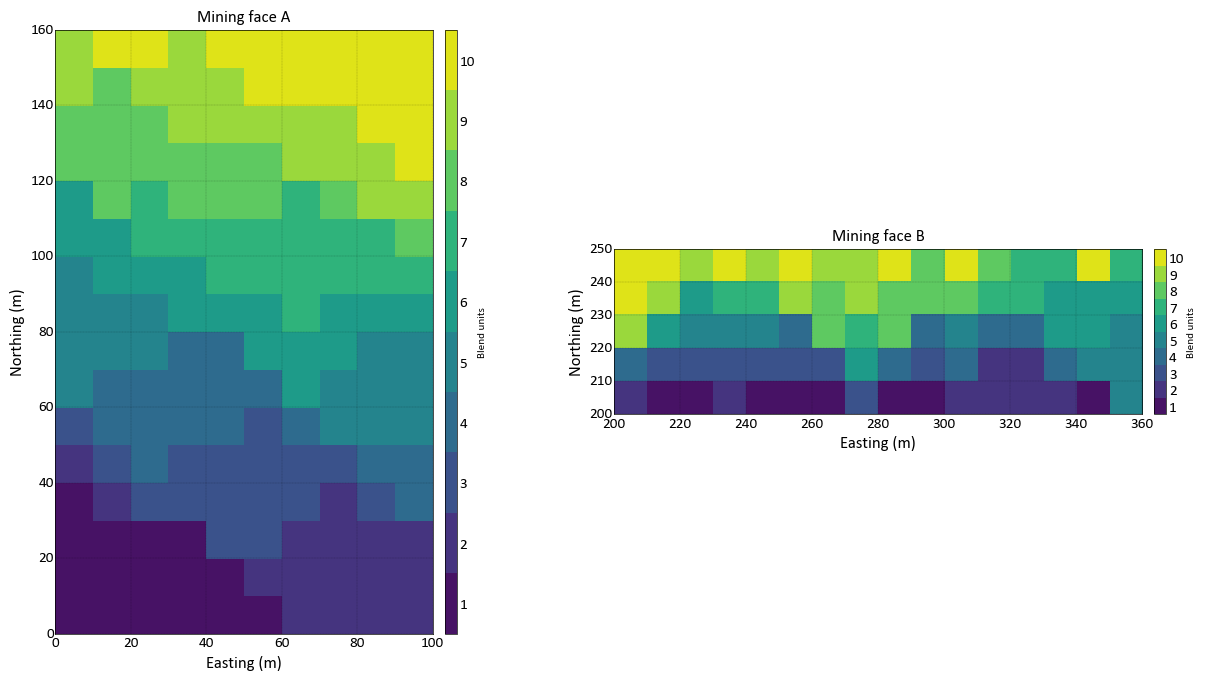

In [186]:
#visualizing optimized schedule
#if few units, use .astype(int)
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
_=gs.slice_plot(data=best_blend.astype(int).flatten(order='F'),griddef=grid,catdata=True, ax=axes[0], title='Mining face A', grid=True,cmap='viridis',cbar_label='Blend units')
_=gs.slice_plot(data=best_blend2.astype(int).flatten(order='F'),griddef=grid2,catdata=True, ax=axes[1],title='Mining face B',grid=True,cmap='viridis', cbar_label='Blend units')
plt.savefig (figfolder+'/syn_sched.png', bbox_inches = 'tight', dpi = 300)

In [187]:
best_tmr #total metal recovered (units of mass)

363.656132834

In [188]:
best_tmr/240 #total metal recovered (units of mass per block)

1.5152338868083333

In [189]:
increase = ((best_tmr-dflt_tmr)/dflt_tmr)*100
print('% increase in total metal recovered is {:.2f}%'.format(increase))

% increase in total metal recovered is 0.32%


In [190]:
best_tmr_list = np.multiply(best_att_unit,best_g_unit)
best_tmr_list = best_tmr_list.tolist()

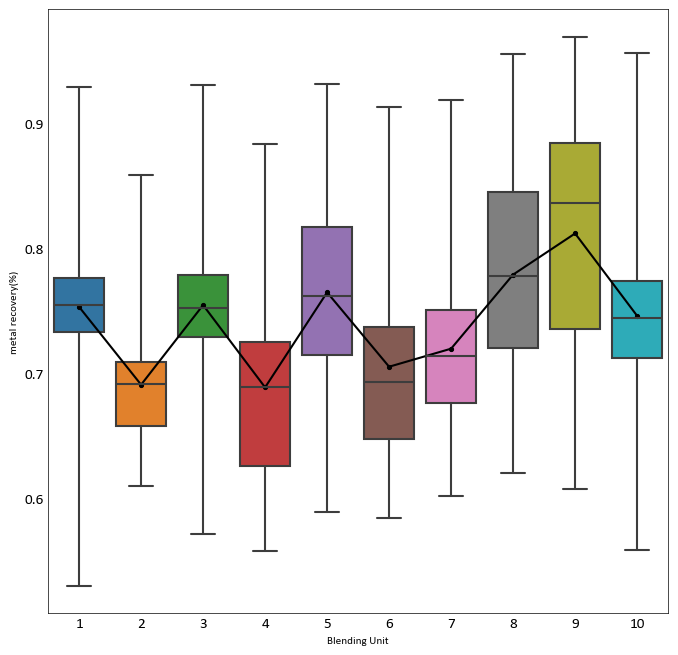

In [191]:
b_means = [np.mean(i) for i in best_att_unit]
ax=sns.boxplot(data=best_att_unit,whis=5)
ax=sns.lineplot(data=b_means,color='black',marker='o',markerfacecolor="black", markeredgecolor="black",markersize='3')
ax.set_xlabel('Blending Unit')
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
ax.set_ylabel('metal recovery(%)')
plt.savefig (figfolder+'/syn_rec.png', bbox_inches = 'tight', dpi = 300)

#### convergence

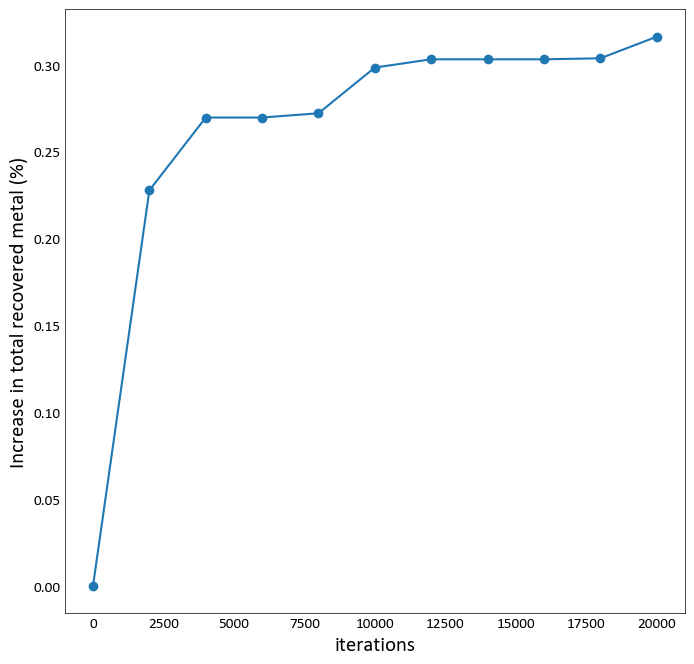

In [192]:
#visualizing if the seed changes the optimized result
n_iterations=20000
plt.xlabel('iterations',fontsize=15)
plt.ylabel('Increase in total recovered metal (%)',fontsize=15)
itera_values = list(range(0, n_iterations+1, int((n_iterations)/10)))

y_val=[]
for val in conv_lst_tmr:
    y_val.append(100*(val-conv_lst_tmr[0])/conv_lst_tmr[0])

plt.plot(itera_values, y_val, '-o')
plt.savefig(figfolder+'/it_conv_syn.png', bbox_inches = 'tight', dpi = 300)

### considering that metal recovery has antagonistic blending (w=2.0)

#### default schedule (zig-zag)

In [195]:
dflt_att_unit, dflt_g_unit, dflt_m_unit, dflt_blend, dflt_blend2, dflt_tmr, conv_lst_tmr = sim_annealing_2f(
    pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
    pv2, pv_mined2, gradev2, massv2, p_units2, b_units2,  #miningface2
    dist_penal=0.000,                                          #penalty for shovel movement
    w=2.0,                                                 #processing_par
    n_iterations=0, temp=5)

In [196]:
dflt_tmr #total metal recovered (units of mass)

331.927148047

#### optimized schedule

In [197]:
best_att_unit, best_g_unit, best_m_unit, best_blend, best_blend2, best_tmr, conv_lst_tmr = sim_annealing_2f(
    pv, pv_mined, gradev, massv, p_units, b_units,        #miningface1
    pv2, pv_mined2, gradev2, massv2, p_units2, b_units2,  #miningface2
    dist_penal=0.00,                                          #penalty for shovel movement
    w=2.0,                                                 #processing_par
    n_iterations=20000, temp=100)

iteration 1 found better value: 331.94349229700003
iteration 2 found worse value: 331.94349229700003.
iteration 2, perturbing to get out of local maxima
iteration 3 found worse value: 331.94349229700003.
iteration 3, perturbing to get out of local maxima
iteration 4 found worse value: 331.94349229700003.
iteration 4, perturbing to get out of local maxima
iteration 5 found worse value: 331.94349229700003.
iteration 5, perturbing to get out of local maxima
iteration 6 found worse value: 331.94349229700003.
iteration 6, perturbing to get out of local maxima
iteration 7 found worse value: 331.94349229700003.
iteration 8 found worse value: 331.94349229700003.
iteration 8, perturbing to get out of local maxima
iteration 9 found worse value: 331.94349229700003.
iteration 10 found worse value: 331.94349229700003.
iteration 11 found worse value: 331.94349229700003.
iteration 12 found worse value: 331.94349229700003.
iteration 13 found worse value: 331.94349229700003.
iteration 13, perturbing to

iteration 118 found worse value: 333.903302802.
iteration 119 found worse value: 333.903302802.
iteration 120 found worse value: 333.903302802.
iteration 120, perturbing to get out of local maxima
iteration 121 found worse value: 333.903302802.
iteration 121, perturbing to get out of local maxima
iteration 122 found worse value: 333.903302802.
iteration 123 found worse value: 333.903302802.
iteration 124 found worse value: 333.903302802.
iteration 125 found worse value: 333.903302802.
iteration 125, perturbing to get out of local maxima
iteration 126 found worse value: 333.903302802.
iteration 127 found worse value: 333.903302802.
iteration 127, perturbing to get out of local maxima
iteration 128 found worse value: 333.903302802.
iteration 128, perturbing to get out of local maxima
iteration 129 found worse value: 333.903302802.
iteration 129, perturbing to get out of local maxima
iteration 130 found worse value: 333.903302802.
iteration 131 found worse value: 333.903302802.
iteration 

iteration 239 found worse value: 333.903302802.
iteration 239, perturbing to get out of local maxima
iteration 240 found worse value: 333.903302802.
iteration 241 found worse value: 333.903302802.
iteration 242 found worse value: 333.903302802.
iteration 243 found worse value: 333.903302802.
iteration 244 found worse value: 333.903302802.
iteration 245 found worse value: 333.903302802.
iteration 246 found worse value: 333.903302802.
iteration 247 found worse value: 333.903302802.
iteration 247, perturbing to get out of local maxima
iteration 248 found worse value: 333.903302802.
iteration 248, perturbing to get out of local maxima
iteration 249 found worse value: 333.903302802.
iteration 249, perturbing to get out of local maxima
iteration 250 found worse value: 333.903302802.
iteration 250, perturbing to get out of local maxima
iteration 251 found worse value: 333.903302802.
iteration 252 found worse value: 333.903302802.
iteration 253 found worse value: 333.903302802.
iteration 254 f

iteration 379 found worse value: 334.758825533.
iteration 380 found better value: 334.81362964600004
iteration 381 found worse value: 334.81362964600004.
iteration 381, perturbing to get out of local maxima
iteration 382 found worse value: 334.81362964600004.
iteration 383 found worse value: 334.81362964600004.
iteration 383, perturbing to get out of local maxima
iteration 384 found worse value: 334.81362964600004.
iteration 384, perturbing to get out of local maxima
iteration 385 found worse value: 334.81362964600004.
iteration 386 found worse value: 334.81362964600004.
iteration 386, perturbing to get out of local maxima
iteration 387 found worse value: 334.81362964600004.
iteration 387, perturbing to get out of local maxima
iteration 388 found worse value: 334.81362964600004.
iteration 389 found worse value: 334.81362964600004.
iteration 390 found worse value: 334.81362964600004.
iteration 390, perturbing to get out of local maxima
iteration 391 found worse value: 334.81362964600004

iteration 507 found worse value: 334.851577602.
iteration 508 found worse value: 334.851577602.
iteration 509 found worse value: 334.851577602.
iteration 510 found worse value: 334.851577602.
iteration 511 found worse value: 334.851577602.
iteration 512 found worse value: 334.851577602.
iteration 512, perturbing to get out of local maxima
iteration 513 found worse value: 334.851577602.
iteration 513, perturbing to get out of local maxima
iteration 514 found worse value: 334.851577602.
iteration 514, perturbing to get out of local maxima
iteration 515 found worse value: 334.851577602.
iteration 516 found worse value: 334.851577602.
iteration 517 found worse value: 334.851577602.
iteration 517, perturbing to get out of local maxima
iteration 518 found worse value: 334.851577602.
iteration 519 found worse value: 334.851577602.
iteration 519, perturbing to get out of local maxima
iteration 520 found worse value: 334.851577602.
iteration 521 found worse value: 334.851577602.
iteration 521, 

iteration 732 found worse value: 334.988555833.
iteration 733 found worse value: 334.988555833.
iteration 734 found worse value: 334.988555833.
iteration 734, perturbing to get out of local maxima
iteration 735 found worse value: 334.988555833.
iteration 735, perturbing to get out of local maxima
iteration 736 found worse value: 334.988555833.
iteration 737 found worse value: 334.988555833.
iteration 738 found worse value: 334.988555833.
iteration 738, perturbing to get out of local maxima
iteration 739 found worse value: 334.988555833.
iteration 740 found worse value: 334.988555833.
iteration 740, perturbing to get out of local maxima
iteration 741 found worse value: 334.988555833.
iteration 742 found worse value: 334.988555833.
iteration 743 found worse value: 334.988555833.
iteration 743, perturbing to get out of local maxima
iteration 744 found worse value: 334.988555833.
iteration 745 found worse value: 334.988555833.
iteration 746 found worse value: 334.988555833.
iteration 746, 

iteration 862 found worse value: 336.085647827.
iteration 862, perturbing to get out of local maxima
iteration 863 found worse value: 336.085647827.
iteration 864 found worse value: 336.085647827.
iteration 865 found worse value: 336.085647827.
iteration 866 found worse value: 336.085647827.
iteration 867 found worse value: 336.085647827.
iteration 867, perturbing to get out of local maxima
iteration 868 found worse value: 336.085647827.
iteration 868, perturbing to get out of local maxima
iteration 869 found worse value: 336.085647827.
iteration 870 found worse value: 336.085647827.
iteration 871 found worse value: 336.085647827.
iteration 871, perturbing to get out of local maxima
iteration 872 found worse value: 336.085647827.
iteration 873 found worse value: 336.085647827.
iteration 874 found worse value: 336.085647827.
iteration 874, perturbing to get out of local maxima
iteration 875 found worse value: 336.085647827.
iteration 875, perturbing to get out of local maxima
iteration 

iteration 989 found worse value: 336.37299151599996.
iteration 990 found worse value: 336.37299151599996.
iteration 991 found worse value: 336.37299151599996.
iteration 992 found worse value: 336.37299151599996.
iteration 993 found worse value: 336.37299151599996.
iteration 994 found worse value: 336.37299151599996.
iteration 995 found worse value: 336.37299151599996.
iteration 996 found worse value: 336.37299151599996.
iteration 997 found worse value: 336.37299151599996.
iteration 998 found worse value: 336.37299151599996.
iteration 998, perturbing to get out of local maxima
iteration 999 found worse value: 336.37299151599996.
iteration 999, perturbing to get out of local maxima
iteration 1000 found worse value: 336.37299151599996.
iteration 1001 found worse value: 336.37299151599996.
iteration 1001, perturbing to get out of local maxima
iteration 1002 found worse value: 336.37299151599996.
iteration 1002, perturbing to get out of local maxima
iteration 1003 found worse value: 336.372

iteration 1112 found worse value: 336.37299151599996.
iteration 1113 found worse value: 336.37299151599996.
iteration 1114 found worse value: 336.37299151599996.
iteration 1115 found worse value: 336.37299151599996.
iteration 1115, perturbing to get out of local maxima
iteration 1116 found worse value: 336.37299151599996.
iteration 1117 found worse value: 336.37299151599996.
iteration 1118 found worse value: 336.37299151599996.
iteration 1119 found worse value: 336.37299151599996.
iteration 1119, perturbing to get out of local maxima
iteration 1120 found worse value: 336.37299151599996.
iteration 1121 found worse value: 336.37299151599996.
iteration 1121, perturbing to get out of local maxima
iteration 1122 found worse value: 336.37299151599996.
iteration 1123 found worse value: 336.37299151599996.
iteration 1124 found worse value: 336.37299151599996.
iteration 1125 found worse value: 336.37299151599996.
iteration 1125, perturbing to get out of local maxima
iteration 1126 found worse v

iteration 1253 found worse value: 336.37299151599996.
iteration 1254 found worse value: 336.37299151599996.
iteration 1255 found worse value: 336.37299151599996.
iteration 1256 found worse value: 336.37299151599996.
iteration 1256, perturbing to get out of local maxima
iteration 1257 found worse value: 336.37299151599996.
iteration 1258 found worse value: 336.37299151599996.
iteration 1259 found better value: 336.41145399799996
iteration 1260 found worse value: 336.41145399799996.
iteration 1261 found worse value: 336.41145399799996.
iteration 1262 found better value: 336.43648169
iteration 1263 found better value: 336.49118391599995
iteration 1264 found worse value: 336.49118391599995.
iteration 1264, perturbing to get out of local maxima
iteration 1265 found worse value: 336.49118391599995.
iteration 1266 found worse value: 336.49118391599995.
iteration 1266, perturbing to get out of local maxima
iteration 1267 found worse value: 336.49118391599995.
iteration 1268 found worse value: 

iteration 1489 found worse value: 336.782029511.
iteration 1490 found worse value: 336.782029511.
iteration 1491 found worse value: 336.782029511.
iteration 1492 found worse value: 336.782029511.
iteration 1492, perturbing to get out of local maxima
iteration 1493 found worse value: 336.782029511.
iteration 1494 found worse value: 336.782029511.
iteration 1495 found worse value: 336.782029511.
iteration 1496 found worse value: 336.782029511.
iteration 1496, perturbing to get out of local maxima
iteration 1497 found worse value: 336.782029511.
iteration 1498 found worse value: 336.782029511.
iteration 1499 found worse value: 336.782029511.
iteration 1500 found worse value: 336.782029511.
iteration 1501 found worse value: 336.782029511.
iteration 1502 found worse value: 336.782029511.
iteration 1503 found worse value: 336.782029511.
iteration 1504 found worse value: 336.782029511.
iteration 1505 found worse value: 336.782029511.
iteration 1506 found worse value: 336.782029511.
iteration 

iteration 1693 found worse value: 337.41453529.
iteration 1694 found worse value: 337.41453529.
iteration 1694, perturbing to get out of local maxima
iteration 1695 found worse value: 337.41453529.
iteration 1696 found worse value: 337.41453529.
iteration 1697 found worse value: 337.41453529.
iteration 1698 found worse value: 337.41453529.
iteration 1699 found worse value: 337.41453529.
iteration 1700 found worse value: 337.41453529.
iteration 1700, perturbing to get out of local maxima
iteration 1701 found worse value: 337.41453529.
iteration 1701, perturbing to get out of local maxima
iteration 1702 found worse value: 337.41453529.
iteration 1703 found worse value: 337.41453529.
iteration 1704 found worse value: 337.41453529.
iteration 1705 found worse value: 337.41453529.
iteration 1706 found worse value: 337.41453529.
iteration 1707 found worse value: 337.41453529.
iteration 1708 found worse value: 337.41453529.
iteration 1709 found worse value: 337.41453529.
iteration 1710 found w

iteration 1913 found worse value: 337.745701489.
iteration 1914 found worse value: 337.745701489.
iteration 1915 found worse value: 337.745701489.
iteration 1916 found worse value: 337.745701489.
iteration 1916, perturbing to get out of local maxima
iteration 1917 found worse value: 337.745701489.
iteration 1918 found worse value: 337.745701489.
iteration 1919 found worse value: 337.745701489.
iteration 1920 found worse value: 337.745701489.
iteration 1921 found worse value: 337.745701489.
iteration 1922 found worse value: 337.745701489.
iteration 1923 found worse value: 337.745701489.
iteration 1923, perturbing to get out of local maxima
iteration 1924 found worse value: 337.745701489.
iteration 1925 found worse value: 337.745701489.
iteration 1926 found worse value: 337.745701489.
iteration 1927 found worse value: 337.745701489.
iteration 1928 found worse value: 337.745701489.
iteration 1929 found worse value: 337.745701489.
iteration 1929, perturbing to get out of local maxima
itera

iteration 2141 found worse value: 337.89614429799997.
iteration 2141, perturbing to get out of local maxima
iteration 2142 found worse value: 337.89614429799997.
iteration 2143 found worse value: 337.89614429799997.
iteration 2143, perturbing to get out of local maxima
iteration 2144 found worse value: 337.89614429799997.
iteration 2145 found worse value: 337.89614429799997.
iteration 2146 found worse value: 337.89614429799997.
iteration 2147 found worse value: 337.89614429799997.
iteration 2148 found worse value: 337.89614429799997.
iteration 2149 found worse value: 337.89614429799997.
iteration 2150 found worse value: 337.89614429799997.
iteration 2150, perturbing to get out of local maxima
iteration 2151 found worse value: 337.89614429799997.
iteration 2152 found worse value: 337.89614429799997.
iteration 2153 found worse value: 337.89614429799997.
iteration 2154 found worse value: 337.89614429799997.
iteration 2155 found worse value: 337.89614429799997.
iteration 2156 found worse v

iteration 2271 found worse value: 338.032570373.
iteration 2272 found worse value: 338.032570373.
iteration 2273 found worse value: 338.032570373.
iteration 2274 found worse value: 338.032570373.
iteration 2275 found better value: 338.052570727
iteration 2276 found better value: 338.162288393
iteration 2277 found better value: 338.17497270499996
iteration 2278 found worse value: 338.17497270499996.
iteration 2279 found worse value: 338.17497270499996.
iteration 2280 found worse value: 338.17497270499996.
iteration 2280, perturbing to get out of local maxima
iteration 2281 found worse value: 338.17497270499996.
iteration 2282 found worse value: 338.17497270499996.
iteration 2283 found worse value: 338.17497270499996.
iteration 2283, perturbing to get out of local maxima
iteration 2284 found worse value: 338.17497270499996.
iteration 2285 found worse value: 338.17497270499996.
iteration 2286 found worse value: 338.17497270499996.
iteration 2287 found worse value: 338.17497270499996.
iter

iteration 2408 found worse value: 338.375458836.
iteration 2409 found worse value: 338.375458836.
iteration 2410 found worse value: 338.375458836.
iteration 2411 found worse value: 338.375458836.
iteration 2412 found worse value: 338.375458836.
iteration 2413 found worse value: 338.375458836.
iteration 2414 found worse value: 338.375458836.
iteration 2415 found worse value: 338.375458836.
iteration 2416 found worse value: 338.375458836.
iteration 2416, perturbing to get out of local maxima
iteration 2417 found worse value: 338.375458836.
iteration 2417, perturbing to get out of local maxima
iteration 2418 found worse value: 338.375458836.
iteration 2419 found worse value: 338.375458836.
iteration 2420 found worse value: 338.375458836.
iteration 2420, perturbing to get out of local maxima
iteration 2421 found worse value: 338.375458836.
iteration 2422 found worse value: 338.375458836.
iteration 2423 found worse value: 338.375458836.
iteration 2423, perturbing to get out of local maxima


iteration 2646 found worse value: 339.438579401.
iteration 2647 found better value: 339.44254955900004
iteration 2648 found worse value: 339.44254955900004.
iteration 2649 found better value: 339.449404819
iteration 2650 found worse value: 339.449404819.
iteration 2651 found worse value: 339.449404819.
iteration 2652 found worse value: 339.449404819.
iteration 2653 found better value: 339.479386789
iteration 2654 found worse value: 339.479386789.
iteration 2655 found worse value: 339.479386789.
iteration 2656 found worse value: 339.479386789.
iteration 2657 found better value: 339.47998006100005
iteration 2658 found worse value: 339.47998006100005.
iteration 2658, perturbing to get out of local maxima
iteration 2659 found worse value: 339.47998006100005.
iteration 2659, perturbing to get out of local maxima
iteration 2660 found worse value: 339.47998006100005.
iteration 2661 found worse value: 339.47998006100005.
iteration 2662 found worse value: 339.47998006100005.
iteration 2662, per

iteration 2839 found worse value: 339.82987452199995.
iteration 2839, perturbing to get out of local maxima
iteration 2840 found worse value: 339.82987452199995.
iteration 2841 found worse value: 339.82987452199995.
iteration 2842 found worse value: 339.82987452199995.
iteration 2843 found worse value: 339.82987452199995.
iteration 2844 found worse value: 339.82987452199995.
iteration 2845 found worse value: 339.82987452199995.
iteration 2846 found worse value: 339.82987452199995.
iteration 2847 found worse value: 339.82987452199995.
iteration 2848 found worse value: 339.82987452199995.
iteration 2848, perturbing to get out of local maxima
iteration 2849 found worse value: 339.82987452199995.
iteration 2850 found worse value: 339.82987452199995.
iteration 2851 found worse value: 339.82987452199995.
iteration 2852 found worse value: 339.82987452199995.
iteration 2853 found worse value: 339.82987452199995.
iteration 2854 found worse value: 339.82987452199995.
iteration 2855 found worse v

iteration 3077 found worse value: 340.041160057.
iteration 3078 found worse value: 340.041160057.
iteration 3079 found better value: 340.05089222600003
iteration 3080 found worse value: 340.05089222600003.
iteration 3081 found worse value: 340.05089222600003.
iteration 3082 found worse value: 340.05089222600003.
iteration 3083 found worse value: 340.05089222600003.
iteration 3084 found worse value: 340.05089222600003.
iteration 3085 found worse value: 340.05089222600003.
iteration 3085, perturbing to get out of local maxima
iteration 3086 found worse value: 340.05089222600003.
iteration 3087 found worse value: 340.05089222600003.
iteration 3088 found worse value: 340.05089222600003.
iteration 3089 found worse value: 340.05089222600003.
iteration 3089, perturbing to get out of local maxima
iteration 3090 found worse value: 340.05089222600003.
iteration 3091 found worse value: 340.05089222600003.
iteration 3092 found worse value: 340.05089222600003.
iteration 3092, perturbing to get out 

iteration 3321 found worse value: 340.260584128.
iteration 3322 found worse value: 340.260584128.
iteration 3323 found worse value: 340.260584128.
iteration 3324 found worse value: 340.260584128.
iteration 3324, perturbing to get out of local maxima
iteration 3325 found worse value: 340.260584128.
iteration 3326 found worse value: 340.260584128.
iteration 3327 found worse value: 340.260584128.
iteration 3328 found worse value: 340.260584128.
iteration 3329 found worse value: 340.260584128.
iteration 3330 found worse value: 340.260584128.
iteration 3330, perturbing to get out of local maxima
iteration 3331 found worse value: 340.260584128.
iteration 3331, perturbing to get out of local maxima
iteration 3332 found worse value: 340.260584128.
iteration 3333 found worse value: 340.260584128.
iteration 3333, perturbing to get out of local maxima
iteration 3334 found worse value: 340.260584128.
iteration 3335 found worse value: 340.260584128.
iteration 3336 found worse value: 340.260584128.


iteration 3546 found worse value: 340.452704167.
iteration 3547 found worse value: 340.452704167.
iteration 3548 found worse value: 340.452704167.
iteration 3549 found worse value: 340.452704167.
iteration 3550 found worse value: 340.452704167.
iteration 3551 found worse value: 340.452704167.
iteration 3552 found worse value: 340.452704167.
iteration 3553 found worse value: 340.452704167.
iteration 3554 found worse value: 340.452704167.
iteration 3555 found worse value: 340.452704167.
iteration 3556 found worse value: 340.452704167.
iteration 3557 found worse value: 340.452704167.
iteration 3558 found worse value: 340.452704167.
iteration 3559 found worse value: 340.452704167.
iteration 3560 found worse value: 340.452704167.
iteration 3560, perturbing to get out of local maxima
iteration 3561 found worse value: 340.452704167.
iteration 3562 found worse value: 340.452704167.
iteration 3562, perturbing to get out of local maxima
iteration 3563 found worse value: 340.452704167.
iteration 

iteration 3770 found worse value: 340.452704167.
iteration 3771 found worse value: 340.452704167.
iteration 3772 found worse value: 340.452704167.
iteration 3773 found worse value: 340.452704167.
iteration 3774 found worse value: 340.452704167.
iteration 3775 found worse value: 340.452704167.
iteration 3776 found worse value: 340.452704167.
iteration 3777 found worse value: 340.452704167.
iteration 3778 found worse value: 340.452704167.
iteration 3778, perturbing to get out of local maxima
iteration 3779 found worse value: 340.452704167.
iteration 3780 found worse value: 340.452704167.
iteration 3781 found worse value: 340.452704167.
iteration 3782 found worse value: 340.452704167.
iteration 3783 found worse value: 340.452704167.
iteration 3784 found worse value: 340.452704167.
iteration 3785 found worse value: 340.452704167.
iteration 3786 found worse value: 340.452704167.
iteration 3787 found worse value: 340.452704167.
iteration 3787, perturbing to get out of local maxima
iteration 

iteration 3976 found worse value: 340.547398682.
iteration 3977 found worse value: 340.547398682.
iteration 3978 found worse value: 340.547398682.
iteration 3979 found worse value: 340.547398682.
iteration 3980 found worse value: 340.547398682.
iteration 3980, perturbing to get out of local maxima
iteration 3981 found worse value: 340.547398682.
iteration 3982 found worse value: 340.547398682.
iteration 3983 found worse value: 340.547398682.
iteration 3984 found worse value: 340.547398682.
iteration 3985 found worse value: 340.547398682.
iteration 3986 found worse value: 340.547398682.
iteration 3987 found worse value: 340.547398682.
iteration 3988 found worse value: 340.547398682.
iteration 3989 found worse value: 340.547398682.
iteration 3990 found worse value: 340.547398682.
iteration 3991 found worse value: 340.547398682.
iteration 3992 found worse value: 340.547398682.
iteration 3993 found worse value: 340.547398682.
iteration 3994 found worse value: 340.547398682.
iteration 3995 

iteration 4130 found worse value: 340.547398682.
iteration 4131 found worse value: 340.547398682.
iteration 4132 found worse value: 340.547398682.
iteration 4133 found worse value: 340.547398682.
iteration 4134 found worse value: 340.547398682.
iteration 4135 found worse value: 340.547398682.
iteration 4136 found worse value: 340.547398682.
iteration 4137 found worse value: 340.547398682.
iteration 4138 found worse value: 340.547398682.
iteration 4139 found worse value: 340.547398682.
iteration 4140 found worse value: 340.547398682.
iteration 4141 found worse value: 340.547398682.
iteration 4142 found worse value: 340.547398682.
iteration 4143 found worse value: 340.547398682.
iteration 4144 found worse value: 340.547398682.
iteration 4144, perturbing to get out of local maxima
iteration 4145 found worse value: 340.547398682.
iteration 4146 found worse value: 340.547398682.
iteration 4147 found worse value: 340.547398682.
iteration 4148 found worse value: 340.547398682.
iteration 4149 

iteration 4324 found worse value: 340.58696155.
iteration 4324, perturbing to get out of local maxima
iteration 4325 found worse value: 340.58696155.
iteration 4326 found worse value: 340.58696155.
iteration 4326, perturbing to get out of local maxima
iteration 4327 found worse value: 340.58696155.
iteration 4328 found worse value: 340.58696155.
iteration 4329 found worse value: 340.58696155.
iteration 4330 found worse value: 340.58696155.
iteration 4331 found worse value: 340.58696155.
iteration 4332 found worse value: 340.58696155.
iteration 4333 found worse value: 340.58696155.
iteration 4334 found worse value: 340.58696155.
iteration 4335 found worse value: 340.58696155.
iteration 4335, perturbing to get out of local maxima
iteration 4336 found worse value: 340.58696155.
iteration 4337 found worse value: 340.58696155.
iteration 4338 found worse value: 340.58696155.
iteration 4339 found worse value: 340.58696155.
iteration 4340 found worse value: 340.58696155.
iteration 4341 found w

iteration 4523 found worse value: 340.58696155.
iteration 4524 found worse value: 340.58696155.
iteration 4525 found worse value: 340.58696155.
iteration 4526 found worse value: 340.58696155.
iteration 4526, perturbing to get out of local maxima
iteration 4527 found worse value: 340.58696155.
iteration 4527, perturbing to get out of local maxima
iteration 4528 found worse value: 340.58696155.
iteration 4529 found worse value: 340.58696155.
iteration 4530 found worse value: 340.58696155.
iteration 4531 found worse value: 340.58696155.
iteration 4532 found worse value: 340.58696155.
iteration 4532, perturbing to get out of local maxima
iteration 4533 found worse value: 340.58696155.
iteration 4534 found worse value: 340.58696155.
iteration 4534, perturbing to get out of local maxima
iteration 4535 found worse value: 340.58696155.
iteration 4536 found worse value: 340.58696155.
iteration 4537 found worse value: 340.58696155.
iteration 4538 found worse value: 340.58696155.
iteration 4539 f

iteration 4764 found worse value: 340.58696155.
iteration 4765 found worse value: 340.58696155.
iteration 4766 found worse value: 340.58696155.
iteration 4767 found worse value: 340.58696155.
iteration 4768 found worse value: 340.58696155.
iteration 4769 found worse value: 340.58696155.
iteration 4770 found worse value: 340.58696155.
iteration 4771 found worse value: 340.58696155.
iteration 4772 found worse value: 340.58696155.
iteration 4773 found worse value: 340.58696155.
iteration 4774 found worse value: 340.58696155.
iteration 4775 found worse value: 340.58696155.
iteration 4775, perturbing to get out of local maxima
iteration 4776 found worse value: 340.58696155.
iteration 4777 found worse value: 340.58696155.
iteration 4778 found worse value: 340.58696155.
iteration 4779 found worse value: 340.58696155.
iteration 4780 found worse value: 340.58696155.
iteration 4781 found worse value: 340.58696155.
iteration 4782 found worse value: 340.58696155.
iteration 4783 found worse value: 

iteration 4975 found worse value: 340.58696155.
iteration 4976 found worse value: 340.58696155.
iteration 4977 found worse value: 340.58696155.
iteration 4978 found worse value: 340.58696155.
iteration 4979 found worse value: 340.58696155.
iteration 4980 found worse value: 340.58696155.
iteration 4981 found worse value: 340.58696155.
iteration 4982 found worse value: 340.58696155.
iteration 4983 found worse value: 340.58696155.
iteration 4984 found worse value: 340.58696155.
iteration 4985 found worse value: 340.58696155.
iteration 4985, perturbing to get out of local maxima
iteration 4986 found worse value: 340.58696155.
iteration 4986, perturbing to get out of local maxima
iteration 4987 found worse value: 340.58696155.
iteration 4988 found worse value: 340.58696155.
iteration 4989 found worse value: 340.58696155.
iteration 4990 found worse value: 340.58696155.
iteration 4991 found worse value: 340.58696155.
iteration 4992 found worse value: 340.58696155.
iteration 4993 found worse v

iteration 5197 found worse value: 340.58696155.
iteration 5198 found worse value: 340.58696155.
iteration 5198, perturbing to get out of local maxima
iteration 5199 found worse value: 340.58696155.
iteration 5200 found worse value: 340.58696155.
iteration 5201 found worse value: 340.58696155.
iteration 5202 found worse value: 340.58696155.
iteration 5203 found worse value: 340.58696155.
iteration 5204 found worse value: 340.58696155.
iteration 5205 found worse value: 340.58696155.
iteration 5206 found worse value: 340.58696155.
iteration 5206, perturbing to get out of local maxima
iteration 5207 found worse value: 340.58696155.
iteration 5207, perturbing to get out of local maxima
iteration 5208 found worse value: 340.58696155.
iteration 5209 found worse value: 340.58696155.
iteration 5209, perturbing to get out of local maxima
iteration 5210 found worse value: 340.58696155.
iteration 5211 found worse value: 340.58696155.
iteration 5211, perturbing to get out of local maxima
iteration 

iteration 5421 found worse value: 340.58696155.
iteration 5422 found worse value: 340.58696155.
iteration 5423 found worse value: 340.58696155.
iteration 5424 found worse value: 340.58696155.
iteration 5425 found worse value: 340.58696155.
iteration 5426 found worse value: 340.58696155.
iteration 5427 found worse value: 340.58696155.
iteration 5427, perturbing to get out of local maxima
iteration 5428 found worse value: 340.58696155.
iteration 5429 found worse value: 340.58696155.
iteration 5430 found worse value: 340.58696155.
iteration 5431 found worse value: 340.58696155.
iteration 5432 found worse value: 340.58696155.
iteration 5433 found worse value: 340.58696155.
iteration 5434 found worse value: 340.58696155.
iteration 5435 found worse value: 340.58696155.
iteration 5436 found worse value: 340.58696155.
iteration 5437 found better value: 340.59296584800006
iteration 5438 found worse value: 340.59296584800006.
iteration 5439 found worse value: 340.59296584800006.
iteration 5439, 

iteration 5632 found worse value: 340.59296584800006.
iteration 5633 found worse value: 340.59296584800006.
iteration 5634 found worse value: 340.59296584800006.
iteration 5635 found worse value: 340.59296584800006.
iteration 5636 found worse value: 340.59296584800006.
iteration 5637 found worse value: 340.59296584800006.
iteration 5638 found better value: 340.61174656799994
iteration 5639 found worse value: 340.61174656799994.
iteration 5640 found worse value: 340.61174656799994.
iteration 5641 found worse value: 340.61174656799994.
iteration 5642 found worse value: 340.61174656799994.
iteration 5643 found worse value: 340.61174656799994.
iteration 5644 found worse value: 340.61174656799994.
iteration 5645 found better value: 340.676868197
iteration 5646 found worse value: 340.676868197.
iteration 5647 found worse value: 340.676868197.
iteration 5648 found worse value: 340.676868197.
iteration 5649 found worse value: 340.676868197.
iteration 5650 found worse value: 340.676868197.
iter

iteration 5855 found worse value: 340.705556725.
iteration 5856 found worse value: 340.705556725.
iteration 5857 found worse value: 340.705556725.
iteration 5858 found worse value: 340.705556725.
iteration 5859 found worse value: 340.705556725.
iteration 5860 found worse value: 340.705556725.
iteration 5861 found worse value: 340.705556725.
iteration 5862 found worse value: 340.705556725.
iteration 5863 found worse value: 340.705556725.
iteration 5864 found worse value: 340.705556725.
iteration 5865 found worse value: 340.705556725.
iteration 5866 found worse value: 340.705556725.
iteration 5867 found worse value: 340.705556725.
iteration 5868 found worse value: 340.705556725.
iteration 5869 found worse value: 340.705556725.
iteration 5870 found worse value: 340.705556725.
iteration 5870, perturbing to get out of local maxima
iteration 5871 found worse value: 340.705556725.
iteration 5872 found worse value: 340.705556725.
iteration 5872, perturbing to get out of local maxima
iteration 

iteration 6048 found worse value: 340.705556725.
iteration 6049 found worse value: 340.705556725.
iteration 6050 found worse value: 340.705556725.
iteration 6051 found worse value: 340.705556725.
iteration 6052 found worse value: 340.705556725.
iteration 6053 found worse value: 340.705556725.
iteration 6054 found worse value: 340.705556725.
iteration 6055 found worse value: 340.705556725.
iteration 6056 found worse value: 340.705556725.
iteration 6057 found worse value: 340.705556725.
iteration 6058 found worse value: 340.705556725.
iteration 6059 found worse value: 340.705556725.
iteration 6060 found worse value: 340.705556725.
iteration 6061 found worse value: 340.705556725.
iteration 6062 found worse value: 340.705556725.
iteration 6063 found worse value: 340.705556725.
iteration 6064 found worse value: 340.705556725.
iteration 6065 found worse value: 340.705556725.
iteration 6066 found worse value: 340.705556725.
iteration 6067 found worse value: 340.705556725.
iteration 6068 found

iteration 6231 found worse value: 340.705556725.
iteration 6232 found worse value: 340.705556725.
iteration 6233 found worse value: 340.705556725.
iteration 6234 found worse value: 340.705556725.
iteration 6235 found worse value: 340.705556725.
iteration 6236 found worse value: 340.705556725.
iteration 6237 found worse value: 340.705556725.
iteration 6238 found worse value: 340.705556725.
iteration 6239 found worse value: 340.705556725.
iteration 6240 found worse value: 340.705556725.
iteration 6241 found worse value: 340.705556725.
iteration 6242 found worse value: 340.705556725.
iteration 6243 found worse value: 340.705556725.
iteration 6244 found worse value: 340.705556725.
iteration 6245 found worse value: 340.705556725.
iteration 6246 found worse value: 340.705556725.
iteration 6247 found worse value: 340.705556725.
iteration 6248 found worse value: 340.705556725.
iteration 6249 found worse value: 340.705556725.
iteration 6250 found worse value: 340.705556725.
iteration 6251 found

iteration 6404 found worse value: 340.705556725.
iteration 6405 found worse value: 340.705556725.
iteration 6406 found worse value: 340.705556725.
iteration 6407 found worse value: 340.705556725.
iteration 6408 found worse value: 340.705556725.
iteration 6409 found worse value: 340.705556725.
iteration 6410 found worse value: 340.705556725.
iteration 6411 found worse value: 340.705556725.
iteration 6412 found worse value: 340.705556725.
iteration 6413 found worse value: 340.705556725.
iteration 6414 found worse value: 340.705556725.
iteration 6415 found worse value: 340.705556725.
iteration 6416 found worse value: 340.705556725.
iteration 6416, perturbing to get out of local maxima
iteration 6417 found worse value: 340.705556725.
iteration 6418 found worse value: 340.705556725.
iteration 6419 found worse value: 340.705556725.
iteration 6419, perturbing to get out of local maxima
iteration 6420 found worse value: 340.705556725.
iteration 6421 found worse value: 340.705556725.
iteration 

iteration 6600 found worse value: 340.705556725.
iteration 6601 found worse value: 340.705556725.
iteration 6602 found worse value: 340.705556725.
iteration 6603 found worse value: 340.705556725.
iteration 6604 found worse value: 340.705556725.
iteration 6605 found worse value: 340.705556725.
iteration 6606 found worse value: 340.705556725.
iteration 6607 found worse value: 340.705556725.
iteration 6608 found worse value: 340.705556725.
iteration 6609 found worse value: 340.705556725.
iteration 6610 found worse value: 340.705556725.
iteration 6610, perturbing to get out of local maxima
iteration 6611 found worse value: 340.705556725.
iteration 6612 found worse value: 340.705556725.
iteration 6613 found worse value: 340.705556725.
iteration 6614 found worse value: 340.705556725.
iteration 6615 found worse value: 340.705556725.
iteration 6616 found worse value: 340.705556725.
iteration 6617 found worse value: 340.705556725.
iteration 6618 found worse value: 340.705556725.
iteration 6618,

iteration 6802 found worse value: 340.705556725.
iteration 6803 found worse value: 340.705556725.
iteration 6804 found worse value: 340.705556725.
iteration 6805 found worse value: 340.705556725.
iteration 6806 found worse value: 340.705556725.
iteration 6807 found worse value: 340.705556725.
iteration 6808 found worse value: 340.705556725.
iteration 6809 found worse value: 340.705556725.
iteration 6810 found worse value: 340.705556725.
iteration 6811 found worse value: 340.705556725.
iteration 6812 found worse value: 340.705556725.
iteration 6813 found worse value: 340.705556725.
iteration 6814 found worse value: 340.705556725.
iteration 6815 found worse value: 340.705556725.
iteration 6816 found worse value: 340.705556725.
iteration 6817 found worse value: 340.705556725.
iteration 6818 found worse value: 340.705556725.
iteration 6819 found worse value: 340.705556725.
iteration 6820 found worse value: 340.705556725.
iteration 6821 found worse value: 340.705556725.
iteration 6822 found

iteration 7009 found worse value: 340.771300193.
iteration 7010 found worse value: 340.771300193.
iteration 7011 found worse value: 340.771300193.
iteration 7012 found worse value: 340.771300193.
iteration 7013 found worse value: 340.771300193.
iteration 7014 found worse value: 340.771300193.
iteration 7015 found worse value: 340.771300193.
iteration 7015, perturbing to get out of local maxima
iteration 7016 found worse value: 340.771300193.
iteration 7017 found worse value: 340.771300193.
iteration 7018 found worse value: 340.771300193.
iteration 7019 found worse value: 340.771300193.
iteration 7020 found worse value: 340.771300193.
iteration 7021 found worse value: 340.771300193.
iteration 7022 found worse value: 340.771300193.
iteration 7023 found worse value: 340.771300193.
iteration 7024 found worse value: 340.771300193.
iteration 7025 found worse value: 340.771300193.
iteration 7026 found worse value: 340.771300193.
iteration 7027 found worse value: 340.771300193.
iteration 7028 

iteration 7218 found worse value: 340.771300193.
iteration 7219 found worse value: 340.771300193.
iteration 7220 found worse value: 340.771300193.
iteration 7221 found worse value: 340.771300193.
iteration 7222 found worse value: 340.771300193.
iteration 7223 found worse value: 340.771300193.
iteration 7224 found worse value: 340.771300193.
iteration 7225 found worse value: 340.771300193.
iteration 7226 found worse value: 340.771300193.
iteration 7227 found worse value: 340.771300193.
iteration 7228 found worse value: 340.771300193.
iteration 7229 found worse value: 340.771300193.
iteration 7230 found worse value: 340.771300193.
iteration 7231 found worse value: 340.771300193.
iteration 7232 found worse value: 340.771300193.
iteration 7233 found worse value: 340.771300193.
iteration 7234 found worse value: 340.771300193.
iteration 7235 found worse value: 340.771300193.
iteration 7236 found worse value: 340.771300193.
iteration 7236, perturbing to get out of local maxima
iteration 7237 

iteration 7431 found worse value: 340.801815846.
iteration 7432 found worse value: 340.801815846.
iteration 7432, perturbing to get out of local maxima
iteration 7433 found worse value: 340.801815846.
iteration 7434 found worse value: 340.801815846.
iteration 7435 found worse value: 340.801815846.
iteration 7436 found worse value: 340.801815846.
iteration 7437 found worse value: 340.801815846.
iteration 7438 found worse value: 340.801815846.
iteration 7439 found worse value: 340.801815846.
iteration 7440 found worse value: 340.801815846.
iteration 7441 found worse value: 340.801815846.
iteration 7442 found worse value: 340.801815846.
iteration 7443 found worse value: 340.801815846.
iteration 7444 found worse value: 340.801815846.
iteration 7445 found worse value: 340.801815846.
iteration 7446 found worse value: 340.801815846.
iteration 7447 found worse value: 340.801815846.
iteration 7448 found worse value: 340.801815846.
iteration 7449 found worse value: 340.801815846.
iteration 7450 

iteration 7638 found worse value: 340.86977331500003.
iteration 7639 found worse value: 340.86977331500003.
iteration 7640 found worse value: 340.86977331500003.
iteration 7641 found worse value: 340.86977331500003.
iteration 7642 found worse value: 340.86977331500003.
iteration 7643 found worse value: 340.86977331500003.
iteration 7644 found worse value: 340.86977331500003.
iteration 7645 found worse value: 340.86977331500003.
iteration 7646 found worse value: 340.86977331500003.
iteration 7647 found worse value: 340.86977331500003.
iteration 7648 found worse value: 340.86977331500003.
iteration 7649 found worse value: 340.86977331500003.
iteration 7650 found worse value: 340.86977331500003.
iteration 7651 found worse value: 340.86977331500003.
iteration 7652 found worse value: 340.86977331500003.
iteration 7653 found worse value: 340.86977331500003.
iteration 7654 found worse value: 340.86977331500003.
iteration 7655 found worse value: 340.86977331500003.
iteration 7656 found worse v

iteration 7851 found worse value: 340.86977331500003.
iteration 7852 found worse value: 340.86977331500003.
iteration 7853 found worse value: 340.86977331500003.
iteration 7854 found worse value: 340.86977331500003.
iteration 7855 found worse value: 340.86977331500003.
iteration 7856 found worse value: 340.86977331500003.
iteration 7857 found worse value: 340.86977331500003.
iteration 7858 found worse value: 340.86977331500003.
iteration 7859 found worse value: 340.86977331500003.
iteration 7860 found worse value: 340.86977331500003.
iteration 7861 found worse value: 340.86977331500003.
iteration 7861, perturbing to get out of local maxima
iteration 7862 found worse value: 340.86977331500003.
iteration 7863 found worse value: 340.86977331500003.
iteration 7864 found worse value: 340.86977331500003.
iteration 7865 found worse value: 340.86977331500003.
iteration 7866 found worse value: 340.86977331500003.
iteration 7867 found worse value: 340.86977331500003.
iteration 7868 found worse v

iteration 8046 found worse value: 340.883699679.
iteration 8047 found worse value: 340.883699679.
iteration 8048 found worse value: 340.883699679.
iteration 8049 found worse value: 340.883699679.
iteration 8050 found worse value: 340.883699679.
iteration 8051 found worse value: 340.883699679.
iteration 8052 found worse value: 340.883699679.
iteration 8053 found worse value: 340.883699679.
iteration 8054 found better value: 340.889588553
iteration 8055 found worse value: 340.889588553.
iteration 8056 found worse value: 340.889588553.
iteration 8057 found worse value: 340.889588553.
iteration 8058 found worse value: 340.889588553.
iteration 8058, perturbing to get out of local maxima
iteration 8059 found worse value: 340.889588553.
iteration 8060 found worse value: 340.889588553.
iteration 8061 found worse value: 340.889588553.
iteration 8062 found worse value: 340.889588553.
iteration 8063 found worse value: 340.889588553.
iteration 8064 found better value: 340.893461318
iteration 8065 

iteration 8261 found worse value: 340.90062919200005.
iteration 8262 found worse value: 340.90062919200005.
iteration 8263 found worse value: 340.90062919200005.
iteration 8264 found worse value: 340.90062919200005.
iteration 8265 found worse value: 340.90062919200005.
iteration 8266 found worse value: 340.90062919200005.
iteration 8267 found worse value: 340.90062919200005.
iteration 8268 found worse value: 340.90062919200005.
iteration 8269 found worse value: 340.90062919200005.
iteration 8270 found worse value: 340.90062919200005.
iteration 8271 found worse value: 340.90062919200005.
iteration 8271, perturbing to get out of local maxima
iteration 8272 found worse value: 340.90062919200005.
iteration 8273 found worse value: 340.90062919200005.
iteration 8274 found worse value: 340.90062919200005.
iteration 8275 found worse value: 340.90062919200005.
iteration 8276 found worse value: 340.90062919200005.
iteration 8277 found worse value: 340.90062919200005.
iteration 8278 found worse v

iteration 8465 found worse value: 340.935195996.
iteration 8466 found worse value: 340.935195996.
iteration 8467 found worse value: 340.935195996.
iteration 8468 found worse value: 340.935195996.
iteration 8469 found worse value: 340.935195996.
iteration 8470 found worse value: 340.935195996.
iteration 8471 found worse value: 340.935195996.
iteration 8472 found worse value: 340.935195996.
iteration 8473 found worse value: 340.935195996.
iteration 8474 found worse value: 340.935195996.
iteration 8474, perturbing to get out of local maxima
iteration 8475 found worse value: 340.935195996.
iteration 8476 found worse value: 340.935195996.
iteration 8477 found worse value: 340.935195996.
iteration 8478 found worse value: 340.935195996.
iteration 8479 found worse value: 340.935195996.
iteration 8480 found worse value: 340.935195996.
iteration 8481 found worse value: 340.935195996.
iteration 8482 found worse value: 340.935195996.
iteration 8483 found worse value: 340.935195996.
iteration 8484 

iteration 8686 found worse value: 340.935195996.
iteration 8687 found worse value: 340.935195996.
iteration 8687, perturbing to get out of local maxima
iteration 8688 found worse value: 340.935195996.
iteration 8689 found worse value: 340.935195996.
iteration 8690 found worse value: 340.935195996.
iteration 8691 found worse value: 340.935195996.
iteration 8692 found worse value: 340.935195996.
iteration 8693 found worse value: 340.935195996.
iteration 8694 found worse value: 340.935195996.
iteration 8695 found worse value: 340.935195996.
iteration 8696 found worse value: 340.935195996.
iteration 8697 found worse value: 340.935195996.
iteration 8698 found worse value: 340.935195996.
iteration 8699 found worse value: 340.935195996.
iteration 8700 found worse value: 340.935195996.
iteration 8701 found worse value: 340.935195996.
iteration 8701, perturbing to get out of local maxima
iteration 8702 found worse value: 340.935195996.
iteration 8703 found worse value: 340.935195996.
iteration 

iteration 8882 found worse value: 340.935195996.
iteration 8883 found worse value: 340.935195996.
iteration 8884 found worse value: 340.935195996.
iteration 8885 found worse value: 340.935195996.
iteration 8886 found worse value: 340.935195996.
iteration 8887 found worse value: 340.935195996.
iteration 8888 found worse value: 340.935195996.
iteration 8889 found worse value: 340.935195996.
iteration 8890 found worse value: 340.935195996.
iteration 8891 found worse value: 340.935195996.
iteration 8892 found worse value: 340.935195996.
iteration 8893 found worse value: 340.935195996.
iteration 8894 found worse value: 340.935195996.
iteration 8895 found worse value: 340.935195996.
iteration 8896 found worse value: 340.935195996.
iteration 8897 found worse value: 340.935195996.
iteration 8898 found worse value: 340.935195996.
iteration 8899 found worse value: 340.935195996.
iteration 8900 found worse value: 340.935195996.
iteration 8901 found worse value: 340.935195996.
iteration 8902 found

iteration 9081 found worse value: 340.935195996.
iteration 9082 found worse value: 340.935195996.
iteration 9083 found worse value: 340.935195996.
iteration 9084 found worse value: 340.935195996.
iteration 9085 found worse value: 340.935195996.
iteration 9086 found worse value: 340.935195996.
iteration 9087 found worse value: 340.935195996.
iteration 9088 found worse value: 340.935195996.
iteration 9089 found worse value: 340.935195996.
iteration 9090 found worse value: 340.935195996.
iteration 9091 found worse value: 340.935195996.
iteration 9092 found worse value: 340.935195996.
iteration 9093 found worse value: 340.935195996.
iteration 9094 found worse value: 340.935195996.
iteration 9095 found worse value: 340.935195996.
iteration 9096 found worse value: 340.935195996.
iteration 9097 found worse value: 340.935195996.
iteration 9098 found worse value: 340.935195996.
iteration 9099 found worse value: 340.935195996.
iteration 9100 found worse value: 340.935195996.
iteration 9101 found

iteration 9318 found worse value: 340.935195996.
iteration 9319 found worse value: 340.935195996.
iteration 9320 found worse value: 340.935195996.
iteration 9321 found worse value: 340.935195996.
iteration 9322 found worse value: 340.935195996.
iteration 9323 found worse value: 340.935195996.
iteration 9324 found worse value: 340.935195996.
iteration 9325 found worse value: 340.935195996.
iteration 9326 found worse value: 340.935195996.
iteration 9327 found worse value: 340.935195996.
iteration 9328 found worse value: 340.935195996.
iteration 9329 found worse value: 340.935195996.
iteration 9329, perturbing to get out of local maxima
iteration 9330 found worse value: 340.935195996.
iteration 9331 found worse value: 340.935195996.
iteration 9332 found worse value: 340.935195996.
iteration 9333 found worse value: 340.935195996.
iteration 9334 found worse value: 340.935195996.
iteration 9335 found worse value: 340.935195996.
iteration 9336 found worse value: 340.935195996.
iteration 9337 

iteration 9522 found worse value: 340.935195996.
iteration 9523 found worse value: 340.935195996.
iteration 9524 found worse value: 340.935195996.
iteration 9525 found worse value: 340.935195996.
iteration 9526 found worse value: 340.935195996.
iteration 9527 found worse value: 340.935195996.
iteration 9528 found worse value: 340.935195996.
iteration 9529 found worse value: 340.935195996.
iteration 9530 found worse value: 340.935195996.
iteration 9531 found worse value: 340.935195996.
iteration 9532 found worse value: 340.935195996.
iteration 9533 found worse value: 340.935195996.
iteration 9534 found worse value: 340.935195996.
iteration 9535 found worse value: 340.935195996.
iteration 9536 found worse value: 340.935195996.
iteration 9537 found worse value: 340.935195996.
iteration 9538 found worse value: 340.935195996.
iteration 9539 found worse value: 340.935195996.
iteration 9540 found worse value: 340.935195996.
iteration 9541 found worse value: 340.935195996.
iteration 9542 found

iteration 9746 found worse value: 340.942338551.
iteration 9747 found worse value: 340.942338551.
iteration 9748 found worse value: 340.942338551.
iteration 9749 found worse value: 340.942338551.
iteration 9750 found worse value: 340.942338551.
iteration 9751 found worse value: 340.942338551.
iteration 9752 found worse value: 340.942338551.
iteration 9753 found worse value: 340.942338551.
iteration 9753, perturbing to get out of local maxima
iteration 9754 found worse value: 340.942338551.
iteration 9755 found worse value: 340.942338551.
iteration 9756 found worse value: 340.942338551.
iteration 9757 found worse value: 340.942338551.
iteration 9758 found worse value: 340.942338551.
iteration 9759 found worse value: 340.942338551.
iteration 9760 found worse value: 340.942338551.
iteration 9761 found worse value: 340.942338551.
iteration 9762 found worse value: 340.942338551.
iteration 9763 found worse value: 340.942338551.
iteration 9764 found worse value: 340.942338551.
iteration 9765 

iteration 9949 found worse value: 340.975518292.
iteration 9950 found worse value: 340.975518292.
iteration 9951 found worse value: 340.975518292.
iteration 9952 found worse value: 340.975518292.
iteration 9953 found worse value: 340.975518292.
iteration 9954 found worse value: 340.975518292.
iteration 9955 found worse value: 340.975518292.
iteration 9956 found worse value: 340.975518292.
iteration 9957 found worse value: 340.975518292.
iteration 9958 found worse value: 340.975518292.
iteration 9959 found worse value: 340.975518292.
iteration 9960 found worse value: 340.975518292.
iteration 9960, perturbing to get out of local maxima
iteration 9961 found worse value: 340.975518292.
iteration 9962 found worse value: 340.975518292.
iteration 9963 found worse value: 340.975518292.
iteration 9964 found worse value: 340.975518292.
iteration 9965 found worse value: 340.975518292.
iteration 9966 found worse value: 340.975518292.
iteration 9967 found worse value: 340.975518292.
iteration 9968 

iteration 10138 found worse value: 340.980806773.
iteration 10139 found worse value: 340.980806773.
iteration 10140 found worse value: 340.980806773.
iteration 10141 found worse value: 340.980806773.
iteration 10142 found worse value: 340.980806773.
iteration 10143 found worse value: 340.980806773.
iteration 10144 found worse value: 340.980806773.
iteration 10145 found worse value: 340.980806773.
iteration 10146 found worse value: 340.980806773.
iteration 10147 found worse value: 340.980806773.
iteration 10148 found worse value: 340.980806773.
iteration 10148, perturbing to get out of local maxima
iteration 10149 found worse value: 340.980806773.
iteration 10150 found worse value: 340.980806773.
iteration 10150, perturbing to get out of local maxima
iteration 10151 found worse value: 340.980806773.
iteration 10152 found worse value: 340.980806773.
iteration 10153 found worse value: 340.980806773.
iteration 10154 found worse value: 340.980806773.
iteration 10155 found worse value: 340.9

iteration 10361 found worse value: 340.983199526.
iteration 10362 found worse value: 340.983199526.
iteration 10363 found worse value: 340.983199526.
iteration 10364 found worse value: 340.983199526.
iteration 10365 found worse value: 340.983199526.
iteration 10366 found worse value: 340.983199526.
iteration 10366, perturbing to get out of local maxima
iteration 10367 found better value: 340.990848302
iteration 10368 found worse value: 340.990848302.
iteration 10369 found worse value: 340.990848302.
iteration 10370 found worse value: 340.990848302.
iteration 10371 found worse value: 340.990848302.
iteration 10372 found worse value: 340.990848302.
iteration 10373 found worse value: 340.990848302.
iteration 10374 found worse value: 340.990848302.
iteration 10375 found worse value: 340.990848302.
iteration 10376 found worse value: 340.990848302.
iteration 10377 found worse value: 340.990848302.
iteration 10378 found worse value: 340.990848302.
iteration 10379 found worse value: 340.990848

iteration 10566 found worse value: 340.99803577800003.
iteration 10567 found worse value: 340.99803577800003.
iteration 10568 found worse value: 340.99803577800003.
iteration 10569 found worse value: 340.99803577800003.
iteration 10570 found worse value: 340.99803577800003.
iteration 10571 found worse value: 340.99803577800003.
iteration 10572 found worse value: 340.99803577800003.
iteration 10573 found worse value: 340.99803577800003.
iteration 10574 found worse value: 340.99803577800003.
iteration 10575 found worse value: 340.99803577800003.
iteration 10576 found worse value: 340.99803577800003.
iteration 10577 found worse value: 340.99803577800003.
iteration 10578 found worse value: 340.99803577800003.
iteration 10579 found worse value: 340.99803577800003.
iteration 10579, perturbing to get out of local maxima
iteration 10580 found worse value: 340.99803577800003.
iteration 10581 found worse value: 340.99803577800003.
iteration 10582 found worse value: 340.99803577800003.
iteration 

iteration 10798 found worse value: 340.99803577800003.
iteration 10798, perturbing to get out of local maxima
iteration 10799 found worse value: 340.99803577800003.
iteration 10800 found worse value: 340.99803577800003.
iteration 10801 found worse value: 340.99803577800003.
iteration 10802 found worse value: 340.99803577800003.
iteration 10803 found worse value: 340.99803577800003.
iteration 10804 found worse value: 340.99803577800003.
iteration 10805 found worse value: 340.99803577800003.
iteration 10806 found worse value: 340.99803577800003.
iteration 10807 found worse value: 340.99803577800003.
iteration 10808 found worse value: 340.99803577800003.
iteration 10809 found worse value: 340.99803577800003.
iteration 10810 found worse value: 340.99803577800003.
iteration 10811 found worse value: 340.99803577800003.
iteration 10812 found worse value: 340.99803577800003.
iteration 10813 found worse value: 340.99803577800003.
iteration 10814 found worse value: 340.99803577800003.
iteration 

iteration 11012 found worse value: 340.99803577800003.
iteration 11013 found worse value: 340.99803577800003.
iteration 11014 found worse value: 340.99803577800003.
iteration 11015 found worse value: 340.99803577800003.
iteration 11016 found worse value: 340.99803577800003.
iteration 11017 found worse value: 340.99803577800003.
iteration 11018 found worse value: 340.99803577800003.
iteration 11019 found worse value: 340.99803577800003.
iteration 11020 found worse value: 340.99803577800003.
iteration 11021 found worse value: 340.99803577800003.
iteration 11022 found worse value: 340.99803577800003.
iteration 11023 found worse value: 340.99803577800003.
iteration 11023, perturbing to get out of local maxima
iteration 11024 found worse value: 340.99803577800003.
iteration 11025 found worse value: 340.99803577800003.
iteration 11026 found worse value: 340.99803577800003.
iteration 11027 found worse value: 340.99803577800003.
iteration 11028 found worse value: 340.99803577800003.
iteration 

iteration 11216 found worse value: 341.020403299.
iteration 11217 found worse value: 341.020403299.
iteration 11218 found worse value: 341.020403299.
iteration 11219 found worse value: 341.020403299.
iteration 11220 found worse value: 341.020403299.
iteration 11221 found worse value: 341.020403299.
iteration 11222 found worse value: 341.020403299.
iteration 11223 found worse value: 341.020403299.
iteration 11224 found worse value: 341.020403299.
iteration 11225 found worse value: 341.020403299.
iteration 11226 found worse value: 341.020403299.
iteration 11227 found worse value: 341.020403299.
iteration 11228 found worse value: 341.020403299.
iteration 11229 found worse value: 341.020403299.
iteration 11230 found worse value: 341.020403299.
iteration 11231 found worse value: 341.020403299.
iteration 11232 found worse value: 341.020403299.
iteration 11233 found worse value: 341.020403299.
iteration 11234 found worse value: 341.020403299.
iteration 11235 found worse value: 341.020403299.


iteration 11414 found worse value: 341.020403299.
iteration 11415 found worse value: 341.020403299.
iteration 11416 found worse value: 341.020403299.
iteration 11417 found worse value: 341.020403299.
iteration 11418 found worse value: 341.020403299.
iteration 11419 found worse value: 341.020403299.
iteration 11420 found worse value: 341.020403299.
iteration 11421 found worse value: 341.020403299.
iteration 11422 found worse value: 341.020403299.
iteration 11422, perturbing to get out of local maxima
iteration 11423 found worse value: 341.020403299.
iteration 11424 found worse value: 341.020403299.
iteration 11425 found worse value: 341.020403299.
iteration 11425, perturbing to get out of local maxima
iteration 11426 found worse value: 341.020403299.
iteration 11427 found worse value: 341.020403299.
iteration 11428 found worse value: 341.020403299.
iteration 11429 found worse value: 341.020403299.
iteration 11430 found worse value: 341.020403299.
iteration 11430, perturbing to get out o

iteration 11622 found worse value: 341.020403299.
iteration 11623 found worse value: 341.020403299.
iteration 11624 found worse value: 341.020403299.
iteration 11624, perturbing to get out of local maxima
iteration 11625 found worse value: 341.020403299.
iteration 11626 found worse value: 341.020403299.
iteration 11627 found worse value: 341.020403299.
iteration 11628 found worse value: 341.020403299.
iteration 11629 found worse value: 341.020403299.
iteration 11630 found worse value: 341.020403299.
iteration 11631 found worse value: 341.020403299.
iteration 11632 found worse value: 341.020403299.
iteration 11633 found worse value: 341.020403299.
iteration 11634 found worse value: 341.020403299.
iteration 11635 found worse value: 341.020403299.
iteration 11636 found worse value: 341.020403299.
iteration 11637 found worse value: 341.020403299.
iteration 11638 found worse value: 341.020403299.
iteration 11639 found worse value: 341.020403299.
iteration 11640 found worse value: 341.020403

iteration 11829 found worse value: 341.020403299.
iteration 11830 found worse value: 341.020403299.
iteration 11831 found worse value: 341.020403299.
iteration 11832 found worse value: 341.020403299.
iteration 11833 found worse value: 341.020403299.
iteration 11834 found worse value: 341.020403299.
iteration 11835 found worse value: 341.020403299.
iteration 11836 found worse value: 341.020403299.
iteration 11837 found worse value: 341.020403299.
iteration 11838 found worse value: 341.020403299.
iteration 11839 found worse value: 341.020403299.
iteration 11840 found worse value: 341.020403299.
iteration 11841 found worse value: 341.020403299.
iteration 11842 found worse value: 341.020403299.
iteration 11843 found worse value: 341.020403299.
iteration 11844 found worse value: 341.020403299.
iteration 11845 found worse value: 341.020403299.
iteration 11846 found worse value: 341.020403299.
iteration 11847 found worse value: 341.020403299.
iteration 11848 found worse value: 341.020403299.


iteration 12031 found worse value: 341.020403299.
iteration 12032 found worse value: 341.020403299.
iteration 12033 found worse value: 341.020403299.
iteration 12034 found worse value: 341.020403299.
iteration 12035 found worse value: 341.020403299.
iteration 12036 found worse value: 341.020403299.
iteration 12037 found worse value: 341.020403299.
iteration 12038 found worse value: 341.020403299.
iteration 12039 found worse value: 341.020403299.
iteration 12040 found worse value: 341.020403299.
iteration 12041 found worse value: 341.020403299.
iteration 12042 found worse value: 341.020403299.
iteration 12043 found worse value: 341.020403299.
iteration 12044 found worse value: 341.020403299.
iteration 12045 found worse value: 341.020403299.
iteration 12046 found worse value: 341.020403299.
iteration 12047 found worse value: 341.020403299.
iteration 12048 found worse value: 341.020403299.
iteration 12049 found worse value: 341.020403299.
iteration 12050 found worse value: 341.020403299.


iteration 12236 found worse value: 341.020403299.
iteration 12236, perturbing to get out of local maxima
iteration 12237 found worse value: 341.020403299.
iteration 12238 found worse value: 341.020403299.
iteration 12239 found worse value: 341.020403299.
iteration 12240 found worse value: 341.020403299.
iteration 12241 found worse value: 341.020403299.
iteration 12242 found worse value: 341.020403299.
iteration 12243 found worse value: 341.020403299.
iteration 12244 found worse value: 341.020403299.
iteration 12245 found worse value: 341.020403299.
iteration 12246 found worse value: 341.020403299.
iteration 12247 found worse value: 341.020403299.
iteration 12248 found worse value: 341.020403299.
iteration 12249 found worse value: 341.020403299.
iteration 12250 found worse value: 341.020403299.
iteration 12251 found worse value: 341.020403299.
iteration 12252 found worse value: 341.020403299.
iteration 12253 found worse value: 341.020403299.
iteration 12254 found worse value: 341.020403

iteration 12454 found worse value: 341.020403299.
iteration 12455 found worse value: 341.020403299.
iteration 12456 found worse value: 341.020403299.
iteration 12457 found worse value: 341.020403299.
iteration 12458 found worse value: 341.020403299.
iteration 12459 found worse value: 341.020403299.
iteration 12460 found worse value: 341.020403299.
iteration 12461 found worse value: 341.020403299.
iteration 12462 found worse value: 341.020403299.
iteration 12463 found worse value: 341.020403299.
iteration 12464 found worse value: 341.020403299.
iteration 12465 found worse value: 341.020403299.
iteration 12466 found worse value: 341.020403299.
iteration 12467 found worse value: 341.020403299.
iteration 12468 found worse value: 341.020403299.
iteration 12469 found worse value: 341.020403299.
iteration 12470 found worse value: 341.020403299.
iteration 12471 found worse value: 341.020403299.
iteration 12471, perturbing to get out of local maxima
iteration 12472 found worse value: 341.020403

iteration 12667 found worse value: 341.020403299.
iteration 12668 found worse value: 341.020403299.
iteration 12669 found worse value: 341.020403299.
iteration 12670 found worse value: 341.020403299.
iteration 12671 found worse value: 341.020403299.
iteration 12672 found worse value: 341.020403299.
iteration 12673 found worse value: 341.020403299.
iteration 12674 found worse value: 341.020403299.
iteration 12675 found worse value: 341.020403299.
iteration 12676 found worse value: 341.020403299.
iteration 12677 found worse value: 341.020403299.
iteration 12678 found worse value: 341.020403299.
iteration 12678, perturbing to get out of local maxima
iteration 12679 found worse value: 341.020403299.
iteration 12680 found worse value: 341.020403299.
iteration 12681 found worse value: 341.020403299.
iteration 12682 found worse value: 341.020403299.
iteration 12683 found worse value: 341.020403299.
iteration 12684 found worse value: 341.020403299.
iteration 12685 found worse value: 341.020403

iteration 12875 found worse value: 341.020403299.
iteration 12876 found worse value: 341.020403299.
iteration 12877 found worse value: 341.020403299.
iteration 12878 found worse value: 341.020403299.
iteration 12879 found worse value: 341.020403299.
iteration 12880 found worse value: 341.020403299.
iteration 12881 found worse value: 341.020403299.
iteration 12882 found worse value: 341.020403299.
iteration 12883 found worse value: 341.020403299.
iteration 12884 found worse value: 341.020403299.
iteration 12885 found worse value: 341.020403299.
iteration 12886 found worse value: 341.020403299.
iteration 12887 found worse value: 341.020403299.
iteration 12888 found worse value: 341.020403299.
iteration 12889 found worse value: 341.020403299.
iteration 12890 found worse value: 341.020403299.
iteration 12891 found worse value: 341.020403299.
iteration 12892 found worse value: 341.020403299.
iteration 12893 found worse value: 341.020403299.
iteration 12894 found worse value: 341.020403299.


iteration 13076 found worse value: 341.020403299.
iteration 13076, perturbing to get out of local maxima
iteration 13077 found worse value: 341.020403299.
iteration 13078 found worse value: 341.020403299.
iteration 13079 found worse value: 341.020403299.
iteration 13080 found worse value: 341.020403299.
iteration 13081 found worse value: 341.020403299.
iteration 13082 found worse value: 341.020403299.
iteration 13083 found worse value: 341.020403299.
iteration 13084 found worse value: 341.020403299.
iteration 13085 found worse value: 341.020403299.
iteration 13086 found worse value: 341.020403299.
iteration 13087 found worse value: 341.020403299.
iteration 13088 found worse value: 341.020403299.
iteration 13089 found worse value: 341.020403299.
iteration 13090 found worse value: 341.020403299.
iteration 13091 found worse value: 341.020403299.
iteration 13092 found worse value: 341.020403299.
iteration 13093 found worse value: 341.020403299.
iteration 13094 found worse value: 341.020403

iteration 13303 found worse value: 341.020403299.
iteration 13304 found worse value: 341.020403299.
iteration 13305 found worse value: 341.020403299.
iteration 13306 found worse value: 341.020403299.
iteration 13306, perturbing to get out of local maxima
iteration 13307 found worse value: 341.020403299.
iteration 13308 found worse value: 341.020403299.
iteration 13309 found worse value: 341.020403299.
iteration 13310 found worse value: 341.020403299.
iteration 13311 found worse value: 341.020403299.
iteration 13312 found worse value: 341.020403299.
iteration 13313 found worse value: 341.020403299.
iteration 13314 found worse value: 341.020403299.
iteration 13315 found worse value: 341.020403299.
iteration 13316 found worse value: 341.020403299.
iteration 13317 found worse value: 341.020403299.
iteration 13318 found worse value: 341.020403299.
iteration 13319 found worse value: 341.020403299.
iteration 13320 found worse value: 341.020403299.
iteration 13321 found worse value: 341.020403

iteration 13495 found worse value: 341.020403299.
iteration 13496 found worse value: 341.020403299.
iteration 13497 found worse value: 341.020403299.
iteration 13498 found worse value: 341.020403299.
iteration 13499 found worse value: 341.020403299.
iteration 13500 found worse value: 341.020403299.
iteration 13501 found worse value: 341.020403299.
iteration 13502 found worse value: 341.020403299.
iteration 13502, perturbing to get out of local maxima
iteration 13503 found worse value: 341.020403299.
iteration 13504 found worse value: 341.020403299.
iteration 13505 found worse value: 341.020403299.
iteration 13506 found worse value: 341.020403299.
iteration 13507 found worse value: 341.020403299.
iteration 13508 found worse value: 341.020403299.
iteration 13509 found worse value: 341.020403299.
iteration 13510 found worse value: 341.020403299.
iteration 13511 found worse value: 341.020403299.
iteration 13512 found worse value: 341.020403299.
iteration 13513 found worse value: 341.020403

iteration 13707 found worse value: 341.044342131.
iteration 13708 found worse value: 341.044342131.
iteration 13709 found worse value: 341.044342131.
iteration 13710 found worse value: 341.044342131.
iteration 13711 found worse value: 341.044342131.
iteration 13712 found worse value: 341.044342131.
iteration 13713 found worse value: 341.044342131.
iteration 13714 found worse value: 341.044342131.
iteration 13715 found worse value: 341.044342131.
iteration 13716 found worse value: 341.044342131.
iteration 13717 found worse value: 341.044342131.
iteration 13718 found worse value: 341.044342131.
iteration 13719 found worse value: 341.044342131.
iteration 13720 found better value: 341.06124579699997
iteration 13721 found worse value: 341.06124579699997.
iteration 13722 found worse value: 341.06124579699997.
iteration 13722, perturbing to get out of local maxima
iteration 13723 found worse value: 341.06124579699997.
iteration 13724 found worse value: 341.06124579699997.
iteration 13725 foun

iteration 13918 found worse value: 341.06329739600005.
iteration 13918, perturbing to get out of local maxima
iteration 13919 found worse value: 341.06329739600005.
iteration 13920 found worse value: 341.06329739600005.
iteration 13921 found worse value: 341.06329739600005.
iteration 13922 found worse value: 341.06329739600005.
iteration 13923 found worse value: 341.06329739600005.
iteration 13924 found worse value: 341.06329739600005.
iteration 13925 found worse value: 341.06329739600005.
iteration 13926 found worse value: 341.06329739600005.
iteration 13927 found worse value: 341.06329739600005.
iteration 13928 found worse value: 341.06329739600005.
iteration 13929 found worse value: 341.06329739600005.
iteration 13930 found worse value: 341.06329739600005.
iteration 13931 found worse value: 341.06329739600005.
iteration 13932 found worse value: 341.06329739600005.
iteration 13933 found worse value: 341.06329739600005.
iteration 13934 found worse value: 341.06329739600005.
iteration 

iteration 14130 found worse value: 341.06329739600005.
iteration 14131 found worse value: 341.06329739600005.
iteration 14132 found worse value: 341.06329739600005.
iteration 14133 found worse value: 341.06329739600005.
iteration 14134 found worse value: 341.06329739600005.
iteration 14135 found worse value: 341.06329739600005.
iteration 14136 found worse value: 341.06329739600005.
iteration 14137 found worse value: 341.06329739600005.
iteration 14138 found worse value: 341.06329739600005.
iteration 14139 found worse value: 341.06329739600005.
iteration 14140 found worse value: 341.06329739600005.
iteration 14141 found worse value: 341.06329739600005.
iteration 14142 found worse value: 341.06329739600005.
iteration 14143 found worse value: 341.06329739600005.
iteration 14144 found worse value: 341.06329739600005.
iteration 14145 found worse value: 341.06329739600005.
iteration 14146 found worse value: 341.06329739600005.
iteration 14147 found worse value: 341.06329739600005.
iteration 

iteration 14373 found worse value: 341.06329739600005.
iteration 14374 found worse value: 341.06329739600005.
iteration 14375 found worse value: 341.06329739600005.
iteration 14376 found worse value: 341.06329739600005.
iteration 14377 found worse value: 341.06329739600005.
iteration 14378 found worse value: 341.06329739600005.
iteration 14379 found worse value: 341.06329739600005.
iteration 14380 found worse value: 341.06329739600005.
iteration 14381 found worse value: 341.06329739600005.
iteration 14382 found worse value: 341.06329739600005.
iteration 14383 found worse value: 341.06329739600005.
iteration 14384 found worse value: 341.06329739600005.
iteration 14385 found worse value: 341.06329739600005.
iteration 14386 found worse value: 341.06329739600005.
iteration 14387 found worse value: 341.06329739600005.
iteration 14388 found worse value: 341.06329739600005.
iteration 14389 found worse value: 341.06329739600005.
iteration 14390 found worse value: 341.06329739600005.
iteration 

iteration 14602 found worse value: 341.0753886250001.
iteration 14603 found worse value: 341.0753886250001.
iteration 14604 found worse value: 341.0753886250001.
iteration 14605 found worse value: 341.0753886250001.
iteration 14606 found worse value: 341.0753886250001.
iteration 14607 found worse value: 341.0753886250001.
iteration 14608 found worse value: 341.0753886250001.
iteration 14609 found worse value: 341.0753886250001.
iteration 14610 found worse value: 341.0753886250001.
iteration 14611 found worse value: 341.0753886250001.
iteration 14612 found worse value: 341.0753886250001.
iteration 14613 found worse value: 341.0753886250001.
iteration 14614 found worse value: 341.0753886250001.
iteration 14615 found worse value: 341.0753886250001.
iteration 14616 found worse value: 341.0753886250001.
iteration 14617 found worse value: 341.0753886250001.
iteration 14618 found worse value: 341.0753886250001.
iteration 14619 found worse value: 341.0753886250001.
iteration 14620 found worse 

iteration 14803 found worse value: 341.09734116100003.
iteration 14804 found worse value: 341.09734116100003.
iteration 14805 found worse value: 341.09734116100003.
iteration 14806 found worse value: 341.09734116100003.
iteration 14806, perturbing to get out of local maxima
iteration 14807 found worse value: 341.09734116100003.
iteration 14808 found worse value: 341.09734116100003.
iteration 14809 found worse value: 341.09734116100003.
iteration 14810 found worse value: 341.09734116100003.
iteration 14811 found worse value: 341.09734116100003.
iteration 14812 found worse value: 341.09734116100003.
iteration 14813 found worse value: 341.09734116100003.
iteration 14813, perturbing to get out of local maxima
iteration 14814 found worse value: 341.09734116100003.
iteration 14815 found worse value: 341.09734116100003.
iteration 14816 found worse value: 341.09734116100003.
iteration 14817 found worse value: 341.09734116100003.
iteration 14818 found worse value: 341.09734116100003.
iteration 

iteration 15021 found worse value: 341.09734116100003.
iteration 15022 found worse value: 341.09734116100003.
iteration 15023 found worse value: 341.09734116100003.
iteration 15024 found worse value: 341.09734116100003.
iteration 15025 found worse value: 341.09734116100003.
iteration 15026 found worse value: 341.09734116100003.
iteration 15027 found worse value: 341.09734116100003.
iteration 15028 found worse value: 341.09734116100003.
iteration 15029 found worse value: 341.09734116100003.
iteration 15030 found worse value: 341.09734116100003.
iteration 15031 found worse value: 341.09734116100003.
iteration 15032 found worse value: 341.09734116100003.
iteration 15033 found worse value: 341.09734116100003.
iteration 15034 found worse value: 341.09734116100003.
iteration 15035 found worse value: 341.09734116100003.
iteration 15036 found worse value: 341.09734116100003.
iteration 15037 found worse value: 341.09734116100003.
iteration 15038 found worse value: 341.09734116100003.
iteration 

iteration 15257 found worse value: 341.09734116100003.
iteration 15258 found worse value: 341.09734116100003.
iteration 15259 found worse value: 341.09734116100003.
iteration 15260 found worse value: 341.09734116100003.
iteration 15261 found worse value: 341.09734116100003.
iteration 15262 found worse value: 341.09734116100003.
iteration 15263 found worse value: 341.09734116100003.
iteration 15264 found worse value: 341.09734116100003.
iteration 15265 found worse value: 341.09734116100003.
iteration 15266 found worse value: 341.09734116100003.
iteration 15267 found worse value: 341.09734116100003.
iteration 15268 found worse value: 341.09734116100003.
iteration 15269 found worse value: 341.09734116100003.
iteration 15270 found worse value: 341.09734116100003.
iteration 15271 found worse value: 341.09734116100003.
iteration 15272 found worse value: 341.09734116100003.
iteration 15273 found worse value: 341.09734116100003.
iteration 15274 found worse value: 341.09734116100003.
iteration 

iteration 15485 found worse value: 341.09734116100003.
iteration 15486 found worse value: 341.09734116100003.
iteration 15487 found worse value: 341.09734116100003.
iteration 15488 found worse value: 341.09734116100003.
iteration 15489 found worse value: 341.09734116100003.
iteration 15490 found worse value: 341.09734116100003.
iteration 15491 found worse value: 341.09734116100003.
iteration 15492 found worse value: 341.09734116100003.
iteration 15493 found worse value: 341.09734116100003.
iteration 15494 found worse value: 341.09734116100003.
iteration 15495 found worse value: 341.09734116100003.
iteration 15496 found worse value: 341.09734116100003.
iteration 15497 found worse value: 341.09734116100003.
iteration 15498 found worse value: 341.09734116100003.
iteration 15499 found worse value: 341.09734116100003.
iteration 15500 found worse value: 341.09734116100003.
iteration 15501 found worse value: 341.09734116100003.
iteration 15502 found worse value: 341.09734116100003.
iteration 

iteration 15719 found worse value: 341.09734116100003.
iteration 15720 found worse value: 341.09734116100003.
iteration 15721 found worse value: 341.09734116100003.
iteration 15722 found worse value: 341.09734116100003.
iteration 15723 found worse value: 341.09734116100003.
iteration 15723, perturbing to get out of local maxima
iteration 15724 found worse value: 341.09734116100003.
iteration 15725 found worse value: 341.09734116100003.
iteration 15726 found worse value: 341.09734116100003.
iteration 15727 found worse value: 341.09734116100003.
iteration 15728 found worse value: 341.09734116100003.
iteration 15729 found worse value: 341.09734116100003.
iteration 15730 found worse value: 341.09734116100003.
iteration 15731 found worse value: 341.09734116100003.
iteration 15732 found worse value: 341.09734116100003.
iteration 15733 found worse value: 341.09734116100003.
iteration 15734 found worse value: 341.09734116100003.
iteration 15735 found worse value: 341.09734116100003.
iteration 

iteration 15944 found worse value: 341.09734116100003.
iteration 15945 found worse value: 341.09734116100003.
iteration 15946 found worse value: 341.09734116100003.
iteration 15947 found worse value: 341.09734116100003.
iteration 15948 found worse value: 341.09734116100003.
iteration 15949 found worse value: 341.09734116100003.
iteration 15950 found worse value: 341.09734116100003.
iteration 15951 found worse value: 341.09734116100003.
iteration 15952 found worse value: 341.09734116100003.
iteration 15953 found worse value: 341.09734116100003.
iteration 15954 found worse value: 341.09734116100003.
iteration 15955 found worse value: 341.09734116100003.
iteration 15956 found worse value: 341.09734116100003.
iteration 15957 found worse value: 341.09734116100003.
iteration 15958 found worse value: 341.09734116100003.
iteration 15959 found worse value: 341.09734116100003.
iteration 15960 found worse value: 341.09734116100003.
iteration 15961 found worse value: 341.09734116100003.
iteration 

iteration 16153 found worse value: 341.09734116100003.
iteration 16154 found worse value: 341.09734116100003.
iteration 16155 found worse value: 341.09734116100003.
iteration 16156 found worse value: 341.09734116100003.
iteration 16157 found worse value: 341.09734116100003.
iteration 16158 found worse value: 341.09734116100003.
iteration 16159 found worse value: 341.09734116100003.
iteration 16160 found worse value: 341.09734116100003.
iteration 16161 found worse value: 341.09734116100003.
iteration 16162 found worse value: 341.09734116100003.
iteration 16163 found worse value: 341.09734116100003.
iteration 16164 found worse value: 341.09734116100003.
iteration 16165 found worse value: 341.09734116100003.
iteration 16166 found worse value: 341.09734116100003.
iteration 16167 found worse value: 341.09734116100003.
iteration 16168 found worse value: 341.09734116100003.
iteration 16169 found worse value: 341.09734116100003.
iteration 16170 found worse value: 341.09734116100003.
iteration 

iteration 16352 found worse value: 341.09734116100003.
iteration 16353 found worse value: 341.09734116100003.
iteration 16354 found worse value: 341.09734116100003.
iteration 16354, perturbing to get out of local maxima
iteration 16355 found worse value: 341.09734116100003.
iteration 16356 found worse value: 341.09734116100003.
iteration 16357 found worse value: 341.09734116100003.
iteration 16358 found worse value: 341.09734116100003.
iteration 16359 found worse value: 341.09734116100003.
iteration 16360 found worse value: 341.09734116100003.
iteration 16361 found worse value: 341.09734116100003.
iteration 16362 found worse value: 341.09734116100003.
iteration 16363 found worse value: 341.09734116100003.
iteration 16364 found worse value: 341.09734116100003.
iteration 16365 found worse value: 341.09734116100003.
iteration 16366 found worse value: 341.09734116100003.
iteration 16367 found worse value: 341.09734116100003.
iteration 16368 found worse value: 341.09734116100003.
iteration 

iteration 16574 found worse value: 341.09734116100003.
iteration 16575 found worse value: 341.09734116100003.
iteration 16576 found worse value: 341.09734116100003.
iteration 16577 found worse value: 341.09734116100003.
iteration 16578 found worse value: 341.09734116100003.
iteration 16579 found worse value: 341.09734116100003.
iteration 16580 found worse value: 341.09734116100003.
iteration 16581 found worse value: 341.09734116100003.
iteration 16582 found worse value: 341.09734116100003.
iteration 16583 found worse value: 341.09734116100003.
iteration 16584 found worse value: 341.09734116100003.
iteration 16585 found worse value: 341.09734116100003.
iteration 16586 found worse value: 341.09734116100003.
iteration 16587 found worse value: 341.09734116100003.
iteration 16588 found worse value: 341.09734116100003.
iteration 16589 found worse value: 341.09734116100003.
iteration 16590 found worse value: 341.09734116100003.
iteration 16591 found worse value: 341.09734116100003.
iteration 

iteration 16764 found worse value: 341.09734116100003.
iteration 16765 found worse value: 341.09734116100003.
iteration 16766 found worse value: 341.09734116100003.
iteration 16767 found worse value: 341.09734116100003.
iteration 16768 found worse value: 341.09734116100003.
iteration 16769 found worse value: 341.09734116100003.
iteration 16770 found worse value: 341.09734116100003.
iteration 16771 found worse value: 341.09734116100003.
iteration 16772 found worse value: 341.09734116100003.
iteration 16773 found worse value: 341.09734116100003.
iteration 16774 found worse value: 341.09734116100003.
iteration 16775 found worse value: 341.09734116100003.
iteration 16776 found worse value: 341.09734116100003.
iteration 16777 found worse value: 341.09734116100003.
iteration 16778 found worse value: 341.09734116100003.
iteration 16779 found worse value: 341.09734116100003.
iteration 16780 found worse value: 341.09734116100003.
iteration 16781 found worse value: 341.09734116100003.
iteration 

iteration 17023 found worse value: 341.09734116100003.
iteration 17024 found worse value: 341.09734116100003.
iteration 17025 found worse value: 341.09734116100003.
iteration 17026 found worse value: 341.09734116100003.
iteration 17027 found worse value: 341.09734116100003.
iteration 17028 found worse value: 341.09734116100003.
iteration 17029 found worse value: 341.09734116100003.
iteration 17030 found worse value: 341.09734116100003.
iteration 17031 found worse value: 341.09734116100003.
iteration 17032 found worse value: 341.09734116100003.
iteration 17033 found worse value: 341.09734116100003.
iteration 17034 found worse value: 341.09734116100003.
iteration 17035 found worse value: 341.09734116100003.
iteration 17036 found worse value: 341.09734116100003.
iteration 17037 found worse value: 341.09734116100003.
iteration 17038 found worse value: 341.09734116100003.
iteration 17039 found worse value: 341.09734116100003.
iteration 17040 found worse value: 341.09734116100003.
iteration 

iteration 17222 found worse value: 341.09734116100003.
iteration 17223 found worse value: 341.09734116100003.
iteration 17224 found worse value: 341.09734116100003.
iteration 17225 found worse value: 341.09734116100003.
iteration 17226 found worse value: 341.09734116100003.
iteration 17227 found worse value: 341.09734116100003.
iteration 17228 found worse value: 341.09734116100003.
iteration 17229 found worse value: 341.09734116100003.
iteration 17230 found worse value: 341.09734116100003.
iteration 17231 found worse value: 341.09734116100003.
iteration 17232 found worse value: 341.09734116100003.
iteration 17233 found worse value: 341.09734116100003.
iteration 17234 found worse value: 341.09734116100003.
iteration 17235 found worse value: 341.09734116100003.
iteration 17236 found worse value: 341.09734116100003.
iteration 17237 found worse value: 341.09734116100003.
iteration 17238 found worse value: 341.09734116100003.
iteration 17239 found worse value: 341.09734116100003.
iteration 

iteration 17438 found worse value: 341.09734116100003.
iteration 17439 found worse value: 341.09734116100003.
iteration 17440 found worse value: 341.09734116100003.
iteration 17441 found worse value: 341.09734116100003.
iteration 17442 found worse value: 341.09734116100003.
iteration 17443 found worse value: 341.09734116100003.
iteration 17443, perturbing to get out of local maxima
iteration 17444 found worse value: 341.09734116100003.
iteration 17445 found worse value: 341.09734116100003.
iteration 17446 found worse value: 341.09734116100003.
iteration 17447 found worse value: 341.09734116100003.
iteration 17448 found worse value: 341.09734116100003.
iteration 17449 found worse value: 341.09734116100003.
iteration 17450 found worse value: 341.09734116100003.
iteration 17451 found worse value: 341.09734116100003.
iteration 17452 found worse value: 341.09734116100003.
iteration 17453 found worse value: 341.09734116100003.
iteration 17454 found worse value: 341.09734116100003.
iteration 

iteration 17654 found worse value: 341.09734116100003.
iteration 17655 found worse value: 341.09734116100003.
iteration 17655, perturbing to get out of local maxima
iteration 17656 found worse value: 341.09734116100003.
iteration 17657 found worse value: 341.09734116100003.
iteration 17658 found worse value: 341.09734116100003.
iteration 17659 found worse value: 341.09734116100003.
iteration 17660 found worse value: 341.09734116100003.
iteration 17661 found worse value: 341.09734116100003.
iteration 17662 found worse value: 341.09734116100003.
iteration 17663 found worse value: 341.09734116100003.
iteration 17664 found worse value: 341.09734116100003.
iteration 17665 found worse value: 341.09734116100003.
iteration 17666 found worse value: 341.09734116100003.
iteration 17667 found worse value: 341.09734116100003.
iteration 17668 found worse value: 341.09734116100003.
iteration 17669 found worse value: 341.09734116100003.
iteration 17670 found worse value: 341.09734116100003.
iteration 

iteration 17810 found worse value: 341.104875059.
iteration 17811 found worse value: 341.104875059.
iteration 17812 found worse value: 341.104875059.
iteration 17813 found worse value: 341.104875059.
iteration 17814 found worse value: 341.104875059.
iteration 17815 found worse value: 341.104875059.
iteration 17816 found worse value: 341.104875059.
iteration 17817 found worse value: 341.104875059.
iteration 17818 found worse value: 341.104875059.
iteration 17819 found worse value: 341.104875059.
iteration 17820 found worse value: 341.104875059.
iteration 17821 found worse value: 341.104875059.
iteration 17822 found better value: 341.11034812
iteration 17823 found worse value: 341.11034812.
iteration 17824 found worse value: 341.11034812.
iteration 17825 found worse value: 341.11034812.
iteration 17826 found worse value: 341.11034812.
iteration 17827 found worse value: 341.11034812.
iteration 17828 found worse value: 341.11034812.
iteration 17829 found worse value: 341.11034812.
iteratio

iteration 18017 found worse value: 341.119977769.
iteration 18018 found worse value: 341.119977769.
iteration 18019 found worse value: 341.119977769.
iteration 18020 found worse value: 341.119977769.
iteration 18021 found worse value: 341.119977769.
iteration 18021, perturbing to get out of local maxima
iteration 18022 found worse value: 341.119977769.
iteration 18023 found worse value: 341.119977769.
iteration 18024 found worse value: 341.119977769.
iteration 18025 found worse value: 341.119977769.
iteration 18026 found worse value: 341.119977769.
iteration 18027 found worse value: 341.119977769.
iteration 18028 found worse value: 341.119977769.
iteration 18029 found worse value: 341.119977769.
iteration 18030 found worse value: 341.119977769.
iteration 18031 found worse value: 341.119977769.
iteration 18032 found worse value: 341.119977769.
iteration 18033 found worse value: 341.119977769.
iteration 18034 found worse value: 341.119977769.
iteration 18035 found worse value: 341.119977

iteration 18236 found worse value: 341.119977769.
iteration 18237 found worse value: 341.119977769.
iteration 18238 found worse value: 341.119977769.
iteration 18239 found worse value: 341.119977769.
iteration 18240 found worse value: 341.119977769.
iteration 18241 found worse value: 341.119977769.
iteration 18242 found worse value: 341.119977769.
iteration 18243 found worse value: 341.119977769.
iteration 18244 found worse value: 341.119977769.
iteration 18245 found worse value: 341.119977769.
iteration 18246 found worse value: 341.119977769.
iteration 18247 found worse value: 341.119977769.
iteration 18248 found worse value: 341.119977769.
iteration 18249 found worse value: 341.119977769.
iteration 18250 found worse value: 341.119977769.
iteration 18251 found worse value: 341.119977769.
iteration 18252 found worse value: 341.119977769.
iteration 18253 found worse value: 341.119977769.
iteration 18254 found worse value: 341.119977769.
iteration 18255 found worse value: 341.119977769.


iteration 18424 found worse value: 341.123373988.
iteration 18425 found worse value: 341.123373988.
iteration 18426 found worse value: 341.123373988.
iteration 18427 found worse value: 341.123373988.
iteration 18428 found worse value: 341.123373988.
iteration 18429 found worse value: 341.123373988.
iteration 18430 found worse value: 341.123373988.
iteration 18431 found worse value: 341.123373988.
iteration 18432 found worse value: 341.123373988.
iteration 18433 found worse value: 341.123373988.
iteration 18434 found worse value: 341.123373988.
iteration 18435 found worse value: 341.123373988.
iteration 18436 found worse value: 341.123373988.
iteration 18437 found worse value: 341.123373988.
iteration 18438 found worse value: 341.123373988.
iteration 18439 found worse value: 341.123373988.
iteration 18440 found worse value: 341.123373988.
iteration 18441 found worse value: 341.123373988.
iteration 18442 found worse value: 341.123373988.
iteration 18443 found worse value: 341.123373988.


iteration 18618 found worse value: 341.123373988.
iteration 18619 found worse value: 341.123373988.
iteration 18620 found worse value: 341.123373988.
iteration 18621 found worse value: 341.123373988.
iteration 18622 found worse value: 341.123373988.
iteration 18623 found worse value: 341.123373988.
iteration 18624 found worse value: 341.123373988.
iteration 18625 found worse value: 341.123373988.
iteration 18626 found worse value: 341.123373988.
iteration 18627 found worse value: 341.123373988.
iteration 18628 found worse value: 341.123373988.
iteration 18629 found worse value: 341.123373988.
iteration 18630 found worse value: 341.123373988.
iteration 18631 found worse value: 341.123373988.
iteration 18632 found worse value: 341.123373988.
iteration 18633 found worse value: 341.123373988.
iteration 18634 found worse value: 341.123373988.
iteration 18635 found worse value: 341.123373988.
iteration 18636 found worse value: 341.123373988.
iteration 18637 found worse value: 341.123373988.


iteration 18806 found worse value: 341.123373988.
iteration 18807 found worse value: 341.123373988.
iteration 18808 found worse value: 341.123373988.
iteration 18809 found worse value: 341.123373988.
iteration 18810 found worse value: 341.123373988.
iteration 18811 found worse value: 341.123373988.
iteration 18812 found worse value: 341.123373988.
iteration 18813 found worse value: 341.123373988.
iteration 18814 found worse value: 341.123373988.
iteration 18815 found worse value: 341.123373988.
iteration 18816 found worse value: 341.123373988.
iteration 18817 found worse value: 341.123373988.
iteration 18818 found worse value: 341.123373988.
iteration 18819 found worse value: 341.123373988.
iteration 18820 found worse value: 341.123373988.
iteration 18821 found worse value: 341.123373988.
iteration 18822 found worse value: 341.123373988.
iteration 18823 found worse value: 341.123373988.
iteration 18824 found worse value: 341.123373988.
iteration 18825 found worse value: 341.123373988.


iteration 19006 found worse value: 341.123373988.
iteration 19007 found worse value: 341.123373988.
iteration 19008 found worse value: 341.123373988.
iteration 19009 found worse value: 341.123373988.
iteration 19010 found worse value: 341.123373988.
iteration 19011 found worse value: 341.123373988.
iteration 19012 found worse value: 341.123373988.
iteration 19013 found worse value: 341.123373988.
iteration 19014 found worse value: 341.123373988.
iteration 19015 found worse value: 341.123373988.
iteration 19015, perturbing to get out of local maxima
iteration 19016 found worse value: 341.123373988.
iteration 19017 found worse value: 341.123373988.
iteration 19018 found worse value: 341.123373988.
iteration 19019 found worse value: 341.123373988.
iteration 19020 found worse value: 341.123373988.
iteration 19021 found worse value: 341.123373988.
iteration 19022 found worse value: 341.123373988.
iteration 19023 found worse value: 341.123373988.
iteration 19024 found worse value: 341.123373

iteration 19231 found worse value: 341.123373988.
iteration 19232 found worse value: 341.123373988.
iteration 19233 found worse value: 341.123373988.
iteration 19234 found worse value: 341.123373988.
iteration 19235 found worse value: 341.123373988.
iteration 19236 found worse value: 341.123373988.
iteration 19237 found worse value: 341.123373988.
iteration 19238 found worse value: 341.123373988.
iteration 19239 found worse value: 341.123373988.
iteration 19240 found worse value: 341.123373988.
iteration 19240, perturbing to get out of local maxima
iteration 19241 found worse value: 341.123373988.
iteration 19242 found worse value: 341.123373988.
iteration 19243 found worse value: 341.123373988.
iteration 19244 found worse value: 341.123373988.
iteration 19245 found worse value: 341.123373988.
iteration 19246 found worse value: 341.123373988.
iteration 19247 found worse value: 341.123373988.
iteration 19248 found worse value: 341.123373988.
iteration 19249 found worse value: 341.123373

iteration 19441 found worse value: 341.13445706600004.
iteration 19442 found worse value: 341.13445706600004.
iteration 19443 found worse value: 341.13445706600004.
iteration 19444 found worse value: 341.13445706600004.
iteration 19445 found worse value: 341.13445706600004.
iteration 19446 found worse value: 341.13445706600004.
iteration 19447 found worse value: 341.13445706600004.
iteration 19448 found worse value: 341.13445706600004.
iteration 19449 found worse value: 341.13445706600004.
iteration 19450 found worse value: 341.13445706600004.
iteration 19451 found worse value: 341.13445706600004.
iteration 19452 found worse value: 341.13445706600004.
iteration 19453 found worse value: 341.13445706600004.
iteration 19454 found worse value: 341.13445706600004.
iteration 19455 found worse value: 341.13445706600004.
iteration 19456 found worse value: 341.13445706600004.
iteration 19457 found worse value: 341.13445706600004.
iteration 19458 found worse value: 341.13445706600004.
iteration 

iteration 19640 found worse value: 341.13445706600004.
iteration 19641 found worse value: 341.13445706600004.
iteration 19642 found worse value: 341.13445706600004.
iteration 19643 found worse value: 341.13445706600004.
iteration 19644 found worse value: 341.13445706600004.
iteration 19645 found worse value: 341.13445706600004.
iteration 19646 found worse value: 341.13445706600004.
iteration 19647 found worse value: 341.13445706600004.
iteration 19648 found worse value: 341.13445706600004.
iteration 19649 found worse value: 341.13445706600004.
iteration 19650 found worse value: 341.13445706600004.
iteration 19651 found worse value: 341.13445706600004.
iteration 19652 found worse value: 341.13445706600004.
iteration 19653 found worse value: 341.13445706600004.
iteration 19654 found worse value: 341.13445706600004.
iteration 19655 found worse value: 341.13445706600004.
iteration 19656 found worse value: 341.13445706600004.
iteration 19657 found worse value: 341.13445706600004.
iteration 

iteration 19865 found worse value: 341.13445706600004.
iteration 19866 found worse value: 341.13445706600004.
iteration 19867 found worse value: 341.13445706600004.
iteration 19868 found worse value: 341.13445706600004.
iteration 19869 found worse value: 341.13445706600004.
iteration 19870 found worse value: 341.13445706600004.
iteration 19871 found worse value: 341.13445706600004.
iteration 19872 found worse value: 341.13445706600004.
iteration 19873 found worse value: 341.13445706600004.
iteration 19874 found worse value: 341.13445706600004.
iteration 19874, perturbing to get out of local maxima
iteration 19875 found worse value: 341.13445706600004.
iteration 19876 found worse value: 341.13445706600004.
iteration 19877 found worse value: 341.13445706600004.
iteration 19878 found worse value: 341.13445706600004.
iteration 19879 found worse value: 341.13445706600004.
iteration 19880 found worse value: 341.13445706600004.
iteration 19881 found worse value: 341.13445706600004.
iteration 

In [198]:
best_tmr

341.13445706600004

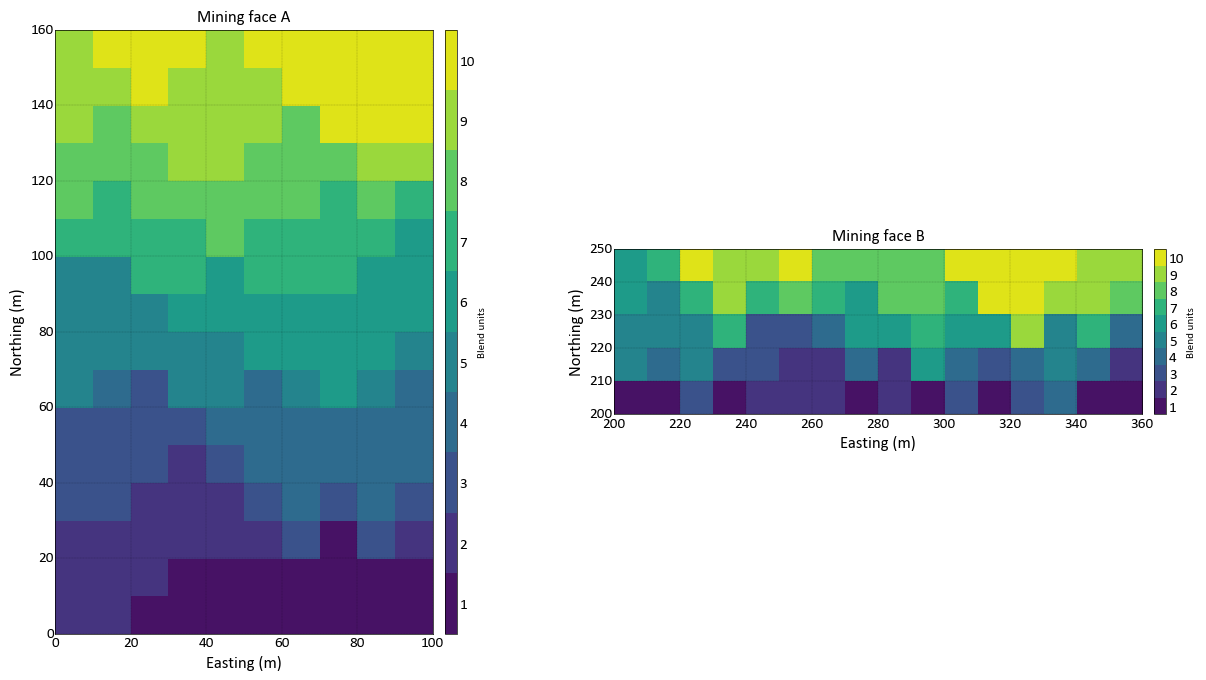

In [199]:
##visualizing optimized schedule
#if few units, use .astype(int)
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes=axes.flatten()
_=gs.slice_plot(data=best_blend.astype(int).flatten(order='F'),griddef=grid,catdata=True, ax=axes[0], title='Mining face A', grid=True,cmap='viridis', cbar_label='Blend units')
_=gs.slice_plot(data=best_blend2.astype(int).flatten(order='F'),griddef=grid2,catdata=True, ax=axes[1],title='Mining face B',grid=True,cmap='viridis', cbar_label='Blend units')
plt.savefig (figfolder+'/ant_sched.png', bbox_inches = 'tight', dpi = 300)

In [200]:
increase = ((best_tmr-dflt_tmr)/dflt_tmr)*100
print('% increase in total metal recovered is {:.2f}%'.format(increase))

% increase in total metal recovered is 2.77%


In [201]:
best_tmr_list = np.multiply(best_att_unit,best_g_unit)
best_tmr_list = best_tmr_list.tolist()

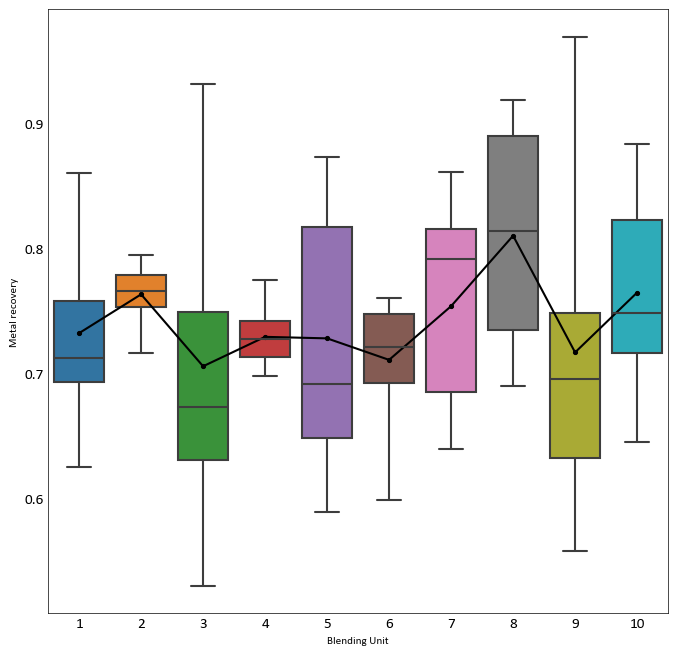

In [202]:
b_means = [np.mean(i) for i in best_att_unit]
ax=sns.boxplot(data=best_att_unit,whis=5)
ax=sns.lineplot(data=b_means,color='black',marker='o',markerfacecolor="black", markeredgecolor="black",markersize='3')
ax.set_xlabel('Blending Unit')
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
ax.set_ylabel('Metal recovery')
plt.savefig (figfolder+'/ant_rec.png', bbox_inches = 'tight', dpi = 300)

#### convergence

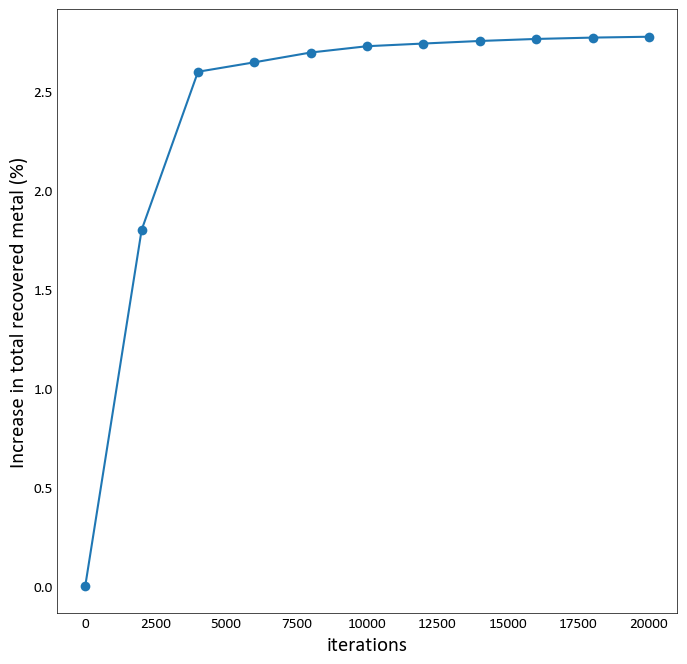

In [203]:
#visualizing if the seed changes the optimized result
n_iterations=20000
plt.xlabel('iterations',fontsize=15)
plt.ylabel('Increase in total recovered metal (%)',fontsize=15)
itera_values = list(range(0, n_iterations+1, int((n_iterations)/10)))

y_val=[]
for val in conv_lst_tmr:
    y_val.append(100*(val-conv_lst_tmr[0])/conv_lst_tmr[0])

plt.plot(itera_values, y_val, '-o')
plt.savefig(figfolder+'/it_conv_ant.png', bbox_inches = 'tight', dpi = 300)